<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPCHF/GBPCHF_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPCHF=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.5206  1.5752  1.5175  1.5685     1.5685       0
2009-01-02  1.5675  1.5790  1.5372  1.5671     1.5671       0
2009-01-05  1.5557  1.6334  1.5530  1.6306     1.6306       0
2009-01-06  1.6305  1.6747  1.6201  1.6637     1.6637       0
2009-01-07  1.6642  1.6730  1.6346  1.6631     1.6631       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.2514  1.2592  1.2514  1.2508     1.2508       0
2018-12-27  1.2574  1.2576  1.2452  1.2574     1.2574       0
2018-12-28  1.2481  1.2493  1.2416  1.2481     1.2481       0
2018-12-31  1.2481  1.2632  1.2477  1.2481     1.2481       0
2019-01-01  1.2527  1.2528  1.2496  1.2527     1.2527       0

[2604 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000  2604.0
mean      1.454846     1.460894     1.448688     1.454886     1.454886     0.0
std       0.134980     0.135977     0.134291     0.135070     0.135070     0.0
min       1.169600     1.193100     1.124100     1.170100     1.170100     0.0
25%       1.333850     1.341775     1.326450     1.333600     1.333600     0.0
50%       1.459950     1.465250     1.454900     1.460100     1.460100     0.0
75%       1.525100     1.531400     1.519425     1.525050     1.525050     0.0
max       1.803000     1.810500     1.802100     1.803100     1.803100     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.5993  1.6556  1.5886  1.6526     1.6526   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.638750  1.634261 -1.686466  1.618598  1.630550  1.621977     1.62750     1.62645  1.659580  1.630100  1.618824  1.624075  1.623222  1.630100  1.616600  1.654680                1.681903                 1.630100                1.578297                1.707805                 1.630100                1.552395                1.733707                 1.630100                1.526493                1.759608                 1.630100                1.500592  1.630550  1.628266  1.652563                1.682354                 1.630550                1.578747                1.708255                 1.630550                1.552845                1.734157                 1.630550                1.526944                1.760059                 1.630550                1.501042   
2009-03-13  1.6522  1.6726  1.6497  1.6590     1.6590   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.648875  1.637914 -1.676340  1.632494  1.636873  1.622286     1.62825     1.62890  1.585200  1.630800  1.638560  1.619840  1.629644  1.630800  1.655800  1.651696                1.683977                 1.630800                1.577623                1.710565                 1.630800                1.551035                1.737154                 1.630800                1.524446                1.763742                 1.630800                1.497858  1.636873  1.651019  1.649333                1.690049                 1.636873                1.583696                1.716638                 1.636873                1.557107                1.743226                 1.636873                1.530519                1.769815                 1.636873                1.503930   
2009-03-16  1.6593  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000    2554.000000   2554.000000     2554.000000     2554.000000       2554.000000  2554.000000  2554.000000  2554.000000  2554.000000   2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000   
mean      1.451107     1.456916     1.445136     1.451150     1.451150    15.748238     1.998825   186.049334      30.467502      0.032890        0.966719        0.010963          0.989037     6.620204     2.538371    27.026625     1.998825      2.000000    27.026625     1.451493     1.452781     0.004407     1.451123     1.451660     1.450928     1.451516     1.451179     1.450823     1.451648     1.451136     1.451643     1.451476     1.451648     1.451232     1.452748                1.469623                 1.451648                1.433673                1.478610                 1.451648                1.424685                1.487598                 1.451648                1.415698                1.496585                 1.451648                1.406710     1.451660     1.451252     1.452582                1.469635                 1.451660                1.433685                1.478622                 1.451660                1.424697                1.487610   
std       0.133478     0.134163     0.133039     0.133597     0.133597     8.802465     1.414628   104.359922       0.781645      0.178383        0.179405        0.104150          0.104150     3.412472     1.107737    14.923728     1.414628      1.414491    14.923728     0.133175     0.132091     1.457708     0.133666     0.132823     0.132538     0.133079     0.133415     0.135667     0.133015     0.133690     0.133116     0.133109     0.133015     0.133372     0.132274                0.134964                 0.133015                0.132763                0.136555                 0.133015                0.133279                0.138539                 0.133015                0.134218                0.140900                 0.133015                0.135570     0.132823     0.133345     0.132369                0.134727                 0.132823                0.132618                0.136298                 0.132823                0.133159                0.138262   
min       1.169600     1.193100     1.124100     1.170100     1.170100     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.678402  0.749109  0.685103  0.762243   0.762243   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.733579  0.738404  0.034612  0.704244  0.726884  0.721309    0.718188    0.716816  0.780129  0.721637  0.706634  0.710965  0.709833  0.721637  0.709616  0.777435                0.779759                 0.721637                0.679345                0.803160                 0.721637                0.690731                0.742707                 0.721637                0.707277                0.668135                 0.721637                0.719990  0.726884  0.726010  0.772484                0.778627                 0.726884                0.683915                0.802991                 0.726884                0.703489                0.783727                 0.726884                0.718044                0.699844                 0.726884   
2009-03-13  0.761920  0.776644  0.775221  0.772354   0.772354   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.750897  0.744873  0.037438  0.727005  0.737683  0.721845    0.719460    0.720970  0.671766  0.722831  0.738079  0.703783  0.720705  0.722831  0.772529  0.772198                0.783242                 0.722831                0.678282                0.807719                 0.722831                0.688844                0.747738                 0.722831                0.704810                0.673326                 0.722831                0.717077  0.737683  0.762821  0.766838                0.791530                 0.737683                0.691763                0.816811                 0.737683                0.709255                0.797656                 0.737683                0.722260                0.712641                 0.737683   
2009-03-16  0.773129  0.793327  0.789381  0.784360   0.784360   16          0         75

137188

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 45 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_8gijzd
H2O cluster total nodes:    1
H2O cluster free memory:    8.44 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.670210  0.676879              0.352151  0.491177  0.241255
1  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.629765  0.956945              0.375122  0.551306  0.303939
2  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.615652  0.700796              0.400782  0.498243  0.248246
3  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.603067  0.809222              0.467253  0.529430  0.280296
4  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.544172  0.693265              0.447092  0.500065  0.250065
5  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.500000  0.694408              0.500000  0.500630  0.250630
6  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.500000  0.693897              0.500000  0.500375  0.250375
7              DeepLearning_1_AutoML_20190822_120012  0.500000  0.692811              0.500000  0.499832  0.249832
8  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.500000  0.693214              0.500000  0.500033  0.250033
9  DeepLearning_grid_1_AutoML_20190822_120012_mod...  0.500000  0.693023              0.500000  0.499937  0.249937

variable  relative_importance  scaled_importance  percentage
0                         SUB             1.000000           1.000000    0.004289
1                         DIV             0.986431           0.986431    0.004231
2             CDLLADDERBOTTOM             0.821413           0.821413    0.003523
3             CDLHOMINGPIGEON             0.808170           0.808170    0.003466
4             CDLADVANCEBLOCK             0.807844           0.807844    0.003465
...                       ...                  ...                ...         ...
1014  BBANDS_middleband_8_1_3             0.174823           0.174823    0.000750
1015  BBANDS_middleband_8_0_2             0.171542           0.171542    0.000736
1016              CDLMARUBOZU             0.163071           0.163071    0.000699
1017       CDLSEPARATINGLINES             0.156639           0.156639    0.000672
1018      CDLXSIDEGAP3METHODS             0.152709           0.152709    0.000655

[1019 rows x 4 columns]

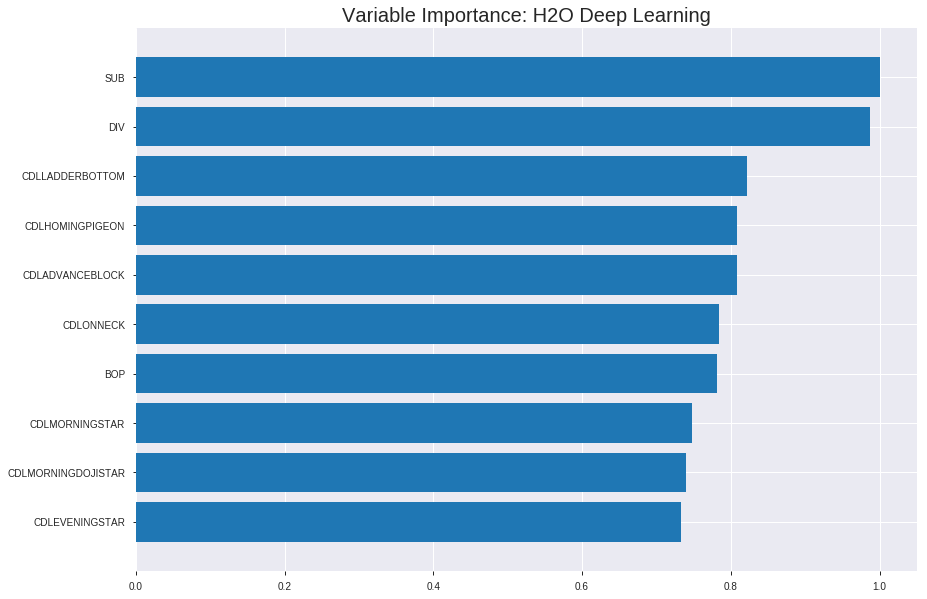

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_120012_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22853466467848496
RMSE: 0.47805299358803827
LogLoss: 0.6734647179409321
Mean Per-Class Error: 0.35415915080820537
AUC: 0.6968447173536161
pr_auc: 0.6711727299234592
Gini: 0.39368943470723217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2570200201939733: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      316  583   0.6485   (583.0/899.0)
1      106  782   0.1194   (106.0/888.0)
Total  422  1365  0.3856   (689.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25702      0.694186  297
max f2                       0.0275182    0.836477  389
max f0point5                 0.517295     0.645787  175
max accuracy                 0.434291     0.645775  215
max precision                0.879236     0.825688  37
max recall                   0.0041905    1         398
max specificity              0.999697     0.997775  0
max absolute_mcc             0.517295     0.295281  175
max min_per_class_accuracy   0.440853     0.637387  212
max mean_per_class_accuracy  0.434291     0.645841  215

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 45.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.995082           1.56519   1.56519            0.777778         0.998321   0.777778                    0.998321            0.0157658       0.0157658                  56.519    56.519
    2        0.0201455                   0.969562           1.45339   1.50929            0.722222         0.982354   0.75                        0.990337            0.0146396       0.0304054                  45.3391   50.9291
    3        0.0302182                   0.934108           1.78879   1.60246            0.888889         0.95143    0.796296                    0.977368            0.018018        0.0484234                  78.8789   60.2457
    4        0.040291                    0.911393           1.67699   1.62109            0.833333         0.922671   0.805556                    0.963694            0.0168919       0.0653153                  67.6989   62.109
    5        0.0503637                   0.896823           1.67699   1.63227            0.833333         0.902946   0.811111                    0.951544            0.0168919       0.0822072                  67.6989   63.227
    6        0.100168                    0.811554           1.60539   1.6189             0.797753         0.851106   0.804469                    0.901606            0.079955        0.162162                   60.5388   61.8904
    7        0.149972                    0.741148           1.31144   1.5168             0.651685         0.77115    0.753731                    0.858283            0.0653153       0.227477                   31.1443   51.6799
    8        0.200336                    0.680663           1.25215   1.45027            0.622222         0.711319   0.72067                     0.821337            0.0630631       0.290541                   25.2152   45.0268
    9        0.299944                    0.581438           1.32275   1.40792            0.657303         0.632025   0.699627                    0.758468            0.131757        0.422297                   32.2749   40.792
    10       0.400112                    0.498985           1.16921   1.34816            0.581006         0.538288   0.66993                     0.703346            0.117117        0.539414                   16.9208   34.8159
    11       0.50028                     0.437529           1.01181   1.28081            0.502793         0.468166   0.636465                    0.656258            0.101351        0.640766                   1.18149   28.0815
    12       0.599888                    0.376887           0.93836   1.22395            0.466292         0.408086   0.608209                    0.61505             0.0934685       0.734234                   -6.16396  22.3952
    13       0.700056                    0.310613           0.944361  1.18395            0.469274         0.342755   0.588329                    0.576088            0.0945946       0.828829                   -5.56394  18.3947
    14       0.799664                    0.224188           0.757472  1.13082            0.376404         0.268451   0.561931                    0.537768            0.0754505       0.904279                   -24.2528  13.0824
    15       0.899832                    0.118331           0.494665  1.06001            0.24581          0.173641   0.526741                    0.497234            0.0495495       0.953829                   -50.5335  6.00075
    16       1                           5.15563e-23        0.460938  1                  0.22905          0.0626261  0.496922                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2627066980879651
RMSE: 0.5125492152837278
LogLoss: 0.7506655975891736
Mean Per-Class Error: 0.3976987801688997
AUC: 0.601593625498008
pr_auc: 0.5546921573117595
Gini: 0.20318725099601598
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19417583360567361: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      43   216  0.834    (216.0/259.0)
1      13   238  0.0518   (13.0/251.0)
Total  56   454  0.449    (229.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.194176     0.675177  350
max f2                       0.0609743    0.831126  395
max f0point5                 0.378949     0.599872  256
max accuracy                 0.389296     0.6       250
max precision                0.923183     0.722222  17
max recall                   0.0609743    1         395
max specificity              0.998599     0.996139  0
max absolute_mcc             0.371077     0.214314  264
max min_per_class_accuracy   0.460745     0.583012  205
max mean_per_class_accuracy  0.378949     0.602301  256

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.981998           1.01594   1.01594            0.5              0.990152  0.5                         0.990152            0.0119522       0.0119522                  1.59363    1.59363
    2        0.0215686                   0.954825           1.6255    1.29301            0.8              0.966524  0.636364                    0.979412            0.0159363       0.0278884                  62.5498    29.301
    3        0.0313725                   0.927504           1.6255    1.39691            0.8              0.939932  0.6875                      0.967075            0.0159363       0.0438247                  62.5498    39.6912
    4        0.0411765                   0.904006           0.812749  1.25783            0.4              0.917776  0.619048                    0.955337            0.00796813      0.0517928                  -18.7251   25.7826
    5        0.0509804                   0.874889           0.812749  1.17223            0.4              0.88428   0.576923                    0.941672            0.00796813      0.059761                   -18.7251   17.2234
    6        0.1                         0.794244           0.975299  1.0757             0.48             0.835458  0.529412                    0.889606            0.0478088       0.10757                    -2.47012   7.56972
    7        0.15098                     0.732899           1.32853   1.16107            0.653846         0.763929  0.571429                    0.84717             0.0677291       0.175299                   32.8532    16.107
    8        0.2                         0.687495           0.812749  1.0757             0.4              0.710653  0.529412                    0.81371             0.0398406       0.215139                   -18.7251   7.56972
    9        0.3                         0.607813           1.11554   1.08898            0.54902          0.645167  0.535948                    0.757529            0.111554        0.326693                   11.5538    8.89774
    10       0.4                         0.538857           1.2749    1.13546            0.627451         0.572716  0.558824                    0.711326            0.12749         0.454183                   27.49      13.5458
    11       0.5                         0.460351           1.31474   1.17131            0.647059         0.497376  0.576471                    0.668536            0.131474        0.585657                   31.4741    17.1315
    12       0.6                         0.405223           0.996016  1.1421             0.490196         0.429837  0.562092                    0.628753            0.0996016       0.685259                   -0.398406  14.2098
    13       0.7                         0.342611           0.996016  1.12123            0.490196         0.376366  0.551821                    0.592697            0.0996016       0.784861                   -0.398406  12.1229
    14       0.8                         0.276302           0.796813  1.08068            0.392157         0.307475  0.531863                    0.557044            0.0796813       0.864542                   -20.3187   8.06773
    15       0.9                         0.183854           0.876494  1.05799            0.431373         0.230813  0.520697                    0.520797            0.0876494       0.952191                   -12.3506   5.79903
    16       1                           6.60743e-06        0.478088  1                  0.235294         0.126247  0.492157                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:05:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:05:55  5 min 42.007 sec  457 obs/sec       0.536654  1             959        0.651701         2.7257              -0.698919      0.543107        0.435558           1.34159          0.503078                         0.663579           2.85699               -0.761784        0.53298           0.48725              1.35458            0.484314
    2019-08-22 12:06:09  5 min 55.981 sec  528 obs/sec       4.36318   8             7797       0.551528         1.56305             -0.21678       0.651642        0.558043           1.78879          0.44376                          0.644271           1.77757               -0.660747        0.521897          0.517378             1.69323            0.503922
    2019-08-22 12:06:23  6 min  9.736 sec  543 obs/sec       8.24398   15            14732      0.561907         1.98334             -0.263006      0.624198        0.586928           1.45339          0.503078                         0.584073           1.32692               -0.364902        0.584558          0.54687              1.35458            0.460784
    2019-08-22 12:06:38  6 min 24.711 sec  554 obs/sec       12.6503   23            22606      0.547969         1.16272             -0.201126      0.6267          0.530705           1.67699          0.457191                         0.641664           1.70492               -0.647337        0.556654          0.54374              1.69323            0.476471
    2019-08-22 12:06:53  6 min 39.652 sec  562 obs/sec       17.0957   31            30550      0.513778         0.791536            -0.05591       0.679972        0.649739           1.56519          0.40235                          0.681391           2.17311               -0.857635        0.585373          0.544551             0.677291           0.490196
    2019-08-22 12:07:07  6 min 54.275 sec  566 obs/sec       21.4298   39            38295      0.519785         0.803491            -0.0807476     0.659585        0.651563           1.67699          0.431449                         0.633253           1.49221               -0.604434        0.527404          0.529049             1.01594            0.5
    2019-08-22 12:07:22  7 min  9.179 sec  568 obs/sec       25.836    47            46169      0.46962          0.634605            0.117794       0.702687        0.684921           1.56519          0.364857                         0.530971           0.777353              -0.127998        0.581804          0.55097              1.35458            0.496078
    2019-08-22 12:07:37  7 min 23.554 sec  572 obs/sec       30.202    55            53971      0.469569         0.635251            0.117987       0.704305        0.680182           1.45339          0.385562                         0.547296           0.854173              -0.198426        0.574851          0.551395             1.35458            0.476471
    2019-08-22 12:07:51  7 m

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
SUB                      1.0                    1.0                  0.00428913928025069
DIV                      0.9864312410354614     0.9864312410354614   0.004230940983191633
CDLLADDERBOTTOM          0.8214126825332642     0.8214126825332642   0.0035231534019495125
CDLHOMINGPIGEON          0.808169960975647      0.808169960975647    0.003466353524739314
CDLADVANCEBLOCK          0.8078437447547913     0.8078437447547913   0.003464954337932587
---                      ---                    ---                  ---
BBANDS_middleband_8_1_3  0.17482270300388336    0.17482270300388336  0.0007498389225335563
BBANDS_middleband_8_0_2  0.17154188454151154    0.17154188454151154  0.0007357670351952257
CDLMARUBOZU              0.1630709022283554     0.1630709022283554   0.0006994338122135588
CDLSEPARATINGLINES       0.15663902461528778    0.15663902461528778  0.0006718465932975855
CDLXSIDEGAP3METHODS      0.152709499001503      0.152709499001503    0.0006549923106347499


See the whole table with table.as_data_frame()


('accuracy', 0.671875)

('F1', 0.7333333333333334)

('auc', 0.6702101661779082)

('logloss', 0.6768787163746119)

('mean_per_class_error', 0.33333333333333326)

('rmse', 0.4911774310581716)

('mse', 0.24125526878090492)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


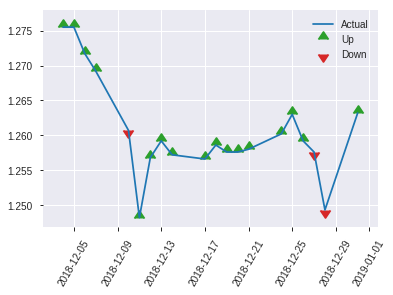


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24125526878090492
RMSE: 0.4911774310581716
LogLoss: 0.6768787163746119
Mean Per-Class Error: 0.33333333333333326
AUC: 0.6702101661779082
pr_auc: 0.6211994778011994
Gini: 0.34042033235581637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2556529102766648: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   77   0.621    (77.0/124.0)
1      11   121  0.0833   (11.0/132.0)
Total  58   198  0.3438   (88.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255653     0.733333  197
max f2                       0.0929041    0.851613  246
max f0point5                 0.316166     0.670732  171
max accuracy                 0.316166     0.671875  171
max precision                0.866855     1         0
max recall                   0.0929041    1         246
max specificity              0.866855     1         0
max absolute_mcc             0.316166     0.354791  171
max min_per_class_accuracy   0.417354     0.637097  129
max mean_per_class_accuracy  0.316166     0.666667  171

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 42.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.843597           1.93939   1.93939            1                0.85977   1                           0.85977             0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.833137           1.29293   1.61616            0.666667         0.834845  0.833333                    0.847307            0.0151515       0.0378788                  29.2929   61.6162
    3        0.03125                     0.816572           0         1.21212            0                0.83005   0.625                       0.842993            0               0.0378788                  -100      21.2121
    4        0.0429688                   0.792808           0.646465  1.05785            0.333333         0.802688  0.545455                    0.832001            0.00757576      0.0454545                  -35.3535  5.78512
    5        0.0507812                   0.772966           0         0.895105           0                0.784107  0.461538                    0.824633            0               0.0454545                  -100      -10.4895
    6        0.101562                    0.675211           1.34266   1.11888            0.692308         0.711706  0.576923                    0.768169            0.0681818       0.113636                   34.2657   11.8881
    7        0.152344                    0.634106           1.49184   1.2432             0.769231         0.654235  0.641026                    0.730191            0.0757576       0.189394                   49.1841   24.3201
    8        0.203125                    0.602234           1.34266   1.26807            0.692308         0.613919  0.653846                    0.701123            0.0681818       0.257576                   34.2657   26.8065
    9        0.300781                    0.553011           1.08606   1.20897            0.56             0.578537  0.623377                    0.661322            0.106061        0.363636                   8.60606   20.8973
    10       0.402344                    0.487522           1.34266   1.24272            0.692308         0.518632  0.640777                    0.625303            0.136364        0.5                        34.2657   24.2718
    11       0.5                         0.423241           1.31879   1.25758            0.68             0.454901  0.648438                    0.592022            0.128788        0.628788                   31.8788   25.7576
    12       0.601562                    0.366713           1.19347   1.24675            0.615385         0.388534  0.642857                    0.557667            0.121212        0.75                       19.3473   24.6753
    13       0.699219                    0.2874             1.00848   1.21348            0.52             0.334264  0.625698                    0.526465            0.0984848       0.848485                   0.848485  21.3476
    14       0.800781                    0.231376           0.671329  1.14472            0.346154         0.26181   0.590244                    0.492899            0.0681818       0.916667                   -32.8671  14.4715
    15       0.898438                    0.179954           0.387879  1.06245            0.2              0.203452  0.547826                    0.461437            0.0378788       0.954545                   -61.2121  6.24506
    16       1                           0.0239436          0.447552  1                  0.230769         0.109824  0.515625                    0.425727        

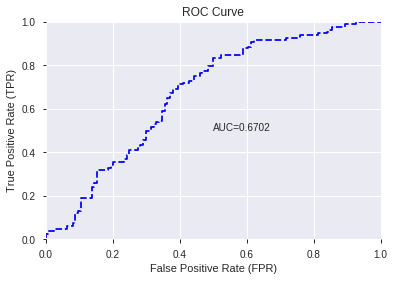

This function is available for GLM models only


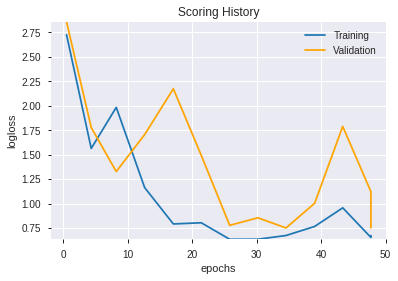

--2019-08-22 12:34:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


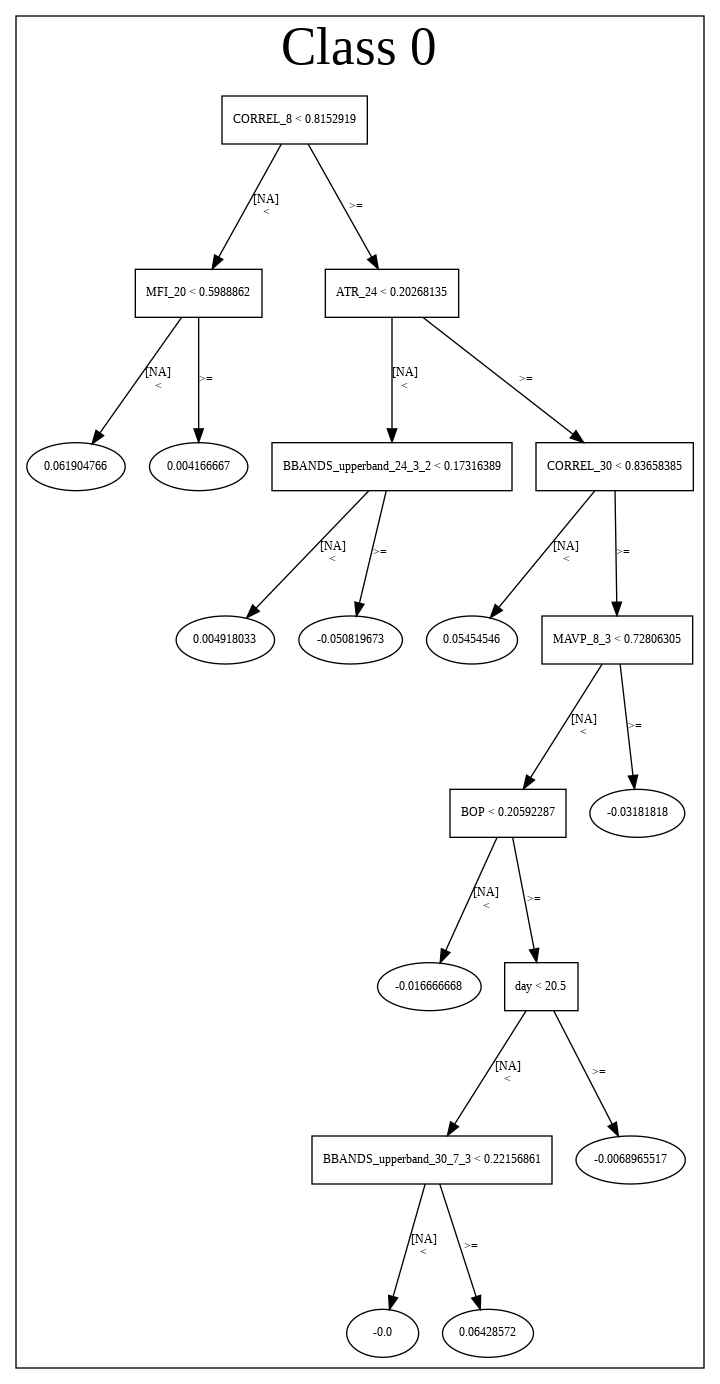

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_120012_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_120012_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_123413_model_6  0.697458  0.633631              0.388685  0.472549  0.223302
1  DeepLearning_grid_1_AutoML_20190822_123413_model_5  0.679191  0.640904              0.425953  0.475936  0.226515
2  DeepLearning_grid_1_AutoML_20190822_123413_model_8  0.674120  0.642976              0.393206  0.477419  0.227929
3  DeepLearning_grid_1_AutoML_20190822_123413_model_9  0.666422  0.645333              0.380865  0.477402  0.227913
4  DeepLearning_grid_1_AutoML_20190822_123413_model_3  0.654203  0.682325              0.413368  0.486486  0.236669
5  DeepLearning_grid_1_AutoML_20190822_123413_model_7  0.653409  0.752307              0.463465  0.511891  0.262032
6  DeepLearning_grid_1_AutoML_20190822_123413_model_2  0.634653  0.711551              0.446848  0.500050  0.250050
7  DeepLearning_grid_1_AutoML_20190822_123413_model_1  0.621273  0.847592              0.475073  0.518093  0.268421
8  DeepLearning_grid_1_AutoML_20190822_123413_model_4  0.614797  0.781610              0.459189  0.520964  0.271404
9               DeepLearning_1_AutoML_20190822_123413  0.611681  0.684705              0.421676  0.492825  0.242877

variable  relative_importance  scaled_importance  percentage
0                  DIV             1.000000           1.000000    0.038498
1                  SUB             0.960306           0.960306    0.036970
2                  BOP             0.877485           0.877485    0.033781
3               ULTOSC             0.640174           0.640174    0.024645
4            dayofyear             0.631051           0.631051    0.024294
5               TRANGE             0.621475           0.621475    0.023925
6       CDLRICKSHAWMAN             0.615485           0.615485    0.023695
7               SAREXT             0.614502           0.614502    0.023657
8               VAR_30             0.575637           0.575637    0.022161
9               VAR_12             0.570536           0.570536    0.021964
10   CDLINVERTEDHAMMER             0.565476           0.565476    0.021770
11        STOCHF_fastk             0.557881           0.557881    0.021477
12             CDLDOJI             0.557224           0.557224    0.021452
13   CDLGRAVESTONEDOJI             0.553166           0.553166    0.021296
14              VAR_14             0.549657           0.549657    0.021161
15   CDLLONGLEGGEDDOJI             0.547975           0.547975    0.021096
16              VAR_24             0.545486           0.545486    0.021000
17      CDLMORNINGSTAR             0.536780           0.536780    0.020665
18      CDLEVENINGSTAR             0.535112           0.535112    0.020601
19     CDLADVANCEBLOCK             0.533466           0.533466    0.020537
20               VAR_8             0.531493           0.531493    0.020461
21                 day             0.529601           0.529601    0.020389
22     CDLLADDERBOTTOM             0.528829           0.528829    0.020359
23       days_in_month             0.520076           0.520076    0.020022
24            CORREL_8             0.518802           0.518802    0.019973
25             WILLR_8             0.511389           0.511389    0.019687
26           CDLONNECK             0.511360           0.511360    0.019686
27        weekday_name             0.506276           0.506276    0.019491
28  CDLMORNINGDOJISTAR             0.504978           0.504978    0.019441
29           CDLTAKURI             0.504596           0.504596    0.019426
30        HT_TRENDMODE             0.498283           0.498283    0.019183
31      STOCHRSI_fastk             0.491914           0.491914    0.018938
32  CDLEVENINGDOJISTAR             0.486890           0.486890    0.018744
33    CDLDRAGONFLYDOJI             0.483823           0.483823    0.018626
34              VAR_20             0.476603           0.476603    0.018348
35     CDLHOMINGPIGEON             0.471183           0.471183    0.018140
36      CDLSPINNINGTOP             0.466902           0.466902    0.017975
37           CORREL_30             0.449765           0.449765    0.017315
38      CDLHARAMICROSS             0.446336           0.446336    0.017183
39    CDLCOUNTERATTACK             0.438091           0.438091    0.016866
40          CDL3INSIDE             0.409461           0.409461    0.015763
41    is_quarter_start             0.401256           0.401256    0.015448
42        is_month_end             0.398968           0.398968    0.015359
43      is_quarter_end             0.373041           0.373041    0.014361
44     CDLSHOOTINGSTAR             0.366484           0.366484    0.014109
45        CDLTASUKIGAP             0.355351           0.355351    0.013680
46      CDLMATCHINGLOW             0.318626           0.318626    0.012266
47      is_month_start             0.314909           0.314909    0.012123
48           CDLHAMMER             0.309478           0.309478    0.011914
49       CDLHANGINGMAN             0.261805           0.261805    0.010079

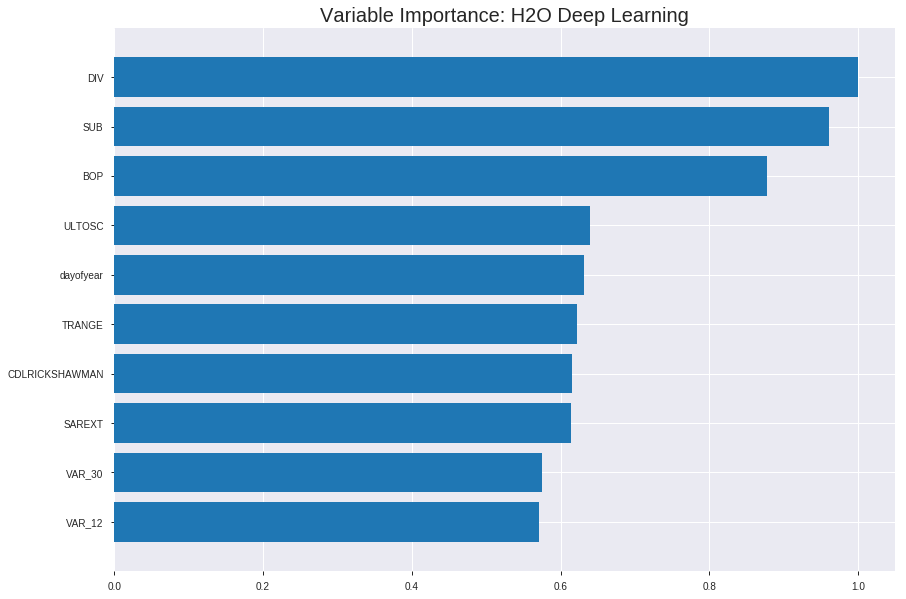

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_123413_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20835656801725977
RMSE: 0.45646091619903206
LogLoss: 0.5983758594367994
Mean Per-Class Error: 0.33913056549319065
AUC: 0.7323947278758179
pr_auc: 0.726996466733349
Gini: 0.4647894557516359
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4661929224193831: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      358  541   0.6018   (541.0/899.0)
1      97   791   0.1092   (97.0/888.0)
Total  455  1332  0.357    (638.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466193     0.712613  236
max f2                       0.290659     0.848597  314
max f0point5                 0.532074     0.668159  170
max accuracy                 0.509301     0.661444  189
max precision                0.970627     1         0
max recall                   0.0758124    1         379
max specificity              0.970627     1         0
max absolute_mcc             0.532074     0.337125  170
max min_per_class_accuracy   0.491248     0.653153  206
max mean_per_class_accuracy  0.507282     0.660869  191

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.919077           2.01239   2.01239            1                0.945385  1                           0.945385            0.0202703       0.0202703                  101.239   101.239
    2        0.0201455                   0.876264           1.78879   1.90059            0.888889         0.893709  0.944444                    0.919547            0.018018        0.0382883                  78.8789   90.0588
    3        0.0302182                   0.84976            2.01239   1.93785            1                0.863862  0.962963                    0.900985            0.0202703       0.0585586                  101.239   93.7855
    4        0.040291                    0.83925            1.56519   1.84469            0.777778         0.844322  0.916667                    0.886819            0.0157658       0.0743243                  56.519    84.4688
    5        0.0503637                   0.807964           1.67699   1.81115            0.833333         0.821228  0.9                         0.873701            0.0168919       0.0912162                  67.6989   81.1149
    6        0.100168                    0.704029           1.67322   1.74257            0.831461         0.755493  0.865922                    0.814927            0.0833333       0.17455                    67.3221   74.257
    7        0.149972                    0.629228           1.4245    1.63694            0.707865         0.666469  0.813433                    0.765626            0.0709459       0.245495                   42.4499   63.6942
    8        0.200336                    0.59316            1.31923   1.55707            0.655556         0.609251  0.773743                    0.726314            0.0664414       0.311937                   31.9232   55.7071
    9        0.299944                    0.536385           1.39058   1.50178            0.691011         0.561109  0.746269                    0.671451            0.138514        0.45045                    39.0582   50.1782
    10       0.400112                    0.507678           1.12424   1.40726            0.558659         0.521254  0.699301                    0.633849            0.112613        0.563063                   12.4239   40.7264
    11       0.50028                     0.490642           0.910633  1.30783            0.452514         0.498061  0.649888                    0.606661            0.0912162       0.654279                   -8.93666  30.7827
    12       0.599888                    0.485578           0.881833  1.23709            0.438202         0.487979  0.614739                    0.586955            0.0878378       0.742117                   -11.8167  23.7093
    13       0.700056                    0.476831           1.07927   1.21451            0.536313         0.482241  0.603517                    0.571972            0.108108        0.850225                   7.92692   21.451
    14       0.799664                    0.426477           0.746166  1.15617            0.370787         0.459583  0.574528                    0.557972            0.0743243       0.92455                    -25.3834  15.6172
    15       0.899832                    0.254822           0.607089  1.09505            0.301676         0.352836  0.544154                    0.535137            0.0608108       0.98536                    -39.2911  9.50491
    16       1                           0.000893025        0.146151  1                  0.0726257        0.13074   0.496922                    0.494629           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23815794472996038
RMSE: 0.48801428742400604
LogLoss: 0.6720424993260403
Mean Per-Class Error: 0.40891261209986307
AUC: 0.6148533280007383
pr_auc: 0.5830554992970701
Gini: 0.22970665600147666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3678582546140859: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      53   206  0.7954   (206.0/259.0)
1      13   238  0.0518   (13.0/251.0)
Total  66   444  0.4294   (219.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367858     0.684892  336
max f2                       0.0931251    0.83167   388
max f0point5                 0.482599     0.591824  253
max accuracy                 0.524443     0.588235  146
max precision                0.974693     1         0
max recall                   0.0515086    1         395
max specificity              0.974693     1         0
max absolute_mcc             0.367858     0.227647  336
max min_per_class_accuracy   0.491457     0.544402  214
max mean_per_class_accuracy  0.482599     0.591087  253

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 48.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.891847           1.01594   1.01594            0.5              0.932181  0.5                         0.932181            0.0119522       0.0119522                  1.59363   1.59363
    2        0.0215686                   0.827562           1.6255    1.29301            0.8              0.848834  0.636364                    0.894296            0.0159363       0.0278884                  62.5498   29.301
    3        0.0313725                   0.789569           1.6255    1.39691            0.8              0.802774  0.6875                      0.865696            0.0159363       0.0438247                  62.5498   39.6912
    4        0.0411765                   0.761269           1.21912   1.35458            0.6              0.775047  0.666667                    0.844113            0.0119522       0.0557769                  21.9124   35.4582
    5        0.0509804                   0.70625            0.812749  1.25038            0.4              0.728465  0.615385                    0.821873            0.00796813      0.063745                   -18.7251  25.0383
    6        0.1                         0.615091           1.38167   1.31474            0.68             0.647996  0.647059                    0.736639            0.0677291       0.131474                   38.1673   31.4741
    7        0.15098                     0.579285           1.25038   1.29301            0.615385         0.596728  0.636364                    0.689396            0.063745        0.195219                   25.0383   29.301
    8        0.2                         0.558804           1.3004    1.29482            0.64             0.570668  0.637255                    0.660296            0.063745        0.258964                   30.0398   29.4821
    9        0.3                         0.529675           1.23506   1.2749             0.607843         0.54416   0.627451                    0.621584            0.123506        0.38247                    23.506    27.49
    10       0.4                         0.505151           0.876494  1.1753             0.431373         0.517468  0.578431                    0.595555            0.0876494       0.47012                    -12.3506  17.5299
    11       0.5                         0.491357           0.756972  1.09163            0.372549         0.498103  0.537255                    0.576065            0.0756972       0.545817                   -24.3028  9.16335
    12       0.6                         0.486628           1.23506   1.11554            0.607843         0.488721  0.54902                     0.561507            0.123506        0.669323                   23.506    11.5538
    13       0.7                         0.479835           1.19522   1.12692            0.588235         0.483887  0.554622                    0.550419            0.119522        0.788845                   19.5219   12.6921
    14       0.8                         0.445869           0.836653  1.09064            0.411765         0.466401  0.536765                    0.539917            0.0836653       0.87251                    -16.3347  9.06375
    15       0.9                         0.293605           0.916335  1.07127            0.45098          0.389194  0.527233                    0.52317             0.0916335       0.964143                   -8.36653  7.12705
    16       1                           0.0185171          0.358566  1                  0.176471         0.155889  0.492157                    0.486442            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:38:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:38:32  2 min 14.941 sec  940 obs/sec       1.36038   1             2431       0.50565          0.723844            -0.0227673     0.624544        0.60949            1.22979          0.473979                         0.518892           0.759789              -0.0772605       0.577682          0.5424               1.01594            0.498039
    2019-08-22 12:38:40  2 min 22.889 sec  1983 obs/sec      10.8836   8             19449      0.479399         0.646851            0.0806733      0.680252        0.668362           1.90059          0.397874                         0.499371           0.692554              0.00226741       0.612423          0.559614             1.35458            0.421569
    2019-08-22 12:38:48  2 min 30.632 sec  2308 obs/sec      21.6978   16            38774      0.464491         0.616658            0.13696        0.709215        0.700021           1.90059          0.380526                         0.492806           0.683721              0.0283303        0.611346          0.57169              1.35458            0.417647
    2019-08-22 12:38:56  2 min 38.287 sec  2456 obs/sec      32.5702   24            58203      0.456461         0.598376            0.166542       0.732395        0.726996           2.01239          0.357023                         0.488014           0.672042              0.0471338        0.614853          0.583055             1.01594            0.429412
    2019-08-22 12:39:03  2 min 45.874 sec  2539 obs/sec      43.427    32            77604      0.452763         0.590042            0.179991       0.749005        0.748728           2.01239          0.373811                         0.495472           0.691417              0.0177878        0.620176          0.580273             1.69323            0.431373
    2019-08-22 12:39:11  2 min 53.237 sec  2612 obs/sec      54.3397   40            97105      0.4401           0.562479            0.225218       0.775441        0.769751           2.01239          0.324007                         0.495096           0.694                 0.0192777        0.615246          0.583964             1.01594            0.429412
    2019-08-22 12:39:19  3 min  1.221 sec  2681 obs/sec      66.6206   49            119051     0.433197         0.54696             0.249334       0.79382         0.790147           2.01239          0.315053                         0.496047           0.69936               0.0155066        0.618914          0.586272             1.35458            0.417647
    2019-08-22 12:39:20  3 min  1.977 sec  2680 obs/sec      66.6206   49            119051     0.456461         0.598376            0.166542       0.732395        0.726996           2.01239          0.357023                         0.488014           0.672042              0.0471338        0.614853          0.583055             1.01594            0.429412

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
DIV             1.0                    1.0                  0.03849789645103276
SUB             0.9603060483932495     0.9603060483932495   0.03696976281234378
BOP             0.8774851560592651     0.8774851560592651   0.03378133267528792
ULTOSC          0.6401740312576294     0.6401740312576294   0.02464535356599643
dayofyear       0.6310514807701111     0.6310514807701111   0.02429415456195863
---             ---                    ---                  ---
CDLTASUKIGAP    0.35535138845443726    0.35535138845443726  0.013680280956449646
CDLMATCHINGLOW  0.31862568855285645    0.31862568855285645  0.012266418764546884
is_month_start  0.3149087131023407     0.3149087131023407   0.012123323028541898
CDLHAMMER       0.3094777762889862     0.3094777762889862   0.011914243385469274
CDLHANGINGMAN   0.2618049681186676     0.2618049681186676   0.0100789405529984


See the whole table with table.as_data_frame()


('accuracy', 0.66015625)

('F1', 0.7155425219941349)

('auc', 0.6974584555229717)

('logloss', 0.6336312096019803)

('mean_per_class_error', 0.3432306940371457)

('rmse', 0.472548916033603)

('mse', 0.22330247804453315)

deeplearning prediction progress: |███████████████████████████████████████| 100%


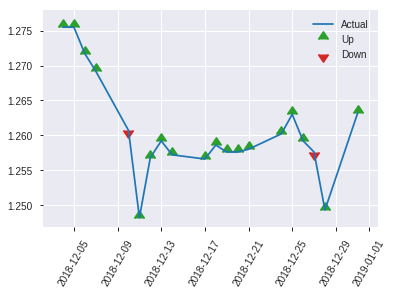


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22330247804453315
RMSE: 0.472548916033603
LogLoss: 0.6336312096019803
Mean Per-Class Error: 0.3432306940371457
AUC: 0.6974584555229717
pr_auc: 0.7003125780522644
Gini: 0.3949169110459434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4706996614747238: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   87   0.7016   (87.0/124.0)
1      10   122  0.0758   (10.0/132.0)
Total  47   209  0.3789   (97.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4707       0.715543  208
max f2                       0.142934     0.850515  247
max f0point5                 0.490627     0.664474  156
max accuracy                 0.490627     0.660156  156
max precision                0.968772     1         0
max recall                   0.142934     1         247
max specificity              0.968772     1         0
max absolute_mcc             0.490627     0.321752  156
max min_per_class_accuracy   0.498151     0.628788  128
max mean_per_class_accuracy  0.490627     0.656769  156

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.909697           1.93939   1.93939            1                0.943862  1                           0.943862            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.850831           1.93939   1.93939            1                0.881142  1                           0.912502            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.788266           1.93939   1.93939            1                0.814634  1                           0.888035            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.766221           1.29293   1.76309            0.666667         0.77702   0.909091                    0.857758            0.0151515       0.0757576                  29.2929   76.3085
    5        0.0507812                   0.757624           1.93939   1.79021            1                0.764794  0.923077                    0.843456            0.0151515       0.0909091                  93.9394   79.021
    6        0.101562                    0.670021           1.04429   1.41725            0.538462         0.707169  0.730769                    0.775313            0.0530303       0.143939                   4.4289    41.7249
    7        0.152344                    0.622888           1.64103   1.49184            0.846154         0.638115  0.769231                    0.72958             0.0833333       0.227273                   64.1026   49.1841
    8        0.203125                    0.594264           1.64103   1.52914            0.846154         0.60416   0.788462                    0.698225            0.0833333       0.310606                   64.1026   52.9138
    9        0.300781                    0.550092           1.31879   1.46084            0.68             0.570231  0.753247                    0.656669            0.128788        0.439394                   31.8788   46.0842
    10       0.402344                    0.519114           0.745921  1.28038            0.384615         0.531579  0.660194                    0.625093            0.0757576       0.515152                   -25.4079  28.0377
    11       0.5                         0.49819            1.08606   1.24242            0.56             0.507908  0.640625                    0.602205            0.106061        0.621212                   8.60606   24.2424
    12       0.601562                    0.49079            1.19347   1.23416            0.615385         0.494362  0.636364                    0.583998            0.121212        0.742424                   19.3473   23.416
    13       0.699219                    0.486952           0.775758  1.17014            0.4              0.488868  0.603352                    0.570712            0.0757576       0.818182                   -22.4242  17.0137
    14       0.800781                    0.475204           0.820513  1.12579            0.423077         0.482649  0.580488                    0.559543            0.0833333       0.901515                   -17.9487  12.5795
    15       0.898438                    0.34089            0.387879  1.04559            0.2              0.425102  0.53913                     0.54493             0.0378788       0.939394                   -61.2121  4.55863
    16       1                           0.0180615          0.596737  1                  0.307692         0.184322  0.515625                    0.508305           

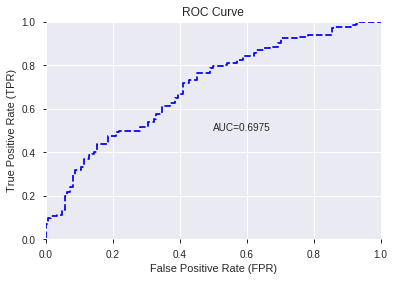

This function is available for GLM models only


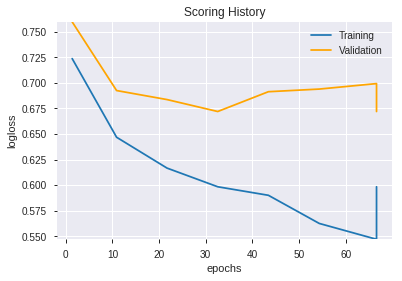

--2019-08-22 12:43:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


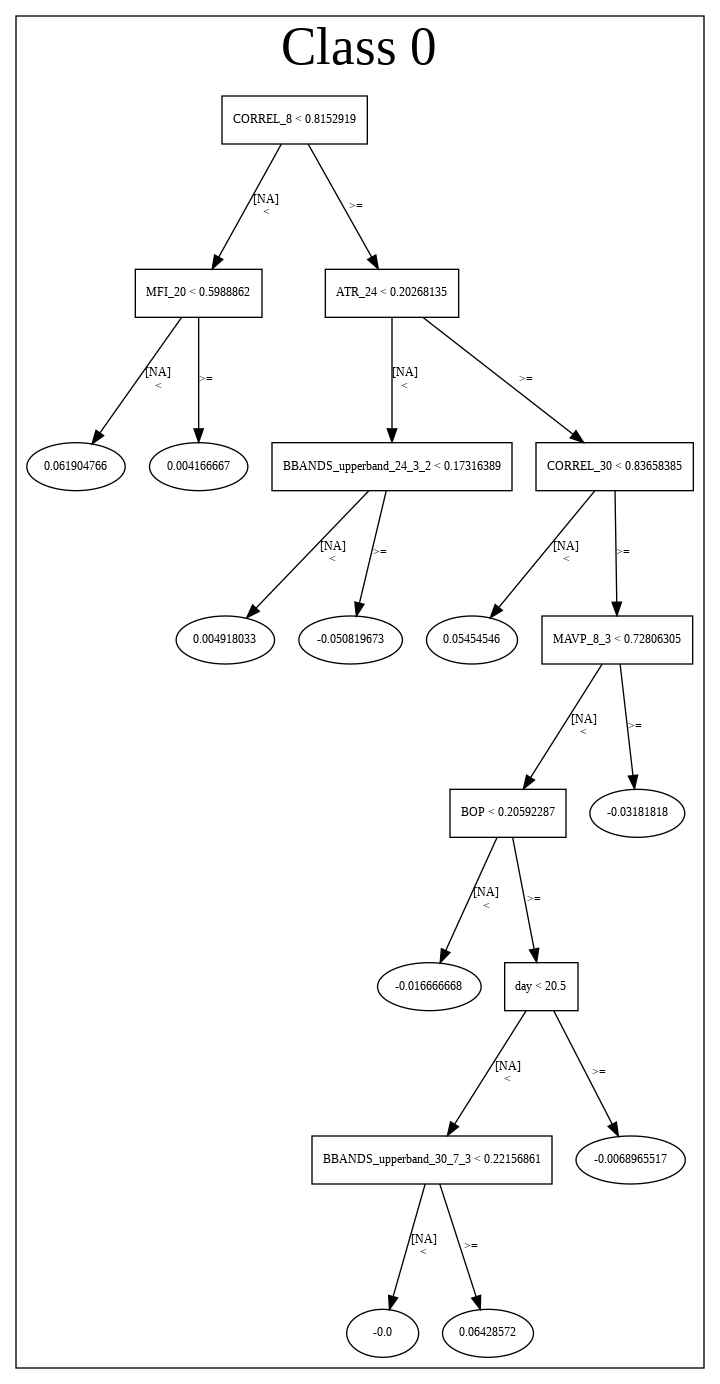

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_123413_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_123413_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'SUB',
 'BOP',
 'ULTOSC',
 'dayofyear',
 'TRANGE',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'VAR_30',
 'VAR_12',
 'CDLINVERTEDHAMMER',
 'STOCHF_fastk',
 'CDLDOJI',
 'CDLGRAVESTONEDOJI',
 'VAR_14',
 'CDLLONGLEGGEDDOJI',
 'VAR_24',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLADVANCEBLOCK',
 'VAR_8',
 'day',
 'CDLLADDERBOTTOM',
 'days_in_month',
 'CORREL_8',
 'WILLR_8',
 'CDLONNECK',
 'weekday_name',
 'CDLMORNINGDOJISTAR',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'VAR_20',
 'CDLHOMINGPIGEON',
 'CDLSPINNINGTOP',
 'CORREL_30',
 'CDLHARAMICROSS',
 'CDLCOUNTERATTACK',
 'CDL3INSIDE',
 'is_quarter_start',
 'is_month_end',
 'is_quarter_end',
 'CDLSHOOTINGSTAR',
 'CDLTASUKIGAP',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLHAMMER',
 'CDLHANGINGMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124406_model_1  0.679008  0.651326              0.431452  0.479161  0.229595

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.209990           1.000000    0.087696
1                  SUB             0.156335           0.744488    0.065289
2       CDLRICKSHAWMAN             0.141611           0.674372    0.059140
3                  DIV             0.118728           0.565399    0.049584
4       STOCHRSI_fastk             0.108978           0.518967    0.045512
5    CDLINVERTEDHAMMER             0.099259           0.472682    0.041452
6    CDLGRAVESTONEDOJI             0.097480           0.464210    0.040710
7               VAR_30             0.092501           0.440501    0.038630
8               TRANGE             0.073411           0.349594    0.030658
9            dayofyear             0.062731           0.298733    0.026198
10        weekday_name             0.061604           0.293364    0.025727
11                 day             0.058708           0.279577    0.024518
12      CDLSPINNINGTOP             0.058650           0.279298    0.024493
13      is_quarter_end             0.055381           0.263733    0.023128
14        STOCHF_fastk             0.051029           0.243009    0.021311
15        is_month_end             0.047978           0.228480    0.020037
16      CDLMORNINGSTAR             0.047837           0.227807    0.019978
17     CDLLADDERBOTTOM             0.044623           0.212499    0.018635
18    CDLCOUNTERATTACK             0.044171           0.210347    0.018447
19           CORREL_30             0.044066           0.209846    0.018403
20              ULTOSC             0.043822           0.208684    0.018301
21              SAREXT             0.038998           0.185713    0.016286
22              VAR_12             0.038415           0.182939    0.016043
23           CDLTAKURI             0.035742           0.170208    0.014927
24        CDLTASUKIGAP             0.034066           0.162227    0.014227
25           CDLONNECK             0.033928           0.161571    0.014169
26             WILLR_8             0.033743           0.160689    0.014092
27   CDLLONGLEGGEDDOJI             0.033604           0.160026    0.014034
28              VAR_20             0.032672           0.155587    0.013644
29  CDLEVENINGDOJISTAR             0.032524           0.154885    0.013583
30     CDLSHOOTINGSTAR             0.031932           0.152064    0.013335
31            CORREL_8             0.030102           0.143349    0.012571
32    is_quarter_start             0.027219           0.129619    0.011367
33               VAR_8             0.026345           0.125456    0.011002
34  CDLMORNINGDOJISTAR             0.026069           0.124145    0.010887
35      CDLEVENINGSTAR             0.024072           0.114632    0.010053
36              VAR_24             0.022287           0.106133    0.009308
37          CDL3INSIDE             0.020675           0.098456    0.008634
38       days_in_month             0.020488           0.097568    0.008556
39    CDLDRAGONFLYDOJI             0.019539           0.093047    0.008160
40     CDLHOMINGPIGEON             0.019434           0.092548    0.008116
41        HT_TRENDMODE             0.018182           0.086586    0.007593
42       CDLHANGINGMAN             0.016572           0.078920    0.006921
43      CDLHARAMICROSS             0.013284           0.063259    0.005548
44              VAR_14             0.011553           0.055016    0.004825
45             CDLDOJI             0.010603           0.050494    0.004428
46           CDLHAMMER             0.009668           0.046042    0.004038
47     CDLADVANCEBLOCK             0.005043           0.024017    0.002106
48      is_month_start             0.004753           0.022634    0.001985
49      CDLMATCHINGLOW             0.004106           0.019553    0.001715

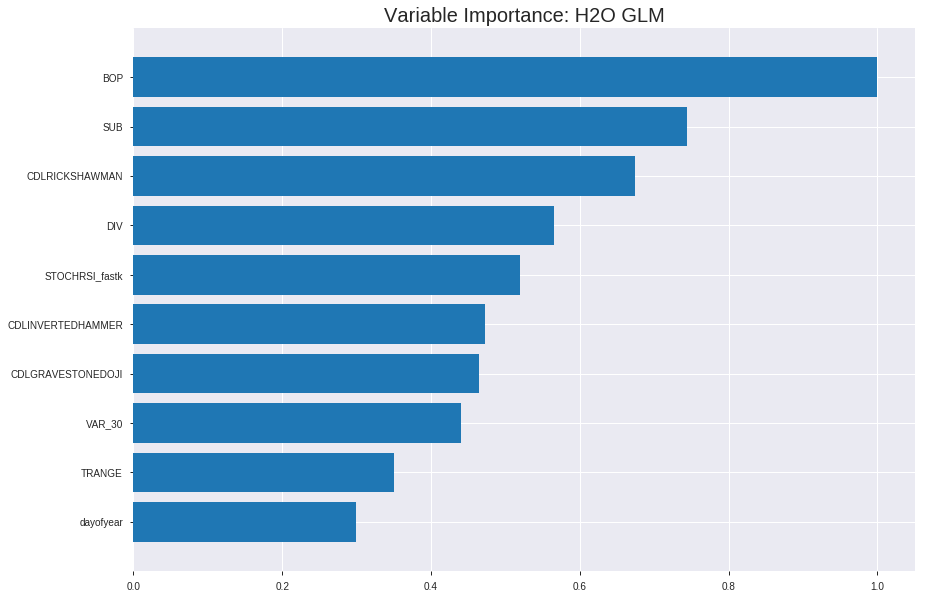

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124406_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22996305414321638
RMSE: 0.47954463206589687
LogLoss: 0.6515057635345608
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.240311645719
Residual deviance: 2328.4815988725204
AIC: 2430.4815988725204
AUC: 0.6650808205313211
pr_auc: 0.6475884814788856
Gini: 0.33016164106264223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3937161910277249: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      224  675   0.7508   (675.0/899.0)
1      60   828   0.0676   (60.0/888.0)
Total  284  1503  0.4113   (735.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393716     0.692597  295
max f2                       0.321888     0.83492   348
max f0point5                 0.435475     0.615066  253
max accuracy                 0.435475     0.613878  253
max precision                0.750381     0.875     14
max recall                   0.199508     1         391
max specificity              0.878895     0.998888  0
max absolute_mcc             0.435475     0.256872  253
max min_per_class_accuracy   0.503015     0.609566  188
max mean_per_class_accuracy  0.435475     0.615241  253

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.748264           1.78879   1.78879            0.888889         0.790615  0.888889                    0.790615            0.018018        0.018018                   78.8789   78.8789
    2        0.0201455                   0.71418            1.34159   1.56519            0.666667         0.729819  0.777778                    0.760217            0.0135135       0.0315315                  34.1592   56.519
    3        0.0302182                   0.691114           1.78879   1.63972            0.888889         0.702481  0.814815                    0.740972            0.018018        0.0495495                  78.8789   63.9723
    4        0.040291                    0.671584           1.67699   1.64904            0.833333         0.681181  0.819444                    0.726024            0.0168919       0.0664414                  67.6989   64.904
    5        0.0503637                   0.663535           1.67699   1.65463            0.833333         0.668112  0.822222                    0.714442            0.0168919       0.0833333                  67.6989   65.463
    6        0.100168                    0.62399            1.35667   1.50648            0.674157         0.642668  0.748603                    0.678755            0.0675676       0.150901                   35.6666   50.648
    7        0.149972                    0.602533           1.33405   1.44922            0.662921         0.612613  0.720149                    0.65679             0.0664414       0.217342                   33.4055   44.9219
    8        0.200336                    0.581846           1.22979   1.39406            0.611111         0.591173  0.692737                    0.640294            0.0619369       0.279279                   22.9792   39.4056
    9        0.299944                    0.552357           1.17578   1.32157            0.58427          0.566267  0.656716                    0.615711            0.117117        0.396396                   17.5777   32.1568
    10       0.400112                    0.525679           1.07927   1.26091            0.536313         0.539146  0.626573                    0.596543            0.108108        0.504505                   7.92692   26.0908
    11       0.50028                     0.502643           1.06803   1.22229            0.530726         0.514336  0.607383                    0.580083            0.106982        0.611486                   6.80268   22.2289
    12       0.599888                    0.474496           0.960972  1.1789             0.477528         0.488394  0.585821                    0.564858            0.0957207       0.707207                   -3.90285  17.8899
    13       0.700056                    0.442023           1.04554   1.15982            0.519553         0.457874  0.576339                    0.549551            0.10473         0.811937                   4.55421   15.9817
    14       0.799664                    0.408217           0.768777  1.11111            0.382022         0.425552  0.552134                    0.534105            0.0765766       0.888514                   -23.1223  11.1108
    15       0.899832                    0.365693           0.697028  1.06501            0.346369         0.388561  0.529229                    0.517903            0.0698198       0.958333                   -30.2972  6.50135
    16       1                           1.61211e-05        0.415968  1                  0.206704         0.308445  0.496922                    0.496922            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23999149976289144
RMSE: 0.48988927296164736
LogLoss: 0.6725759471583628
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.9309586242457
Residual deviance: 686.0274661015302
AIC: 788.0274661015302
AUC: 0.6167915211739913
pr_auc: 0.579951968137969
Gini: 0.23358304234798255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4404318230207826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  159  0.6139   (159.0/259.0)
1      45   206  0.1793   (45.0/251.0)
Total  145  365  0.4      (204.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440432     0.668831  276
max f2                       0.326737     0.830013  391
max f0point5                 0.440432     0.601987  276
max accuracy                 0.440432     0.6       276
max precision                0.685792     0.875     7
max recall                   0.262531     1         398
max specificity              0.763484     0.996139  0
max absolute_mcc             0.440432     0.229215  276
max min_per_class_accuracy   0.496665     0.586873  191
max mean_per_class_accuracy  0.440432     0.603409  276

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.717935           1.69323   1.69323            0.833333         0.740783  0.833333                    0.740783            0.0199203       0.0199203                  69.3227    69.3227
    2        0.0215686                   0.681385           1.6255    1.66244            0.8              0.689324  0.818182                    0.717392            0.0159363       0.0358566                  62.5498    66.2441
    3        0.0313725                   0.663916           0.812749  1.39691            0.4              0.671485  0.6875                      0.703046            0.00796813      0.0438247                  -18.7251   39.6912
    4        0.0411765                   0.650317           0.406375  1.16107            0.2              0.654319  0.571429                    0.691445            0.00398406      0.0478088                  -59.3625   16.107
    5        0.0509804                   0.634182           1.21912   1.17223            0.6              0.644834  0.576923                    0.682481            0.0119522       0.059761                   21.9124    17.2234
    6        0.1                         0.59984            1.13785   1.15538            0.56             0.615448  0.568627                    0.649622            0.0557769       0.115538                   13.7849    15.5378
    7        0.15098                     0.57851            1.56298   1.29301            0.769231         0.588685  0.636364                    0.629046            0.0796813       0.195219                   56.2979    29.301
    8        0.2                         0.56104            0.975299  1.21514            0.48             0.568574  0.598039                    0.614224            0.0478088       0.243028                   -2.47012   21.5139
    9        0.3                         0.53447            1.19522   1.2085             0.588235         0.548731  0.594771                    0.592393            0.119522        0.36255                    19.5219    20.8499
    10       0.4                         0.512747           1.03586   1.16534            0.509804         0.524766  0.573529                    0.575486            0.103586        0.466135                   3.58566    16.5339
    11       0.5                         0.496428           1.23506   1.17928            0.607843         0.505333  0.580392                    0.561455            0.123506        0.589641                   23.506     17.9283
    12       0.6                         0.469637           0.996016  1.14874            0.490196         0.485338  0.565359                    0.548769            0.0996016       0.689243                   -0.398406  14.8738
    13       0.7                         0.444582           1.03586   1.13261            0.509804         0.455887  0.557423                    0.5355              0.103586        0.792829                   3.58566    13.2612
    14       0.8                         0.416853           0.756972  1.08566            0.372549         0.431513  0.534314                    0.522502            0.0756972       0.868526                   -24.3028   8.56574
    15       0.9                         0.384418           0.63745   1.03586            0.313725         0.399176  0.509804                    0.508799            0.063745        0.932271                   -36.255    3.58566
    16       1                           0.0340871          0.677291  1                  0.333333         0.346224  0.492157                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:44:06  0.000 sec   2            6.8       51            1.37854           1.38068
    2019-08-22 12:44:06  0.024 sec   4            4.2       51            1.37455           1.37787
    2019-08-22 12:44:06  0.045 sec   6            2.6       51            1.36897           1.37399
    2019-08-22 12:44:07  0.066 sec   8            1.6       51            1.3616            1.36899
    2019-08-22 12:44:07  0.087 sec   10           1         51            1.35246           1.3631
    2019-08-22 12:44:07  0.108 sec   12           0.63      51            1.34195           1.35693
    2019-08-22 12:44:07  0.128 sec   14           0.39      51            1.33083           1.35135
    2019-08-22 12:44:07  0.148 sec   16           0.24      51            1.32013           1.34725
    2019-08-22 12:44:07  0.164 sec   18           0.15      51            1.3107            1.34517
    2019-08-22 12:44:07  0.179 sec   20           0.093     51            1.30301           1.34515
    2019-08-22 12:44:07  0.194 sec   22           0.058     51            1.29702           1.34676
    2019-08-22 12:44:07  0.207 sec   24           0.036     51            1.29237           1.34942
    2019-08-22 12:44:07  0.223 sec   26           0.022     51            1.28871           1.35263
    2019-08-22 12:44:07  0.247 sec   28           0.014     51            1.2858            1.3561
    2019-08-22 12:44:07  0.268 sec   30           0.0086    51            1.28356           1.35965

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6484375)

('F1', 0.711590296495957)

('auc', 0.6790078201368525)

('logloss', 0.6513258111693099)

('mean_per_class_error', 0.34872922776148585)

('rmse', 0.47916071651616876)

('mse', 0.22959499225228824)

glm prediction progress: |████████████████████████████████████████████████| 100%


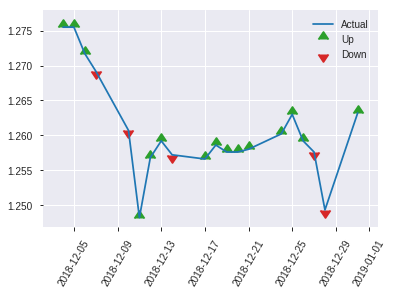


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22959499225228824
RMSE: 0.47916071651616876
LogLoss: 0.6513258111693099
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.999547062732
Residual deviance: 333.47881531868666
AIC: 435.47881531868666
AUC: 0.6790078201368525
pr_auc: 0.67370085409221
Gini: 0.3580156402737049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37734999644966316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   107  0.8629   (107.0/124.0)
1      0    132  0        (0.0/132.0)
Total  17   239  0.418    (107.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37735      0.71159   238
max f2                       0.37735      0.860495  238
max f0point5                 0.53589      0.665468  105
max accuracy                 0.53589      0.648438  105
max precision                0.728047     1         0
max recall                   0.37735      1         238
max specificity              0.728047     1         0
max absolute_mcc             0.53589      0.306962  105
max min_per_class_accuracy   0.517161     0.621212  127
max mean_per_class_accuracy  0.53589      0.651271  105

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.680918           1.93939   1.93939            1                0.702102  1                           0.702102            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.672282           0.646465  1.29293            0.333333         0.676649  0.666667                    0.689375            0.00757576      0.030303                   -35.3535  29.2929
    3        0.03125                     0.664466           1.93939   1.45455            1                0.669765  0.75                        0.684473            0.0151515       0.0454545                  93.9394   45.4545
    4        0.0429688                   0.655617           1.29293   1.41047            0.666667         0.658351  0.727273                    0.677349            0.0151515       0.0606061                  29.2929   41.0468
    5        0.0507812                   0.652871           1.93939   1.49184            1                0.653433  0.769231                    0.673669            0.0151515       0.0757576                  93.9394   49.1841
    6        0.101562                    0.61921            1.49184   1.49184            0.769231         0.630507  0.769231                    0.652088            0.0757576       0.151515                   49.1841   49.1841
    7        0.152344                    0.601402           1.49184   1.49184            0.769231         0.61096   0.769231                    0.638379            0.0757576       0.227273                   49.1841   49.1841
    8        0.203125                    0.586296           1.19347   1.41725            0.615385         0.593881  0.730769                    0.627254            0.0606061       0.287879                   19.3473   41.7249
    9        0.300781                    0.560591           1.24121   1.36009            0.64             0.572994  0.701299                    0.609637            0.121212        0.409091                   24.1212   36.0094
    10       0.402344                    0.538108           1.34266   1.35569            0.692308         0.548571  0.699029                    0.594222            0.136364        0.545455                   34.2657   35.5693
    11       0.5                         0.514315           0.775758  1.24242            0.4              0.527425  0.640625                    0.581176            0.0757576       0.621212                   -22.4242  24.2424
    12       0.601562                    0.495393           0.820513  1.17119            0.423077         0.502826  0.603896                    0.567948            0.0833333       0.704545                   -17.9487  17.1192
    13       0.699219                    0.465903           0.930909  1.13763            0.48             0.481054  0.586592                    0.555812            0.0909091       0.795455                   -6.90909  13.7633
    14       0.800781                    0.43439            0.969697  1.11633            0.5              0.449361  0.57561                     0.542311            0.0984848       0.893939                   -3.0303   11.6334
    15       0.898438                    0.392131           0.698182  1.07088            0.36             0.4121    0.552174                    0.528157            0.0681818       0.962121                   -30.1818  7.08827
    16       1                           0.256802           0.37296   1                  0.192308         0.362101  0.515625                    0.511292         

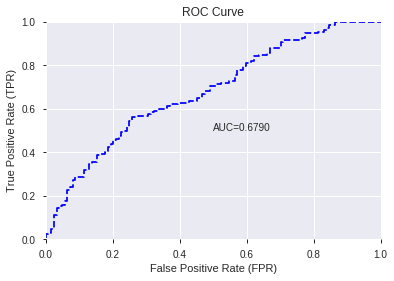

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


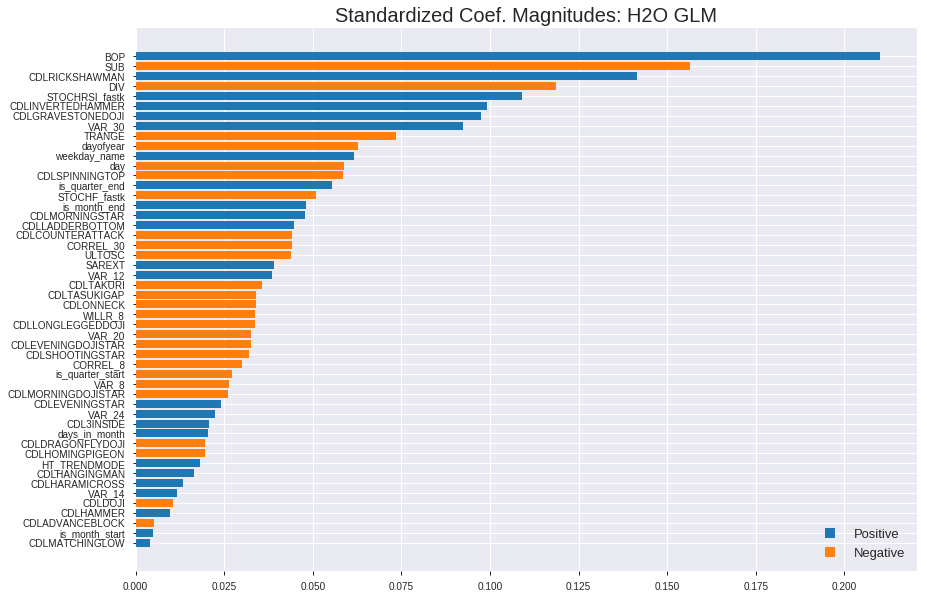

'log_likelihood'
--2019-08-22 12:44:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.89.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.89.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


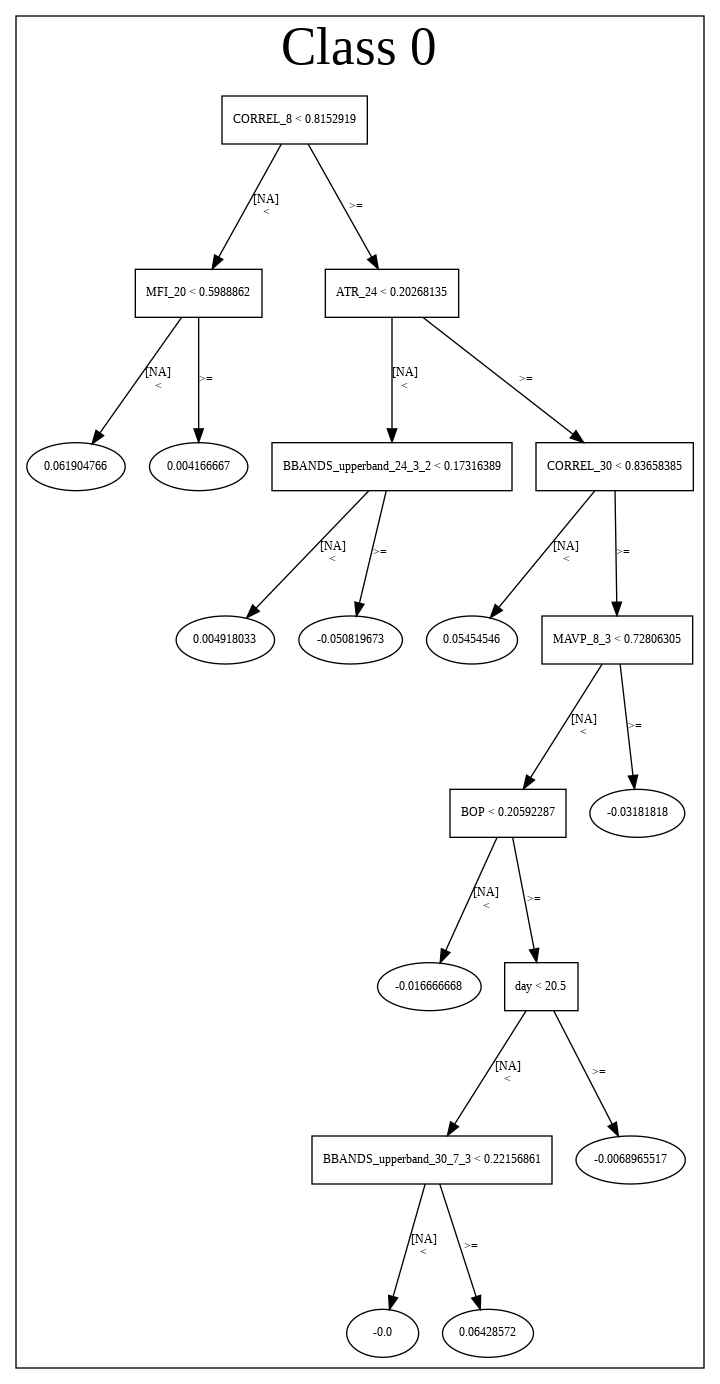

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124406_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124406_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SUB',
 'CDLRICKSHAWMAN',
 'DIV',
 'STOCHRSI_fastk',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'VAR_30',
 'TRANGE',
 'dayofyear',
 'weekday_name',
 'day',
 'CDLSPINNINGTOP',
 'is_quarter_end',
 'STOCHF_fastk',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLCOUNTERATTACK',
 'CORREL_30',
 'ULTOSC',
 'SAREXT',
 'VAR_12',
 'CDLTAKURI',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'WILLR_8',
 'CDLLONGLEGGEDDOJI',
 'VAR_20',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CORREL_8',
 'is_quarter_start',
 'VAR_8',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'VAR_24',
 'CDL3INSIDE',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'VAR_14',
 'CDLDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMATCHINGLOW']

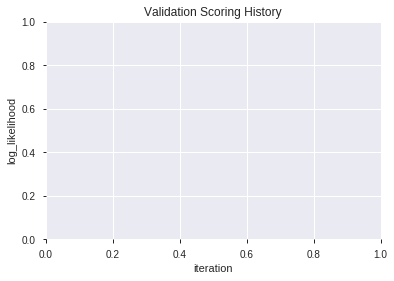

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_124418  0.693793  0.642549              0.451613  0.474948  0.225576
1  XGBoost_grid_1_AutoML_20190822_124418_model_2  0.674731  0.649573              0.401515  0.478409  0.228875
2  XGBoost_grid_1_AutoML_20190822_124418_model_4  0.673937  0.652821              0.422654  0.480160  0.230553
3               XGBoost_3_AutoML_20190822_124418  0.658297  0.653907              0.417644  0.480820  0.231188
4  XGBoost_grid_1_AutoML_20190822_124418_model_5  0.652004  0.654513              0.459433  0.481868  0.232197
5  XGBoost_grid_1_AutoML_20190822_124418_model_1  0.651393  0.655649              0.467498  0.481803  0.232134
6  XGBoost_grid_1_AutoML_20190822_124418_model_7  0.631415  0.664071              0.438050  0.485793  0.235995
7  XGBoost_grid_1_AutoML_20190822_124418_model_3  0.622251  0.672532              0.479594  0.489826  0.239930
8               XGBoost_2_AutoML_20190822_124418  0.618707  0.669541              0.447092  0.488516  0.238648
9  XGBoost_grid_1_AutoML_20190822_124418_model_6  0.613392  0.667315              0.442082  0.487600  0.237753

variable  relative_importance  scaled_importance  percentage
0                 BOP           636.654846           1.000000    0.087289
1                 DIV           490.046753           0.769721    0.067188
2              ULTOSC           436.894379           0.686234    0.059901
3              SAREXT           405.734711           0.637291    0.055629
4           dayofyear           405.530273           0.636970    0.055601
5              VAR_14           388.643799           0.610447    0.053285
6              VAR_30           383.246918           0.601970    0.052545
7              TRANGE           357.494507           0.561520    0.049015
8               VAR_8           357.385071           0.561348    0.049000
9            CORREL_8           346.723206           0.544602    0.047538
10                SUB           340.163879           0.534299    0.046639
11          CORREL_30           331.717407           0.521032    0.045480
12             VAR_20           312.894440           0.491466    0.042900
13             VAR_12           291.660553           0.458114    0.039988
14                day           260.417145           0.409040    0.035705
15       STOCHF_fastk           252.736664           0.396976    0.034652
16     STOCHRSI_fastk           250.620651           0.393652    0.034362
17            WILLR_8           234.394638           0.368166    0.032137
18             VAR_24           227.372009           0.357135    0.031174
19       weekday_name           137.428070           0.215860    0.018842
20     CDLRICKSHAWMAN            99.026840           0.155542    0.013577
21     CDLSPINNINGTOP            77.395157           0.121565    0.010611
22  CDLGRAVESTONEDOJI            76.117157           0.119558    0.010436
23      days_in_month            51.162468           0.080361    0.007015
24  CDLINVERTEDHAMMER            45.118328           0.070868    0.006186
25       HT_TRENDMODE            34.039742           0.053467    0.004667
26   CDLDRAGONFLYDOJI            20.391161           0.032029    0.002796
27  CDLLONGLEGGEDDOJI            18.317484           0.028771    0.002511
28            CDLDOJI            15.688972           0.024643    0.002151
29          CDLTAKURI             8.607594           0.013520    0.001180

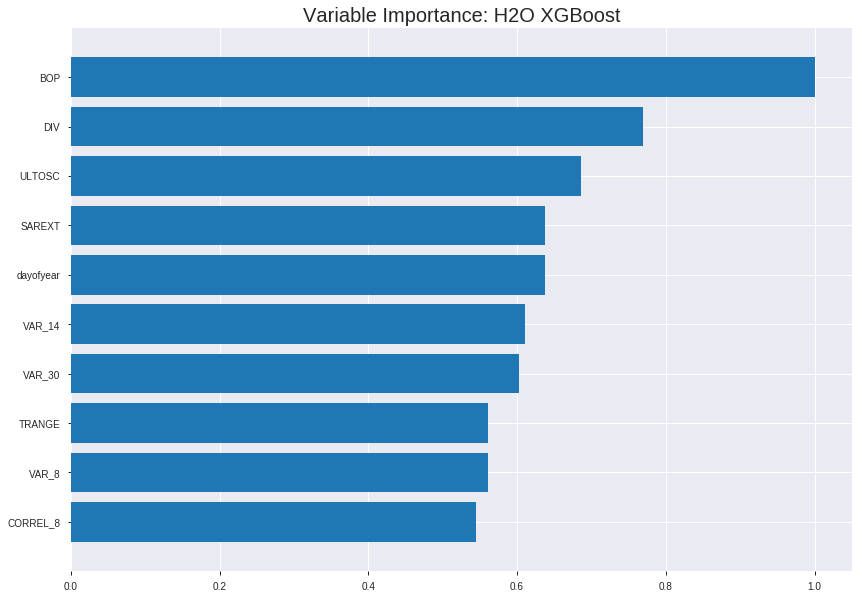

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_124418


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15342149011633013
RMSE: 0.3916905540300023
LogLoss: 0.4883278199279391
Mean Per-Class Error: 0.13484389561975774
AUC: 0.9383768501538245
pr_auc: 0.9407997387119026
Gini: 0.8767537003076491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4965781271457672: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  143  0.1591   (143.0/899.0)
1      100  788  0.1126   (100.0/888.0)
Total  856  931  0.136    (243.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496578     0.86641   199
max f2                       0.415726     0.903056  252
max f0point5                 0.560167     0.886076  157
max accuracy                 0.513012     0.865137  187
max precision                0.869225     1         0
max recall                   0.263514     1         346
max specificity              0.869225     1         0
max absolute_mcc             0.507449     0.730299  191
max min_per_class_accuracy   0.509274     0.862613  190
max mean_per_class_accuracy  0.507449     0.865156  191

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.792356           2.01239    2.01239            1                0.8112    1                           0.8112              0.0202703       0.0202703                  101.239   101.239
    2        0.0201455                   0.771446           2.01239    2.01239            1                0.782666  1                           0.796933            0.0202703       0.0405405                  101.239   101.239
    3        0.0302182                   0.762268           2.01239    2.01239            1                0.766594  1                           0.78682             0.0202703       0.0608108                  101.239   101.239
    4        0.040291                    0.750208           2.01239    2.01239            1                0.756566  1                           0.779257            0.0202703       0.0810811                  101.239   101.239
    5        0.0503637                   0.741153           2.01239    2.01239            1                0.744917  1                           0.772389            0.0202703       0.101351                   101.239   101.239
    6        0.100168                    0.705008           2.01239    2.01239            1                0.721961  1                           0.747316            0.100225        0.201577                   101.239   101.239
    7        0.149972                    0.681664           1.98978    2.00488            0.988764         0.692921  0.996269                    0.729252            0.0990991       0.300676                   98.9776   100.488
    8        0.200336                    0.661691           1.92295    1.98428            0.955556         0.672296  0.986034                    0.714933            0.0968468       0.397523                   92.2948   98.4281
    9        0.299944                    0.613074           1.88803    1.95232            0.938202         0.635658  0.970149                    0.688607            0.188063        0.585586                   88.8026   95.2316
    10       0.400112                    0.562695           1.59642    1.86322            0.793296         0.58726   0.925874                    0.663235            0.15991         0.745495                   59.6419   86.3217
    11       0.50028                     0.507146           1.22542    1.73552            0.608939         0.534739  0.862416                    0.637507            0.122748        0.868243                   22.542    73.5515
    12       0.599888                    0.452034           0.644416   1.55434            0.320225         0.479954  0.772388                    0.611346            0.0641892       0.932432                   -35.5584  55.4344
    13       0.700056                    0.395896           0.393484   1.38824            0.195531         0.424005  0.689848                    0.58454             0.0394144       0.971847                   -60.6516  38.8242
    14       0.799664                    0.331782           0.214805   1.24208            0.106742         0.364021  0.617215                    0.557072            0.0213964       0.993243                   -78.5195  24.2075
    15       0.899832                    0.265005           0.0562119  1.11007            0.027933         0.298713  0.551617                    0.528312            0.00563063      0.998874                   -94.3788  11.0067
    16       1                           0.113735           0.0112424  1                  0.00558659       0.210065  0.496922                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24450667507986604
RMSE: 0.4944761622968958
LogLoss: 0.6829572262426036
Mean Per-Class Error: 0.4097125013459675
AUC: 0.6008014274946546
pr_auc: 0.5588567854666501
Gini: 0.2016028549893092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28133663535118103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   241  0.9305   (241.0/259.0)
1      5    246  0.0199   (5.0/251.0)
Total  23   487  0.4824   (246.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281337     0.666667  377
max f2                       0.198941     0.831677  395
max f0point5                 0.471138     0.589577  241
max accuracy                 0.471138     0.588235  241
max precision                0.635124     0.634146  70
max recall                   0.198941     1         395
max specificity              0.800157     0.996139  0
max absolute_mcc             0.471138     0.186922  241
max min_per_class_accuracy   0.525725     0.563707  190
max mean_per_class_accuracy  0.471138     0.590287  241

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.759339           0.338645  0.338645           0.166667         0.784019  0.166667                    0.784019            0.00398406      0.00398406                 -66.1355  -66.1355
    2        0.0215686                   0.724032           1.6255    0.923578           0.8              0.735293  0.454545                    0.761871            0.0159363       0.0199203                  62.5498   -7.64216
    3        0.0313725                   0.711399           1.6255    1.14293            0.8              0.717868  0.5625                      0.74812             0.0159363       0.0358566                  62.5498   14.2928
    4        0.0411765                   0.705507           1.6255    1.25783            0.8              0.709384  0.619048                    0.738897            0.0159363       0.0517928                  62.5498   25.7826
    5        0.0509804                   0.692078           0.406375  1.09409            0.2              0.697888  0.538462                    0.731011            0.00398406      0.0557769                  -59.3625  9.40852
    6        0.1                         0.666128           1.38167   1.23506            0.68             0.677864  0.607843                    0.704958            0.0677291       0.123506                   38.1673   23.506
    7        0.15098                     0.641174           1.25038   1.24023            0.615385         0.653055  0.61039                     0.687432            0.063745        0.187251                   25.0383   24.0234
    8        0.2                         0.618493           1.05657   1.19522            0.52             0.62839   0.588235                    0.672961            0.0517928       0.239044                   5.65737   19.5219
    9        0.3                         0.587826           1.15538   1.18194            0.568627         0.602992  0.581699                    0.649638            0.115538        0.354582                   15.5378   18.1939
    10       0.4                         0.55256            1.15538   1.1753             0.568627         0.570287  0.578431                    0.6298              0.115538        0.47012                    15.5378   17.5299
    11       0.5                         0.524998           0.956175  1.13147            0.470588         0.537903  0.556863                    0.611421            0.0956175       0.565737                   -4.38247  13.1474
    12       0.6                         0.483097           1.19522   1.1421             0.588235         0.504269  0.562092                    0.593562            0.119522        0.685259                   19.5219   14.2098
    13       0.7                         0.443822           0.916335  1.10985            0.45098          0.464124  0.546218                    0.575071            0.0916335       0.776892                   -8.36653  10.9846
    14       0.8                         0.392743           0.876494  1.08068            0.431373         0.42003   0.531863                    0.555691            0.0876494       0.864542                   -12.3506  8.06773
    15       0.9                         0.321723           0.557769  1.02258            0.27451          0.361071  0.503268                    0.534066            0.0557769       0.920319                   -44.2231  2.25764
    16       1                           0.171398           0.796813  1                  0.392157         0.271247  0.492157                    0.507785        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:44:18  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.503078                         0.5                0.693147              0.5               0                    1                  0.507843
    2019-08-22 12:44:19  0.095 sec   5                  0.482108         0.657878            0.815571        0.801643           2.01239          0.272524                         0.49541            0.68398               0.600832          0.554577             0.580535           0.478431
    2019-08-22 12:44:19  0.164 sec   10                 0.466156         0.627087            0.85627         0.847241           2.01239          0.229994                         0.493133           0.679371              0.600109          0.551587             0.677291           0.468627
    2019-08-22 12:44:19  0.232 sec   15                 0.453972         0.60385             0.870128        0.864009           2.01239          0.22272                          0.492886           0.67886               0.597179          0.54659              0.338645           0.480392
    2019-08-22 12:44:19  0.300 sec   20                 0.442444         0.581995            0.885259        0.879217           2.01239          0.209289                         0.494239           0.681626              0.587849          0.538197             0.338645           0.478431
    2019-08-22 12:44:19  0.365 sec   25                 0.433094         0.564384            0.897008        0.897763           2.01239          0.199217                         0.49492            0.683012              0.585434          0.543606             0.677291           0.492157
    2019-08-22 12:44:19  0.432 sec   30                 0.423771         0.546868            0.903749        0.902498           2.01239          0.189144                         0.494231           0.681759              0.59238           0.54901              1.01594            0.492157
    2019-08-22 12:44:19  0.501 sec   35                 0.41469          0.530117            0.914272        0.91648            2.01239          0.172356                         0.493939           0.681363              0.595079          0.549672             0.677291           0.490196
    2019-08-22 12:44:19  0.581 sec   40                 0.406217         0.514683            0.924356        0.927659           2.01239          0.161164                         0.493348           0.680288              0.601317          0.555795             0.338645           0.480392
    2019-08-22 12:44:19  0.652 sec   45                 0.399025         0.501586            0.931531        0.934555           2.01239          0.142138                         0.494779           0.683426              0.596487          0.551479             0.338645           0.476471
    2019-08-22 12:44:19  0.723 sec   50                 0.391691         0.488328            0.938377        0.9408             2.01239          0.135982                         0.494476           0.682957              0.600801          0.558857             0.338645           0.482353

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                636.6548461914062      1.0                   0.08728922336400802
DIV                490.0467529296875      0.7697212325661903    0.06718836859748974
ULTOSC             436.8943786621094      0.6862342779226405    0.05990085716562812
SAREXT             405.7347106933594      0.6372914823794145    0.05562867855339648
dayofyear          405.5302734375         0.6369703707801195    0.05560064897128086
---                ---                    ---                   ---
HT_TRENDMODE       34.03974151611328      0.05346655526105812   0.00466705408468658
CDLDRAGONFLYDOJI   20.39116096496582      0.032028596164703264  0.0027957512846563935
CDLLONGLEGGEDDOJI  18.31748390197754      0.02877145129979974   0.0025114376390148983
CDLDOJI            15.688972473144531     0.024642822664429607  0.002151052851875035
CDLTAKURI          8.60759449005127       0.013520032937067208  0.001180153174932405


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66015625)

('F1', 0.7021276595744682)

('auc', 0.6937927663734116)

('logloss', 0.6425491578216956)

('mean_per_class_error', 0.3351661779081134)

('rmse', 0.4749482322748231)

('mse', 0.22557582334097928)

xgboost prediction progress: |████████████████████████████████████████████| 100%


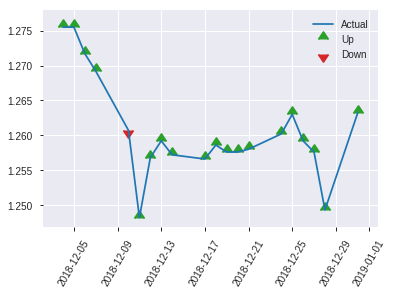


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22557582334097928
RMSE: 0.4749482322748231
LogLoss: 0.6425491578216956
Mean Per-Class Error: 0.3351661779081134
AUC: 0.6937927663734116
pr_auc: 0.6836437240285722
Gini: 0.38758553274682317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2814275324344635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   112  0.9032   (112.0/124.0)
1      0    132  0        (0.0/132.0)
Total  12   244  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281428     0.702128  243
max f2                       0.281428     0.854922  243
max f0point5                 0.579302     0.685841  79
max accuracy                 0.568806     0.660156  90
max precision                0.648435     0.833333  29
max recall                   0.281428     1         243
max specificity              0.800551     0.991935  0
max absolute_mcc             0.579302     0.349912  79
max min_per_class_accuracy   0.535227     0.613636  123
max mean_per_class_accuracy  0.568806     0.664834  90

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.726371           0.646465  0.646465           0.333333         0.759234  0.333333                    0.759234            0.00757576      0.00757576                 -35.3535  -35.3535
    2        0.0234375                   0.710035           1.29293   0.969697           0.666667         0.717089  0.5                         0.738162            0.0151515       0.0227273                  29.2929   -3.0303
    3        0.03125                     0.701843           1.93939   1.21212            1                0.703227  0.625                       0.729428            0.0151515       0.0378788                  93.9394   21.2121
    4        0.0429688                   0.693711           1.93939   1.41047            1                0.698594  0.727273                    0.721019            0.0227273       0.0606061                  93.9394   41.0468
    5        0.0507812                   0.682941           0.969697  1.34266            0.5              0.687747  0.692308                    0.7159              0.00757576      0.0681818                  -3.0303   34.2657
    6        0.101562                    0.656634           1.79021   1.56643            0.923077         0.67165   0.807692                    0.693775            0.0909091       0.159091                   79.021    56.6434
    7        0.152344                    0.630118           1.49184   1.54157            0.769231         0.641522  0.794872                    0.676357            0.0757576       0.234848                   49.1841   54.157
    8        0.203125                    0.615344           1.49184   1.52914            0.769231         0.62196   0.788462                    0.662758            0.0757576       0.310606                   49.1841   52.9138
    9        0.300781                    0.583626           1.39636   1.48603            0.72             0.598306  0.766234                    0.641832            0.136364        0.44697                    39.6364   48.6029
    10       0.402344                    0.555924           0.969697  1.35569            0.5              0.569616  0.699029                    0.623603            0.0984848       0.545455                   -3.0303   35.5693
    11       0.5                         0.531424           0.698182  1.22727            0.36             0.543467  0.632812                    0.607951            0.0681818       0.613636                   -30.1818  22.7273
    12       0.601562                    0.501238           1.19347   1.22157            0.615385         0.515613  0.62987                     0.592362            0.121212        0.734848                   19.3473   22.1566
    13       0.699219                    0.463385           0.698182  1.14847            0.36             0.482979  0.592179                    0.577085            0.0681818       0.80303                    -30.1818  14.8468
    14       0.800781                    0.401912           0.671329  1.08795            0.346154         0.427613  0.560976                    0.558127            0.0681818       0.871212                   -32.8671  8.79527
    15       0.898438                    0.335928           0.698182  1.04559            0.36             0.376454  0.53913                     0.53838             0.0681818       0.939394                   -30.1818  4.55863
    16       1                           0.158968           0.596737  1                  0.307692         0.276184  0.515625                    0.511751         

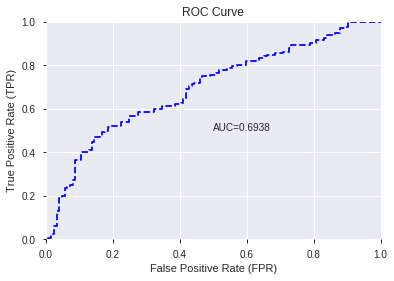

This function is available for GLM models only


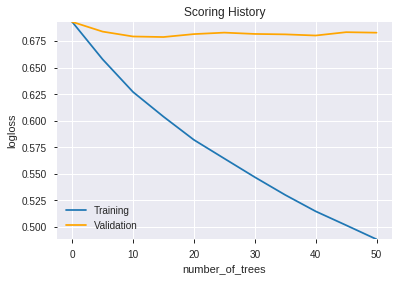

--2019-08-22 12:44:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

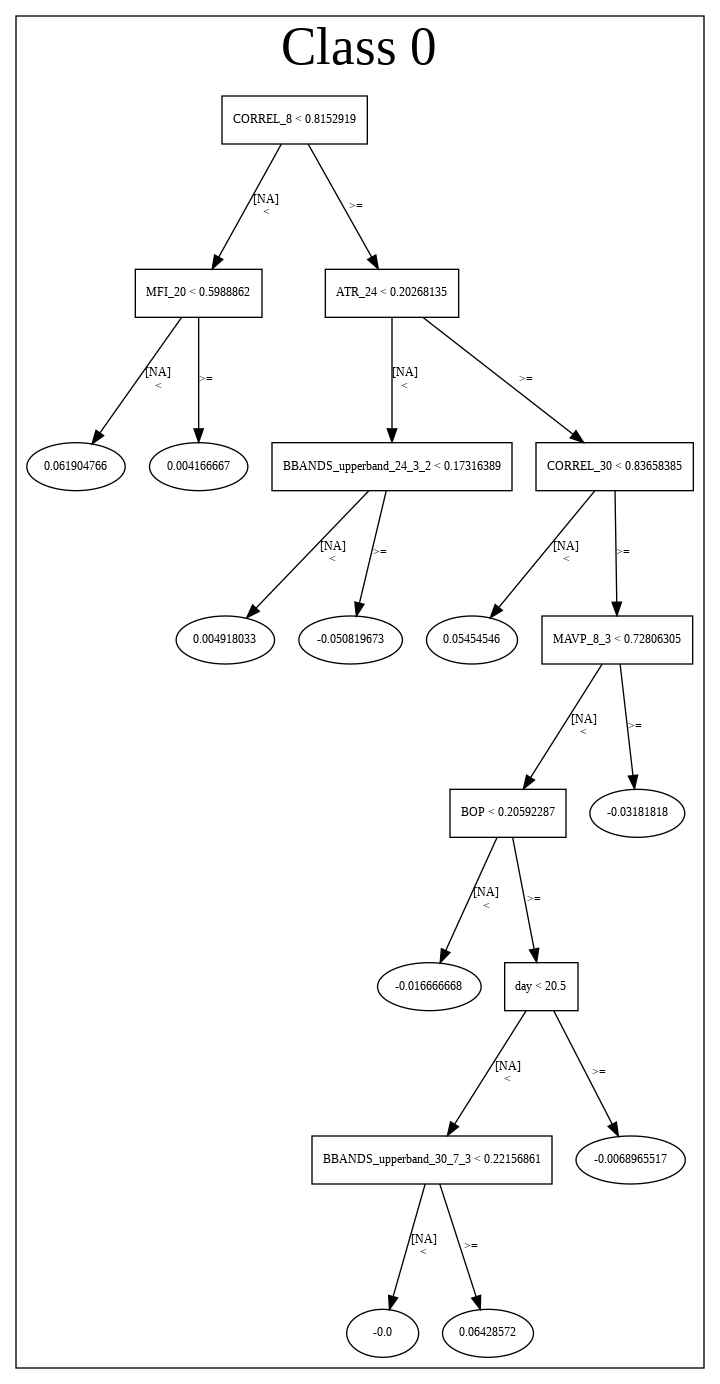

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_124418',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_124418',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_b408',
   'type

['BOP',
 'DIV',
 'ULTOSC',
 'SAREXT',
 'dayofyear',
 'VAR_14',
 'VAR_30',
 'TRANGE',
 'VAR_8',
 'CORREL_8',
 'SUB',
 'CORREL_30',
 'VAR_20',
 'VAR_12',
 'day',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'VAR_24',
 'weekday_name',
 'CDLRICKSHAWMAN',
 'CDLSPINNINGTOP',
 'CDLGRAVESTONEDOJI',
 'days_in_month',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLTAKURI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124440_model_1  0.693121  0.650511              0.351173  0.478554  0.229014

variable  relative_importance  scaled_importance    percentage
0                          BOP         1.208112e-01           1.000000  2.521530e-02
1                          SUB         8.888769e-02           0.735757  1.855234e-02
2               CDLRICKSHAWMAN         8.257893e-02           0.683537  1.723560e-02
3                          DIV         7.164665e-02           0.593047  1.495385e-02
4            CDLINVERTEDHAMMER         6.868878e-02           0.568563  1.433649e-02
...                        ...                  ...                ...           ...
1014                 MAVP_12_0         8.023223e-06           0.000066  1.674580e-06
1015  BBANDS_middleband_24_2_5         3.951478e-06           0.000033  8.247392e-07
1016                 MAVP_20_1         3.851964e-06           0.000032  8.039689e-07
1017  BBANDS_middleband_24_2_4         2.624070e-06           0.000022  5.476869e-07
1018   BBANDS_lowerband_14_6_5         6.077191e-07           0.000005  1.268411e-07

[1019 rows x 4 columns]

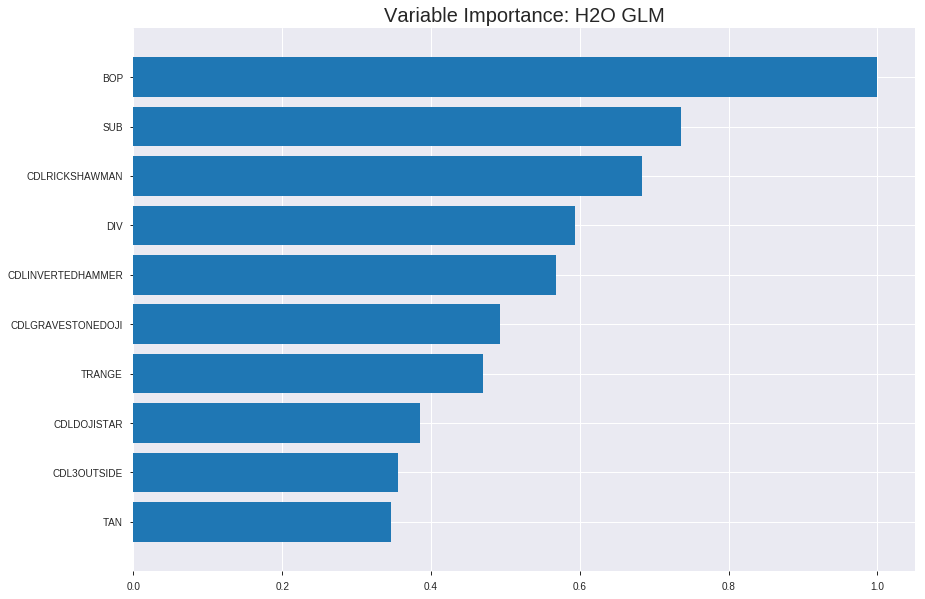

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124440_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22741560818450518
RMSE: 0.47688112584218006
LogLoss: 0.6464189263539296
Null degrees of freedom: 1786
Residual degrees of freedom: 767
Null deviance: 2477.240311645719
Residual deviance: 2310.3012427889444
AIC: 4350.301242788944
AUC: 0.6898292898014812
pr_auc: 0.6800431140667933
Gini: 0.37965857960296234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41236191498658864: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      234  665   0.7397   (665.0/899.0)
1      65   823   0.0732   (65.0/888.0)
Total  299  1488  0.4085   (730.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412362     0.692761  292
max f2                       0.322722     0.837597  361
max f0point5                 0.504175     0.631944  187
max accuracy                 0.504175     0.634024  187
max precision                0.899068     1         0
max recall                   0.237729     1         392
max specificity              0.899068     1         0
max absolute_mcc             0.529984     0.270793  158
max min_per_class_accuracy   0.500048     0.630701  193
max mean_per_class_accuracy  0.497162     0.634085  196

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.722698           1.67699   1.67699            0.833333         0.770945  0.833333                    0.770945            0.0168919       0.0168919                  67.6989   67.6989
    2        0.0201455                   0.687119           1.78879   1.73289            0.888889         0.703296  0.861111                    0.73712             0.018018        0.0349099                  78.8789   73.2889
    3        0.0302182                   0.661261           1.78879   1.75152            0.888889         0.675064  0.87037                     0.716435            0.018018        0.0529279                  78.8789   75.1522
    4        0.040291                    0.644997           1.67699   1.73289            0.833333         0.653548  0.861111                    0.700713            0.0168919       0.0698198                  67.6989   73.2889
    5        0.0503637                   0.636727           1.45339   1.67699            0.722222         0.640283  0.833333                    0.688627            0.0146396       0.0844595                  45.3391   67.6989
    6        0.100168                    0.608334           1.58278   1.63015            0.786517         0.621721  0.810056                    0.655361            0.0788288       0.163288                   58.2777   63.0146
    7        0.149972                    0.590252           1.31144   1.52431            0.651685         0.59854   0.757463                    0.636491            0.0653153       0.228604                   31.1443   52.4308
    8        0.200336                    0.570776           1.38631   1.48962            0.688889         0.579667  0.740223                    0.622206            0.0698198       0.298423                   38.6311   48.9616
    9        0.299944                    0.545099           1.2323    1.40417            0.61236          0.55646   0.697761                    0.600372            0.122748        0.421171                   23.2305   40.4166
    10       0.400112                    0.521995           1.09051   1.32564            0.541899         0.533129  0.658741                    0.583538            0.109234        0.530405                   9.05116   32.5643
    11       0.50028                     0.499749           1.02306   1.26506            0.50838          0.510385  0.628635                    0.568891            0.102477        0.632883                   2.30573   26.5058
    12       0.599888                    0.476511           0.949666  1.21269            0.47191          0.48796   0.602612                    0.555453            0.0945946       0.727477                   -5.0334   21.2689
    13       0.700056                    0.453851           0.865664  1.16303            0.430168         0.464189  0.577938                    0.542394            0.0867117       0.814189                   -13.4336  16.3034
    14       0.799664                    0.423677           0.859222  1.12519            0.426966         0.439504  0.559132                    0.529578            0.0855856       0.899775                   -14.0778  12.5191
    15       0.899832                    0.382093           0.607089  1.06752            0.301676         0.404642  0.530473                    0.51567             0.0608108       0.960586                   -39.2911  6.75164
    16       1                           3.98837e-05        0.393484  1                  0.195531         0.328505  0.496922                    0.496922         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2405035327451791
RMSE: 0.49041159523932454
LogLoss: 0.6740478013638014
Null degrees of freedom: 509
Residual degrees of freedom: -510
Null deviance: 706.9309586242457
Residual deviance: 687.5287573910774
AIC: 2727.5287573910773
AUC: 0.6220754049439309
pr_auc: 0.5712929011725357
Gini: 0.24415080988786175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46805684241284806: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      91   168  0.6486   (168.0/259.0)
1      34   217  0.1355   (34.0/251.0)
Total  125  385  0.3961   (202.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468057     0.68239   292
max f2                       0.365588     0.831108  383
max f0point5                 0.481652     0.613179  265
max accuracy                 0.481652     0.615686  265
max precision                0.669054     0.705882  15
max recall                   0.200168     1         398
max specificity              0.788961     0.996139  0
max absolute_mcc             0.481652     0.25418   265
max min_per_class_accuracy   0.520853     0.579151  194
max mean_per_class_accuracy  0.481652     0.618545  265

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.711348           1.01594   1.01594            0.5              0.726388  0.5                         0.726388            0.0119522       0.0119522                  1.59363    1.59363
    2        0.0215686                   0.69618            1.21912   1.10829            0.6              0.700016  0.545455                    0.714401            0.0119522       0.0239044                  21.9124    10.8294
    3        0.0313725                   0.673681           2.03187   1.39691            1                0.687637  0.6875                      0.706037            0.0199203       0.0438247                  103.187    39.6912
    4        0.0411765                   0.662342           1.21912   1.35458            0.6              0.666277  0.666667                    0.69657             0.0119522       0.0557769                  21.9124    35.4582
    5        0.0509804                   0.65436            0.812749  1.25038            0.4              0.658579  0.615385                    0.689264            0.00796813      0.063745                   -18.7251   25.0383
    6        0.1                         0.617359           1.05657   1.15538            0.52             0.633394  0.568627                    0.661877            0.0517928       0.115538                   5.65737    15.5378
    7        0.15098                     0.598544           1.40668   1.24023            0.692308         0.607724  0.61039                     0.643592            0.0717131       0.187251                   40.6681    24.0234
    8        0.2                         0.585369           1.13785   1.21514            0.56             0.59227   0.598039                    0.631013            0.0557769       0.243028                   13.7849    21.5139
    9        0.3                         0.562448           1.19522   1.2085             0.588235         0.574736  0.594771                    0.612254            0.119522        0.36255                    19.5219    20.8499
    10       0.4                         0.542026           0.996016  1.15538            0.490196         0.551796  0.568627                    0.597139            0.0996016       0.462151                   -0.398406  15.5378
    11       0.5                         0.520612           1.19522   1.16335            0.588235         0.531069  0.572549                    0.583925            0.119522        0.581673                   19.5219    16.3347
    12       0.6                         0.499093           1.11554   1.15538            0.54902          0.509718  0.568627                    0.571558            0.111554        0.693227                   11.5538    15.5378
    13       0.7                         0.478143           1.19522   1.16107            0.588235         0.488445  0.571429                    0.559684            0.119522        0.812749                   19.5219    16.107
    14       0.8                         0.455616           0.717131  1.10558            0.352941         0.467629  0.544118                    0.548177            0.0717131       0.884462                   -28.2869   10.5578
    15       0.9                         0.419638           0.756972  1.06684            0.372549         0.440199  0.525054                    0.53618             0.0756972       0.960159                   -24.3028   6.68437
    16       1                           0.0318384          0.398406  1                  0.196078         0.366952  0.492157                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:44:44  0.000 sec   2            6.8       1020          1.37094           1.3782
    2019-08-22 12:44:46  1.944 sec   4            4.9       1020          1.36708           1.37554
    2019-08-22 12:44:48  3.896 sec   6            3.6       1020          1.36238           1.37236
    2019-08-22 12:44:49  5.868 sec   8            2.6       1020          1.35676           1.36876
    2019-08-22 12:44:51  7.840 sec   10           1.9       1020          1.35013           1.36484
    2019-08-22 12:44:53  9.801 sec   12           1.4       1020          1.34246           1.36074
    2019-08-22 12:44:55  11.739 sec  14           1         1020          1.33382           1.35679
    2019-08-22 12:44:57  13.667 sec  16           0.74      1020          1.3243            1.3532
    2019-08-22 12:44:59  15.677 sec  18           0.54      1020          1.31412           1.35034
    2019-08-22 12:45:01  17.601 sec  20           0.39      1020          1.30352           1.34853
    2019-08-22 12:45:03  19.534 sec  22           0.28      1020          1.29284           1.3481
    2019-08-22 12:45:05  21.542 sec  24           0.21      1020          1.28234           1.34916
    2019-08-22 12:45:07  23.510 sec  26           0.15      1020          1.27227           1.35189
    2019-08-22 12:45:09  25.509 sec  28           0.11      1020          1.26284           1.35624
    2019-08-22 12:45:11  27.468 sec  30           0.08      1020          1.25416           1.36201
    2019-08-22 12:45:13  29.455 sec  32           0.058     1020          1.24627           1.36874

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66796875)

('F1', 0.7267080745341615)

('auc', 0.6931207233626588)

('logloss', 0.6505107102482391)

('mean_per_class_error', 0.33541055718475077)

('rmse', 0.47855377430591467)

('mse', 0.22901371490243633)

glm prediction progress: |████████████████████████████████████████████████| 100%


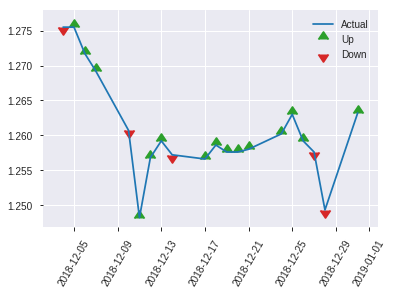


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22901371490243633
RMSE: 0.47855377430591467
LogLoss: 0.6505107102482391
Null degrees of freedom: 255
Residual degrees of freedom: -764
Null deviance: 354.999547062732
Residual deviance: 333.06148364709844
AIC: 2373.0614836470986
AUC: 0.6931207233626588
pr_auc: 0.6551021069067977
Gini: 0.3862414467253177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4732256168954826: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   73   0.5887   (73.0/124.0)
1      15   117  0.1136   (15.0/132.0)
Total  66   190  0.3438   (88.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473226     0.726708  189
max f2                       0.397107     0.847458  238
max f0point5                 0.505393     0.671053  156
max accuracy                 0.505393     0.667969  156
max precision                0.610159     0.783784  36
max recall                   0.340375     1         251
max specificity              0.690863     0.991935  0
max absolute_mcc             0.473226     0.340064  189
max min_per_class_accuracy   0.532596     0.643939  128
max mean_per_class_accuracy  0.505393     0.664589  156

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 52.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.677618           1.29293   1.29293            0.666667         0.68707   0.666667                    0.68707             0.0151515       0.0151515                  29.2929   29.2929
    2        0.0234375                   0.665966           0.646465  0.969697           0.333333         0.668476  0.5                         0.677773            0.00757576      0.0227273                  -35.3535  -3.0303
    3        0.03125                     0.661737           1.93939   1.21212            1                0.664331  0.625                       0.674413            0.0151515       0.0378788                  93.9394   21.2121
    4        0.0429688                   0.656338           1.93939   1.41047            1                0.65885   0.727273                    0.670168            0.0227273       0.0606061                  93.9394   41.0468
    5        0.0507812                   0.649073           0         1.19347            0                0.651241  0.615385                    0.667256            0               0.0606061                  -100      19.3473
    6        0.101562                    0.619456           1.49184   1.34266            0.769231         0.632184  0.692308                    0.64972             0.0757576       0.136364                   49.1841   34.2657
    7        0.152344                    0.609104           1.79021   1.49184            0.923077         0.613621  0.769231                    0.637687            0.0909091       0.227273                   79.021    49.1841
    8        0.203125                    0.597462           1.19347   1.41725            0.615385         0.602748  0.730769                    0.628952            0.0606061       0.287879                   19.3473   41.7249
    9        0.300781                    0.573912           1.16364   1.33491            0.6              0.586845  0.688312                    0.615281            0.113636        0.401515                   16.3636   33.4908
    10       0.402344                    0.552186           1.04429   1.26155            0.538462         0.563861  0.650485                    0.602301            0.106061        0.507576                   4.4289    26.1548
    11       0.5                         0.532741           1.31879   1.27273            0.68             0.541713  0.65625                     0.590468            0.128788        0.636364                   31.8788   27.2727
    12       0.601562                    0.507639           1.11888   1.24675            0.576923         0.521561  0.642857                    0.578834            0.113636        0.75                       11.8881   24.6753
    13       0.699219                    0.483438           0.853333  1.19181            0.44             0.496026  0.614525                    0.567269            0.0833333       0.833333                   -14.6667  19.1806
    14       0.800781                    0.453085           0.745921  1.13525            0.384615         0.468708  0.585366                    0.554768            0.0757576       0.909091                   -25.4079  13.5255
    15       0.898438                    0.411034           0.620606  1.07931            0.32             0.433737  0.556522                    0.541613            0.0606061       0.969697                   -37.9394  7.93149
    16       1                           0.299837           0.298368  1                  0.153846         0.371513  0.515625                    0.524337         

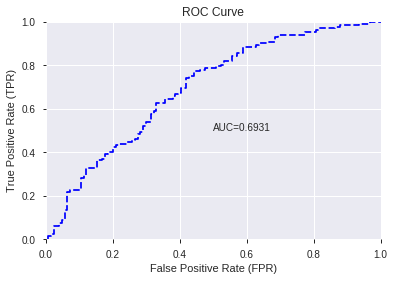

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


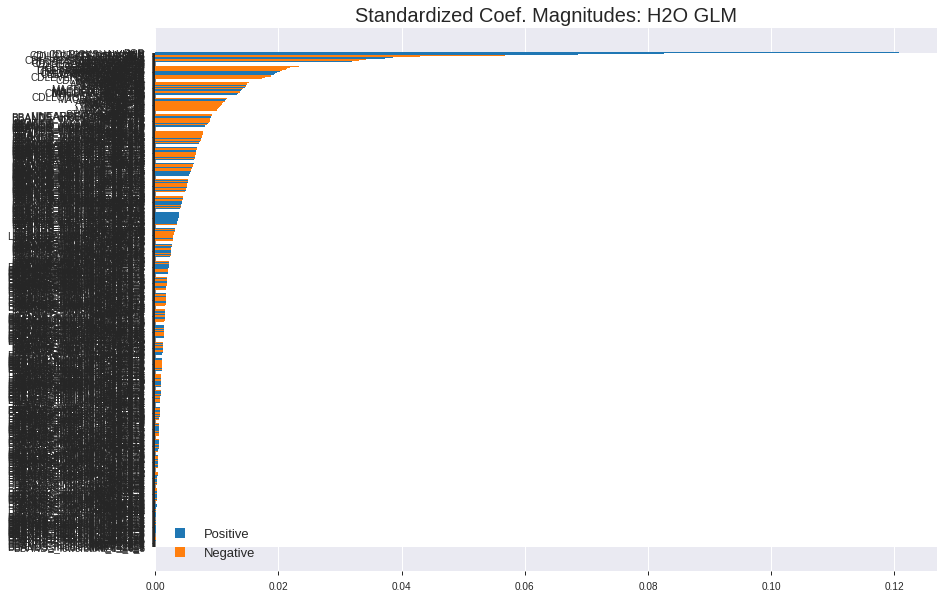

'log_likelihood'
--2019-08-22 12:45:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


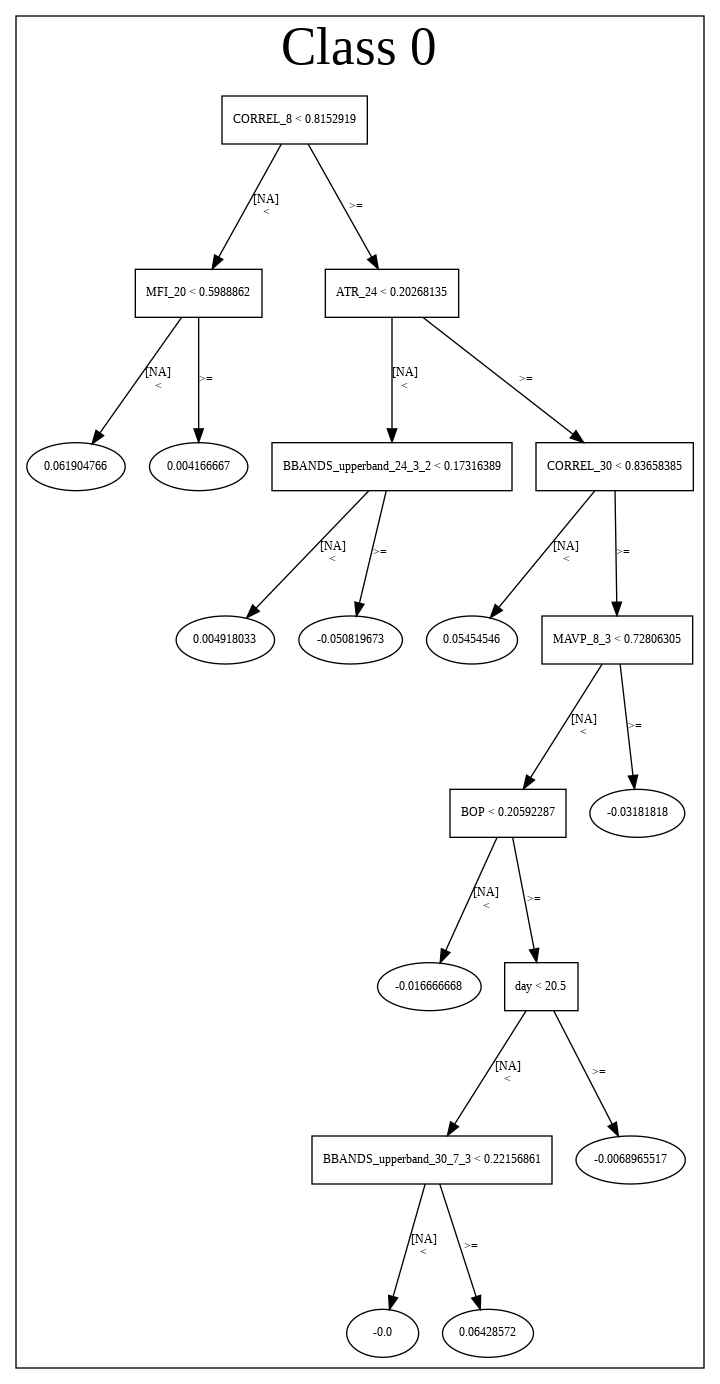

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124440_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124440_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

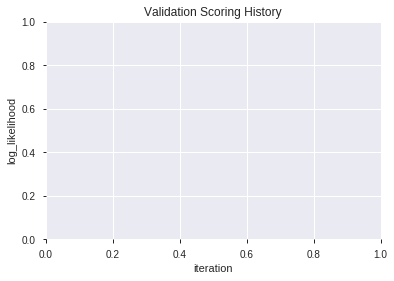

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124543_model_4  0.713343  0.637376              0.369257  0.472151  0.222926
1               XGBoost_1_AutoML_20190822_124543  0.698986  0.649204              0.358260  0.478402  0.228869
2               XGBoost_3_AutoML_20190822_124543  0.671493  0.659581              0.366813  0.483845  0.234106
3  XGBoost_grid_1_AutoML_20190822_124543_model_2  0.669355  0.654835              0.396505  0.480972  0.231334
4  XGBoost_grid_1_AutoML_20190822_124543_model_7  0.666850  0.660281              0.409580  0.484114  0.234366
5  XGBoost_grid_1_AutoML_20190822_124543_model_6  0.663490  0.662171              0.398827  0.484660  0.234895
6               XGBoost_2_AutoML_20190822_124543  0.661351  0.659151              0.408847  0.483390  0.233666
7  XGBoost_grid_1_AutoML_20190822_124543_model_3  0.653867  0.703235              0.430963  0.505464  0.255494
8  XGBoost_grid_1_AutoML_20190822_124543_model_5  0.636975  0.687836              0.413612  0.497108  0.247117
9  XGBoost_grid_1_AutoML_20190822_124543_model_1  0.626375  0.722051              0.479839  0.512637  0.262797

variable  relative_importance  scaled_importance  percentage
0                       BOP           308.292175           1.000000    0.077094
1                       DIV           281.860626           0.914265    0.070484
2                       SUB           271.625183           0.881064    0.067925
3                 PLUS_DM_8           102.257050           0.331689    0.025571
4                    ULTOSC            79.426193           0.257633    0.019862
..                      ...                  ...                ...         ...
158  BBANDS_lowerband_8_8_5             5.627276           0.018253    0.001407
159                     PPO             5.111034           0.016579    0.001278
160  BBANDS_upperband_8_2_5             4.931817           0.015997    0.001233
161       MACDFIX_signal_12             4.860197           0.015765    0.001215
162      LINEARREG_ANGLE_20             4.218816           0.013684    0.001055

[163 rows x 4 columns]

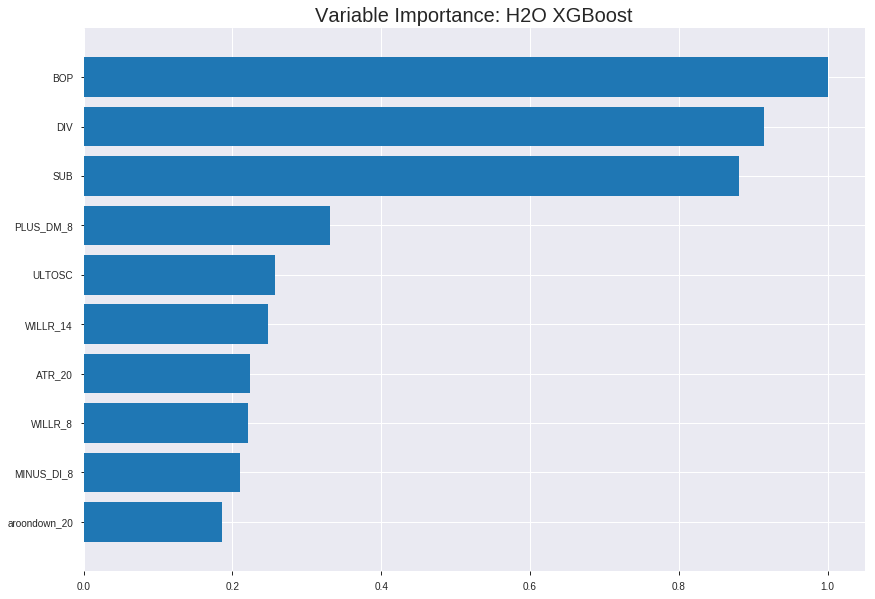

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124543_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1993550162598579
RMSE: 0.446491899433638
LogLoss: 0.5879532821335282
Mean Per-Class Error: 0.2588467917305515
AUC: 0.8208119131367184
pr_auc: 0.8144687610643372
Gini: 0.6416238262734368
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47616178294022876: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      548  351   0.3904   (351.0/899.0)
1      132  756   0.1486   (132.0/888.0)
Total  680  1107  0.2703   (483.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476162     0.757895  223
max f2                       0.378683     0.855695  300
max f0point5                 0.541601     0.75594   157
max accuracy                 0.525467     0.741466  175
max precision                0.76713      1         0
max recall                   0.243113     1         383
max specificity              0.76713      1         0
max absolute_mcc             0.525467     0.48496   175
max min_per_class_accuracy   0.51224      0.736374  188
max mean_per_class_accuracy  0.525467     0.741153  175

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.721917           2.01239   2.01239            1                0.741528  1                           0.741528            0.0202703       0.0202703                  101.239   101.239
    2        0.0201455                   0.706797           1.90059   1.95649            0.944444         0.715123  0.972222                    0.728325            0.0191441       0.0394144                  90.0588   95.6488
    3        0.0302182                   0.696152           2.01239   1.97512            1                0.701857  0.981481                    0.719503            0.0202703       0.0596847                  101.239   97.5121
    4        0.040291                    0.682137           2.01239   1.98444            1                0.687822  0.986111                    0.711582            0.0202703       0.079955                   101.239   98.4438
    5        0.0503637                   0.672681           2.01239   1.99003            1                0.677567  0.988889                    0.704779            0.0202703       0.100225                   101.239   99.0028
    6        0.100168                    0.641858           1.71844   1.85499            0.853933         0.655873  0.921788                    0.680463            0.0855856       0.185811                   71.8443   85.4994
    7        0.149972                    0.620651           1.69583   1.80214            0.842697         0.631082  0.895522                    0.664064            0.0844595       0.27027                    69.5832   80.2138
    8        0.200336                    0.604337           1.67699   1.77068            0.833333         0.611299  0.879888                    0.650799            0.0844595       0.35473                    67.6989   77.0676
    9        0.299944                    0.570714           1.49233   1.67824            0.741573         0.587441  0.833955                    0.629758            0.148649        0.503378                   49.2332   67.8241
    10       0.400112                    0.538076           1.3266    1.59021            0.659218         0.553585  0.79021                     0.610688            0.132883        0.636261                   32.6602   59.0208
    11       0.50028                     0.511079           1.00057   1.47215            0.497207         0.524178  0.731544                    0.593367            0.100225        0.736486                   0.05725   47.2149
    12       0.599888                    0.48247            0.915749  1.37976            0.455056         0.497359  0.685634                    0.577425            0.0912162       0.827703                   -8.42507  37.9762
    13       0.700056                    0.441645           0.809452  1.29816            0.402235         0.462324  0.645084                    0.560956            0.0810811       0.908784                   -19.0548  29.8159
    14       0.799664                    0.393857           0.50875   1.19983            0.252809         0.416981  0.596221                    0.543022            0.0506757       0.959459                   -49.125   19.9828
    15       0.899832                    0.328892           0.269817  1.0963             0.134078         0.362695  0.544776                    0.522948            0.027027        0.986486                   -73.0183  9.63006
    16       1                           0.196203           0.134909  1                  0.0670391        0.27838   0.496922                    0.49845          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24470497549261025
RMSE: 0.4946766373021979
LogLoss: 0.6823220383451998
Mean Per-Class Error: 0.43253241858819547
AUC: 0.5863803473365227
pr_auc: 0.5506560542356087
Gini: 0.17276069467304533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3940066695213318: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   218  0.8417   (218.0/259.0)
1      13   238  0.0518   (13.0/251.0)
Total  54   456  0.4529   (231.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394007     0.673267  353
max f2                       0.316194     0.83167   388
max f0point5                 0.441843     0.578864  313
max accuracy                 0.566946     0.566667  158
max precision                0.75753      1         0
max recall                   0.263385     1         396
max specificity              0.75753      1         0
max absolute_mcc             0.407801     0.173859  343
max min_per_class_accuracy   0.538844     0.552124  199
max mean_per_class_accuracy  0.441843     0.567468  313

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 52.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.719912           1.35458   1.35458            0.666667         0.734181  0.666667                    0.734181            0.0159363       0.0159363                  35.4582   35.4582
    2        0.0215686                   0.695506           1.21912   1.29301            0.6              0.702423  0.636364                    0.719746            0.0119522       0.0278884                  21.9124   29.301
    3        0.0313725                   0.681656           0.812749  1.14293            0.4              0.68716   0.5625                      0.709563            0.00796813      0.0358566                  -18.7251  14.2928
    4        0.0411765                   0.676414           0.812749  1.06431            0.4              0.677461  0.52381                     0.70192             0.00796813      0.0438247                  -18.7251  6.43142
    5        0.0509804                   0.671665           2.03187   1.25038            1                0.673765  0.615385                    0.696505            0.0199203       0.063745                   103.187   25.0383
    6        0.1                         0.643279           1.13785   1.19522            0.56             0.657246  0.588235                    0.67726             0.0557769       0.119522                   13.7849   19.5219
    7        0.15098                     0.625216           1.17223   1.18746            0.576923         0.633445  0.584416                    0.662466            0.059761        0.179283                   17.2234   18.7458
    8        0.2                         0.612741           1.21912   1.19522            0.6              0.619351  0.588235                    0.651898            0.059761        0.239044                   21.9124   19.5219
    9        0.3                         0.588143           1.15538   1.18194            0.568627         0.600528  0.581699                    0.634775            0.115538        0.354582                   15.5378   18.1939
    10       0.4                         0.56468            1.0757    1.15538            0.529412         0.57568   0.568627                    0.620001            0.10757         0.462151                   7.56972   15.5378
    11       0.5                         0.538323           0.916335  1.10757            0.45098          0.553313  0.545098                    0.606664            0.0916335       0.553785                   -8.36653  10.757
    12       0.6                         0.510441           1.03586   1.09562            0.509804         0.52396   0.539216                    0.59288             0.103586        0.657371                   3.58566   9.56175
    13       0.7                         0.475937           0.876494  1.06431            0.431373         0.494722  0.52381                     0.578857            0.0876494       0.74502                    -12.3506  6.43142
    14       0.8                         0.44174            1.23506   1.08566            0.607843         0.458131  0.534314                    0.563766            0.123506        0.868526                   23.506    8.56574
    15       0.9                         0.387303           0.796813  1.05356            0.392157         0.416925  0.518519                    0.547451            0.0796813       0.948207                   -20.3187  5.35635
    16       1                           0.209983           0.517928  1                  0.254902         0.335865  0.492157                    0.526292           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:46:07  10.245 sec  0                  0.5              0.693147            0.5             0                  1                0.503078                         0.5                0.693147              0.5               0                    1                  0.507843
    2019-08-22 12:46:08  10.982 sec  5                  0.490353         0.673986            0.713286        0.699233           1.78879          0.387241                         0.498838           0.690817              0.531326          0.507072             1.35458            0.494118
    2019-08-22 12:46:08  11.308 sec  10                 0.48366          0.660796            0.743421        0.728773           1.90059          0.334079                         0.498753           0.690643              0.535926          0.507958             0.338645           0.488235
    2019-08-22 12:46:09  11.621 sec  15                 0.477587         0.648839            0.754858        0.740928           1.90059          0.332401                         0.498492           0.690132              0.549816          0.519186             1.01594            0.492157
    2019-08-22 12:46:09  11.958 sec  20                 0.472147         0.63816             0.76975         0.761564           2.01239          0.31897                          0.498394           0.689907              0.545748          0.512419             1.01594            0.492157
    2019-08-22 12:46:10  12.378 sec  25                 0.467267         0.628558            0.77719         0.771162           2.01239          0.313934                         0.497121           0.687315              0.562007          0.534101             1.69323            0.456863
    2019-08-22 12:46:10  12.737 sec  30                 0.462235         0.618653            0.786473        0.780149           2.01239          0.303302                         0.496188           0.685386              0.568406          0.536321             1.35458            0.458824
    2019-08-22 12:46:10  13.081 sec  35                 0.457918         0.610225            0.796772        0.789825           2.01239          0.297706                         0.496183           0.685387              0.573836          0.5391               1.01594            0.439216
    2019-08-22 12:46:11  13.416 sec  40                 0.454063         0.602732            0.806071        0.798812           2.01239          0.273083                         0.49501            0.68302               0.585081          0.552406             1.01594            0.437255
    2019-08-22 12:46:11  13.751 sec  45                 0.450424         0.595747            0.81766         0.810588           2.01239          0.271964                         0.494891           0.682776              0.584358          0.551883             1.35458            0.447059
    2019-08-22 12:46:11  14.107 sec  50                 0.446492         0.587953            0.820812        0.814469           2.01239          0.270285                         0.494677           0.682322              0.58638           0.550656             1.35458            0.452941

Variable Importances: 


variable                relative_importance    scaled_importance     percentage
----------------------  ---------------------  --------------------  ---------------------
BOP                     308.29217529296875     1.0                   0.07709373277233526
DIV                     281.8606262207031      0.9142646126287577    0.07048407172920405
SUB                     271.62518310546875     0.881064149121996     0.06792452406769611
PLUS_DM_8               102.25704956054688     0.33168876071334746   0.025571124682021863
ULTOSC                  79.42619323730469      0.2576328548132184    0.019861878462344107
---                     ---                    ---                   ---
BBANDS_lowerband_8_8_5  5.627276420593262      0.018253062748821585  0.0014071967418343185
PPO                     5.111033916473389      0.016578539210787283  0.0012781014716721167
BBANDS_upperband_8_2_5  4.931816577911377      0.015997216190208826  0.0012332851100692343
MACDFIX_signal_12       4.860196590423584      0.015764904139409182  0.0012153753069050934
LINEARREG_ANGLE_20      4.218815803527832      0.013684472528434136  0.0010549870682374644


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66015625)

('F1', 0.7309941520467836)

('auc', 0.7133431085043989)

('logloss', 0.6373761478178166)

('mean_per_class_error', 0.3393206256109482)

('rmse', 0.4721505578824084)

('mse', 0.2229261493086695)

xgboost prediction progress: |████████████████████████████████████████████| 100%


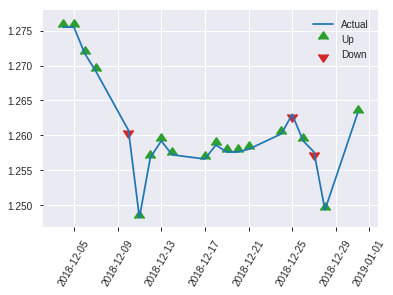


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2229261493086695
RMSE: 0.4721505578824084
LogLoss: 0.6373761478178166
Mean Per-Class Error: 0.3393206256109482
AUC: 0.7133431085043989
pr_auc: 0.6999237597834953
Gini: 0.4266862170087977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.456459105014801: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      39   85   0.6855   (85.0/124.0)
1      7    125  0.053    (7.0/132.0)
Total  46   210  0.3594   (92.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456459     0.730994  209
max f2                       0.388333     0.858453  234
max f0point5                 0.54406      0.672468  124
max accuracy                 0.54406      0.660156  124
max precision                0.724106     1         0
max recall                   0.29006      1         251
max specificity              0.724106     1         0
max absolute_mcc             0.456459     0.340375  209
max min_per_class_accuracy   0.542223     0.645161  129
max mean_per_class_accuracy  0.54406      0.660679  124

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.701708           1.93939   1.93939            1                0.713241  1                           0.713241            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.681866           1.29293   1.61616            0.666667         0.691927  0.833333                    0.702584            0.0151515       0.0378788                  29.2929   61.6162
    3        0.03125                     0.672759           1.93939   1.69697            1                0.674038  0.875                       0.695447            0.0151515       0.0530303                  93.9394   69.697
    4        0.0429688                   0.665876           1.29293   1.58678            0.666667         0.670297  0.818182                    0.688588            0.0151515       0.0681818                  29.2929   58.6777
    5        0.0507812                   0.657583           0.969697  1.49184            0.5              0.662367  0.769231                    0.684554            0.00757576      0.0757576                  -3.0303   49.1841
    6        0.101562                    0.632317           1.64103   1.56643            0.846154         0.645168  0.807692                    0.664861            0.0833333       0.159091                   64.1026   56.6434
    7        0.152344                    0.614504           1.34266   1.49184            0.692308         0.62015   0.769231                    0.649957            0.0681818       0.227273                   34.2657   49.1841
    8        0.203125                    0.606456           1.49184   1.49184            0.769231         0.611063  0.769231                    0.640234            0.0757576       0.30303                    49.1841   49.1841
    9        0.300781                    0.583585           1.08606   1.36009            0.56             0.594904  0.701299                    0.625516            0.106061        0.409091                   8.60606   36.0094
    10       0.402344                    0.559438           1.26807   1.33686            0.653846         0.572328  0.68932                     0.61209             0.128788        0.537879                   26.8065   33.6864
    11       0.5                         0.542506           1.08606   1.28788            0.56             0.549787  0.664062                    0.599922            0.106061        0.643939                   8.60606   28.7879
    12       0.601562                    0.525028           0.969697  1.23416            0.5              0.534957  0.636364                    0.588954            0.0984848       0.742424                   -3.0303   23.416
    13       0.699219                    0.498786           0.853333  1.18097            0.44             0.51243   0.608939                    0.578266            0.0833333       0.825758                   -14.6667  18.0972
    14       0.800781                    0.461192           0.895105  1.14472            0.461538         0.480164  0.590244                    0.565824            0.0909091       0.916667                   -10.4895  14.4715
    15       0.898438                    0.400822           0.620606  1.08775            0.32             0.433658  0.56087                     0.551458            0.0606061       0.977273                   -37.9394  8.7747
    16       1                           0.22263            0.223776  1                  0.115385         0.339628  0.515625                    0.529944            

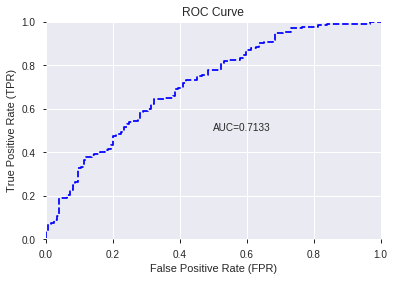

This function is available for GLM models only


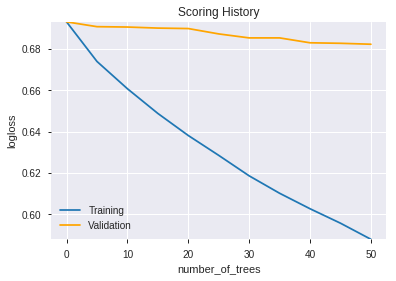

--2019-08-22 12:46:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

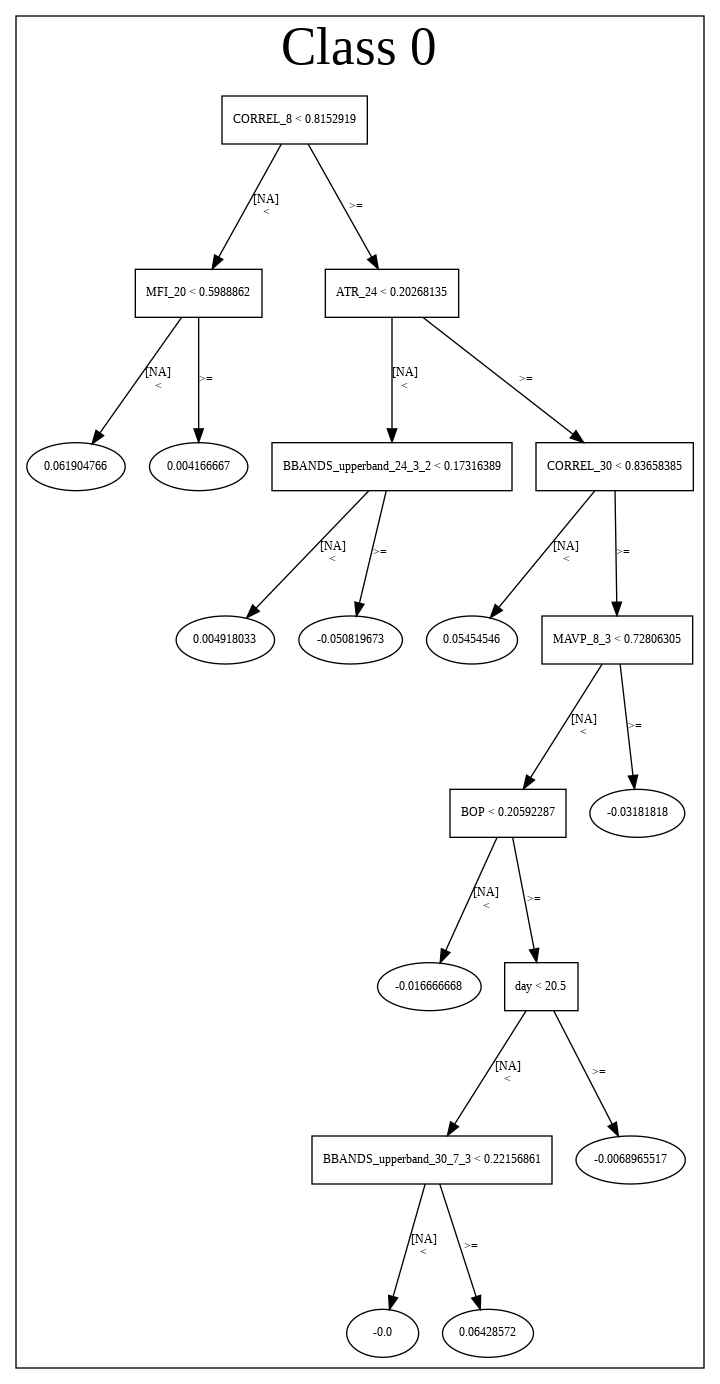

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124543_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124543_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_124637_model_9  0.700819  0.631621              0.385142  0.470217  0.221104
1  DeepLearning_grid_1_AutoML_20190822_124637_model_6  0.697092  0.632056              0.406281  0.471336  0.222158
2  DeepLearning_grid_1_AutoML_20190822_124637_model_3  0.692082  0.658457              0.363270  0.475236  0.225849
3  DeepLearning_grid_1_AutoML_20190822_124637_model_5  0.670699  0.671902              0.404570  0.490181  0.240277
4  DeepLearning_grid_1_AutoML_20190822_124637_model_7  0.665567  0.694854              0.408602  0.496000  0.246016
5  DeepLearning_grid_1_AutoML_20190822_124637_model_8  0.665200  0.656454              0.429985  0.483538  0.233809
6  DeepLearning_grid_1_AutoML_20190822_124637_model_2  0.614003  0.775431              0.453446  0.510079  0.260181
7               DeepLearning_1_AutoML_20190822_124637  0.613759  0.683591              0.413612  0.493465  0.243508
8  DeepLearning_grid_1_AutoML_20190822_124637_model_4  0.609421  0.889066              0.471530  0.537681  0.289100
9  DeepLearning_grid_1_AutoML_20190822_124637_model_1  0.605511  0.873593              0.491691  0.524963  0.275586

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.045400
1                  DIV             0.940227           0.940227    0.042686
2                  SUB             0.877831           0.877831    0.039853
3               VAR_12             0.585465           0.585465    0.026580
4               VAR_30             0.559714           0.559714    0.025411
5            dayofyear             0.550965           0.550965    0.025014
6               ULTOSC             0.524799           0.524799    0.023826
7               VAR_14             0.524724           0.524724    0.023822
8               TRANGE             0.511953           0.511953    0.023243
9               SAREXT             0.488429           0.488429    0.022175
10      CDLRICKSHAWMAN             0.474751           0.474751    0.021554
11              VAR_24             0.472651           0.472651    0.021458
12                 day             0.462569           0.462569    0.021000
13        STOCHF_fastk             0.459968           0.459968    0.020882
14   CDLINVERTEDHAMMER             0.459449           0.459449    0.020859
15   CDLGRAVESTONEDOJI             0.445360           0.445360    0.020219
16     CDLADVANCEBLOCK             0.442518           0.442518    0.020090
17              VAR_20             0.431980           0.431980    0.019612
18               VAR_8             0.428065           0.428065    0.019434
19  CDLMORNINGDOJISTAR             0.419910           0.419910    0.019064
20             WILLR_8             0.416167           0.416167    0.018894
21  CDLEVENINGDOJISTAR             0.415225           0.415225    0.018851
22     CDLLADDERBOTTOM             0.410723           0.410723    0.018647
23           CDLONNECK             0.410174           0.410174    0.018622
24      CDLMORNINGSTAR             0.408462           0.408462    0.018544
25             CDLDOJI             0.400912           0.400912    0.018201
26       days_in_month             0.396411           0.396411    0.017997
27   CDLLONGLEGGEDDOJI             0.391303           0.391303    0.017765
28      CDLEVENINGSTAR             0.388871           0.388871    0.017655
29    CDLDRAGONFLYDOJI             0.385189           0.385189    0.017487
30        HT_TRENDMODE             0.384487           0.384487    0.017456
31      is_quarter_end             0.383020           0.383020    0.017389
32        weekday_name             0.380467           0.380467    0.017273
33     CDLHOMINGPIGEON             0.379787           0.379787    0.017242
34      STOCHRSI_fastk             0.373486           0.373486    0.016956
35      CDLSPINNINGTOP             0.364116           0.364116    0.016531
36            CORREL_8             0.363550           0.363550    0.016505
37        is_month_end             0.362093           0.362093    0.016439
38           CDLTAKURI             0.360827           0.360827    0.016381
39     CDLSHOOTINGSTAR             0.359877           0.359877    0.016338
40    is_quarter_start             0.354481           0.354481    0.016093
41      CDLHARAMICROSS             0.335908           0.335908    0.015250
42    CDLCOUNTERATTACK             0.334582           0.334582    0.015190
43      is_month_start             0.332157           0.332157    0.015080
44      CDLMATCHINGLOW             0.322949           0.322949    0.014662
45          CDL3INSIDE             0.322174           0.322174    0.014627
46        CDLTASUKIGAP             0.321124           0.321124    0.014579
47           CORREL_30             0.315553           0.315553    0.014326
48           CDLHAMMER             0.301169           0.301169    0.013673
49       CDLHANGINGMAN             0.289995           0.289995    0.013166

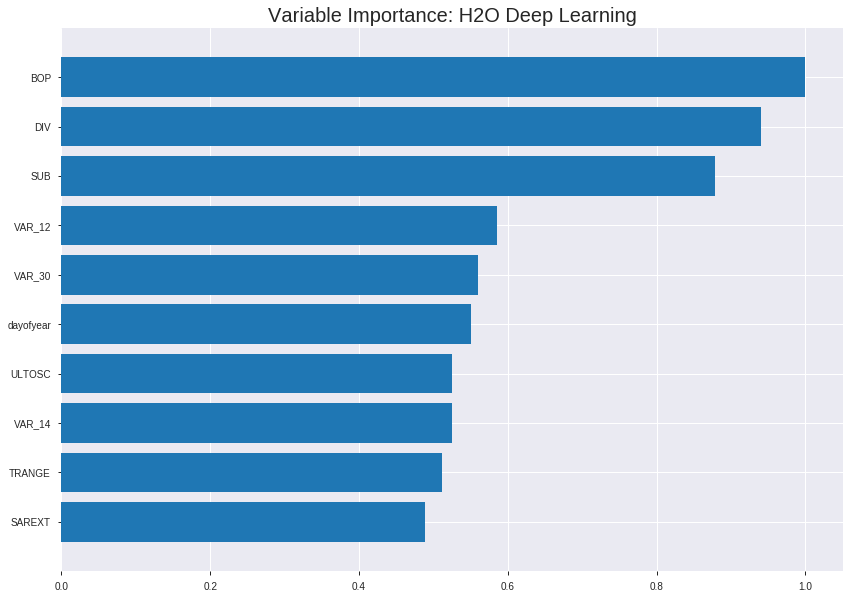

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_124637_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21653409211907668
RMSE: 0.46533223842656407
LogLoss: 0.6201987119162982
Mean Per-Class Error: 0.3560825842527733
AUC: 0.7095509024040726
pr_auc: 0.6926206804980499
Gini: 0.4191018048081452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4444853194900439: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      337  562   0.6251   (562.0/899.0)
1      93   795   0.1047   (93.0/888.0)
Total  430  1357  0.3665   (655.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444485     0.708241  222
max f2                       0.212336     0.844621  326
max f0point5                 0.51267      0.642655  159
max accuracy                 0.51267      0.644096  159
max precision                0.783177     1         0
max recall                   0.0932041    1         387
max specificity              0.783177     1         0
max absolute_mcc             0.444485     0.315964  222
max min_per_class_accuracy   0.506038     0.631813  167
max mean_per_class_accuracy  0.51267      0.643917  159

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.721118           1.78879   1.78879            0.888889         0.734506  0.888889                    0.734506            0.018018        0.018018                   78.8789   78.8789
    2        0.0201455                   0.693718           1.90059   1.84469            0.944444         0.706702  0.916667                    0.720604            0.0191441       0.0371622                  90.0588   84.4688
    3        0.0302182                   0.678191           1.22979   1.63972            0.611111         0.68575   0.814815                    0.708986            0.0123874       0.0495495                  22.9792   63.9723
    4        0.040291                    0.662654           1.67699   1.64904            0.833333         0.6718    0.819444                    0.69969             0.0168919       0.0664414                  67.6989   64.904
    5        0.0503637                   0.656456           1.34159   1.58755            0.666667         0.65968   0.788889                    0.691688            0.0135135       0.079955                   34.1592   58.755
    6        0.100168                    0.630702           1.628     1.60766            0.808989         0.643894  0.798883                    0.667924            0.0810811       0.161036                   62.7999   60.7661
    7        0.149972                    0.606304           1.51494   1.57687            0.752809         0.617279  0.783582                    0.651106            0.0754505       0.236486                   51.4943   57.6871
    8        0.200336                    0.58393            1.52047   1.56269            0.755556         0.594823  0.776536                    0.636956            0.0765766       0.313063                   52.047    56.2692
    9        0.299944                    0.551055           1.20969   1.44546            0.601124         0.566532  0.718284                    0.613569            0.120495        0.433559                   20.9694   44.5465
    10       0.400112                    0.527048           1.0343    1.34253            0.513966         0.539111  0.667133                    0.594929            0.103604        0.537162                   3.42997   34.253
    11       0.50028                     0.505917           0.978088  1.26956            0.486034         0.51574   0.630872                    0.579073            0.097973        0.635135                   -2.19123  26.956
    12       0.599888                    0.4955             0.93836   1.21457            0.466292         0.499031  0.603545                    0.565783            0.0934685       0.728604                   -6.16396  21.4566
    13       0.700056                    0.48325            1.09051   1.19682            0.541899         0.49215   0.594724                    0.555247            0.109234        0.837838                   9.05116   19.6816
    14       0.799664                    0.40057            0.802694  1.14772            0.398876         0.447625  0.570329                    0.541841            0.079955        0.917793                   -19.7306  14.7723
    15       0.899832                    0.217878           0.618331  1.08879            0.307263         0.302213  0.541045                    0.515166            0.0619369       0.97973                    -38.1669  8.87917
    16       1                           1.10621e-07        0.202363  1                  0.100559         0.147801  0.496922                    0.478368            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2359636430561032
RMSE: 0.48576089082603513
LogLoss: 0.6626288870959649
Mean Per-Class Error: 0.3990524388930763
AUC: 0.6230598840160593
pr_auc: 0.5718544220115773
Gini: 0.24611976803211855
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26733402040058685: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   203  0.7838   (203.0/259.0)
1      11   240  0.0438   (11.0/251.0)
Total  67   443  0.4196   (214.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267334     0.691643  339
max f2                       0.161279     0.83668   380
max f0point5                 0.30711      0.597356  326
max accuracy                 0.498088     0.6       220
max precision                0.655922     0.68      22
max recall                   0.12114      1         392
max specificity              0.763797     0.996139  0
max absolute_mcc             0.30711      0.256076  326
max min_per_class_accuracy   0.501849     0.581673  204
max mean_per_class_accuracy  0.497885     0.600948  221

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 47.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.725956           1.01594   1.01594            0.5              0.741732  0.5                         0.741732            0.0119522       0.0119522                  1.59363    1.59363
    2        0.0215686                   0.710139           0.812749  0.923578           0.4              0.717401  0.454545                    0.730673            0.00796813      0.0199203                  -18.7251   -7.64216
    3        0.0313725                   0.675119           2.03187   1.26992            1                0.691574  0.625                       0.718454            0.0199203       0.0398406                  103.187    26.992
    4        0.0411765                   0.666661           1.21912   1.25783            0.6              0.669396  0.619048                    0.706774            0.0119522       0.0517928                  21.9124    25.7826
    5        0.0509804                   0.654214           1.6255    1.32853            0.8              0.661793  0.653846                    0.698124            0.0159363       0.0677291                  62.5498    32.8532
    6        0.1                         0.608377           1.05657   1.19522            0.52             0.63093   0.588235                    0.665185            0.0517928       0.119522                   5.65737    19.5219
    7        0.15098                     0.583995           1.17223   1.18746            0.576923         0.595658  0.584416                    0.641709            0.059761        0.179283                   17.2234    18.7458
    8        0.2                         0.565213           1.38167   1.23506            0.68             0.574075  0.607843                    0.625132            0.0677291       0.247012                   38.1673    23.506
    9        0.3                         0.536871           1.19522   1.22178            0.588235         0.55      0.601307                    0.600088            0.119522        0.366534                   19.5219    22.178
    10       0.4                         0.515598           0.996016  1.16534            0.490196         0.524919  0.573529                    0.581296            0.0996016       0.466135                   -0.398406  16.5339
    11       0.5                         0.501544           1.15538   1.16335            0.568627         0.507549  0.572549                    0.566546            0.115538        0.581673                   15.5378    16.3347
    12       0.6                         0.495816           1.11554   1.15538            0.54902          0.498286  0.568627                    0.555169            0.111554        0.693227                   11.5538    15.5378
    13       0.7                         0.484377           1.03586   1.1383             0.509804         0.491984  0.560224                    0.546143            0.103586        0.796813                   3.58566    13.8304
    14       0.8                         0.398198           0.796813  1.09562            0.392157         0.453281  0.539216                    0.534535            0.0796813       0.876494                   -20.3187   9.56175
    15       0.9                         0.221403           0.916335  1.0757             0.45098          0.303156  0.529412                    0.508826            0.0916335       0.968127                   -8.36653   7.56972
    16       1                           0.00446286         0.318725  1                  0.156863         0.163963  0.492157                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:55:17  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:55:20  3 min 25.508 sec  403 obs/sec       0.662003  1             1183       0.566658         0.877098            -0.284452      0.579613        0.57257            1.34159          0.496922                         0.578682           0.916415              -0.339822        0.559953          0.55177              2.03187            0.482353
    2019-08-22 12:55:43  3 min 48.327 sec  837 obs/sec       11.3867   17            20348      0.477434         0.646412            0.0881938      0.666774        0.644776           1.56519          0.40291                          0.487764           0.667796              0.0481092        0.623498          0.583116             1.35458            0.445098
    2019-08-22 12:55:59  4 min  3.821 sec  936 obs/sec       20.0907   30            35902      0.483525         0.656782            0.0647776      0.677012        0.660522           1.78879          0.387801                         0.49262            0.676157              0.0290637        0.617422          0.567251             1.01594            0.437255
    2019-08-22 12:56:14  4 min 18.933 sec  1015 obs/sec      29.5204   44            52753      0.481429         0.653386            0.0728699      0.68757         0.667651           1.78879          0.382205                         0.493444           0.67849               0.0258113        0.616768          0.569383             1.01594            0.427451
    2019-08-22 12:56:29  4 min 34.193 sec  1074 obs/sec      39.5658   59            70704      0.470259         0.630931            0.115392       0.697626        0.678325           1.78879          0.379407                         0.486749           0.664658              0.0520667        0.609062          0.561551             1.01594            0.433333
    2019-08-22 12:56:44  4 min 49.129 sec  1119 obs/sec      49.667    74            88755      0.465332         0.620199            0.133831       0.709551        0.692621           1.78879          0.366536                         0.485761           0.662629              0.0559131        0.62306           0.571854             1.01594            0.419608
    2019-08-22 12:57:00  5 min  4.479 sec  1157 obs/sec      60.3497   90            107845     0.459957         0.608726            0.153724       0.722249        0.706532           2.01239          0.362619                         0.490242           0.674254              0.0384148        0.61593           0.562897             1.01594            0.415686
    2019-08-22 12:57:01  5 min  5.910 sec  1156 obs/sec      60.3497   90            107845     0.465332         0.620199            0.133831       0.709551        0.692621           1.78879          0.366536                         0.485761           0.662629              0.0559131        0.62306           0.571854             1.01594            0.419608

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  --------------------
BOP            1.0                    1.0                  0.04539971118800429
DIV            0.9402274489402771     0.9402274489402771   0.04268605463292263
SUB            0.8778314590454102     0.8778314590454102   0.039853294712406034
VAR_12         0.5854648947715759     0.5854648947715759   0.02657993713334487
VAR_30         0.5597138404846191     0.5597138404846191   0.025410846705930412
---            ---                    ---                  ---
CDL3INSIDE     0.322173535823822      0.322173535823822    0.014626585478819674
CDLTASUKIGAP   0.3211243450641632     0.3211243450641632   0.01457895252135004
CORREL_30      0.31555289030075073    0.31555289030075073  0.014326010084194084
CDLHAMMER      0.30116933584213257    0.30116933584213257  0.013673000865915887
CDLHANGINGMAN  0.28999510407447815    0.28999510407447815  0.013165693970916555


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66796875)

('F1', 0.7209302325581395)

('auc', 0.7008186705767351)

('logloss', 0.6316205104122828)

('mean_per_class_error', 0.3295454545454546)

('rmse', 0.47021723585219777)

('mse', 0.2211042488924814)

deeplearning prediction progress: |███████████████████████████████████████| 100%


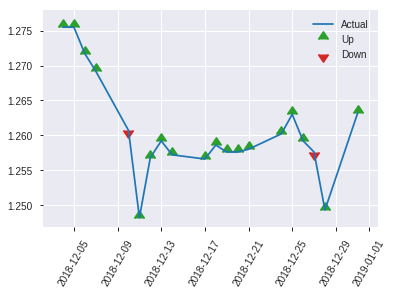


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2211042488924814
RMSE: 0.47021723585219777
LogLoss: 0.6316205104122828
Mean Per-Class Error: 0.3295454545454546
AUC: 0.7008186705767351
pr_auc: 0.7195211364376726
Gini: 0.40163734115347016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44087377508841324: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      36   88   0.7097   (88.0/124.0)
1      8    124  0.0606   (8.0/132.0)
Total  44   212  0.375    (96.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440874     0.72093   211
max f2                       0.167452     0.851613  246
max f0point5                 0.528699     0.68662   108
max accuracy                 0.528699     0.667969  108
max precision                0.741672     1         0
max recall                   0.167452     1         246
max specificity              0.741672     1         0
max absolute_mcc             0.528699     0.34456   108
max min_per_class_accuracy   0.514266     0.629032  129
max mean_per_class_accuracy  0.528699     0.670455  108

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 50.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.703165           1.93939   1.93939            1                0.728718  1                           0.728718            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.673704           1.93939   1.93939            1                0.680763  1                           0.704741            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.667921           0.969697  1.69697            0.5              0.670196  0.875                       0.696104            0.00757576      0.0530303                  -3.0303   69.697
    4        0.0429688                   0.654852           1.93939   1.76309            1                0.660409  0.909091                    0.686369            0.0227273       0.0757576                  93.9394   76.3085
    5        0.0507812                   0.651824           1.93939   1.79021            1                0.65358   0.923077                    0.681325            0.0151515       0.0909091                  93.9394   79.021
    6        0.101562                    0.632075           1.49184   1.64103            0.769231         0.640723  0.846154                    0.661024            0.0757576       0.166667                   49.1841   64.1026
    7        0.152344                    0.607215           1.79021   1.69075            0.923077         0.617132  0.871795                    0.646393            0.0909091       0.257576                   79.021    69.0754
    8        0.203125                    0.595855           1.34266   1.60373            0.692308         0.602196  0.826923                    0.635344            0.0681818       0.325758                   34.2657   60.373
    9        0.300781                    0.561826           1.00848   1.41047            0.52             0.576276  0.727273                    0.616166            0.0984848       0.424242                   0.848485  41.0468
    10       0.402344                    0.532986           1.26807   1.37452            0.653846         0.548716  0.708738                    0.59914             0.128788        0.55303                    26.8065   37.4522
    11       0.5                         0.514454           0.698182  1.24242            0.36             0.524129  0.640625                    0.584489            0.0681818       0.621212                   -30.1818  24.2424
    12       0.601562                    0.501558           0.820513  1.17119            0.423077         0.508274  0.603896                    0.571622            0.0833333       0.704545                   -17.9487  17.1192
    13       0.699219                    0.495014           0.853333  1.1268             0.44             0.497204  0.581006                    0.561228            0.0833333       0.787879                   -14.6667  12.6799
    14       0.800781                    0.464711           1.11888   1.12579            0.576923         0.49051   0.580488                    0.552259            0.113636        0.901515                   11.8881   12.5795
    15       0.898438                    0.290143           0.620606  1.07088            0.32             0.396226  0.552174                    0.535299            0.0606061       0.962121                   -37.9394  7.08827
    16       1                           0.0850447          0.37296   1                  0.192308         0.196254  0.515625                    0.500865            

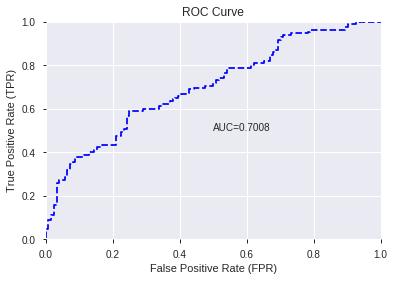

This function is available for GLM models only


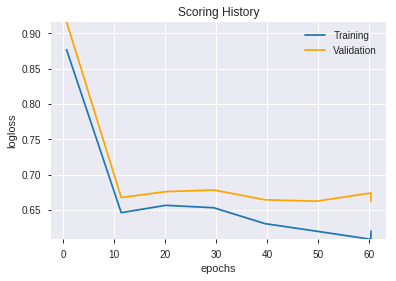

--2019-08-22 12:57:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


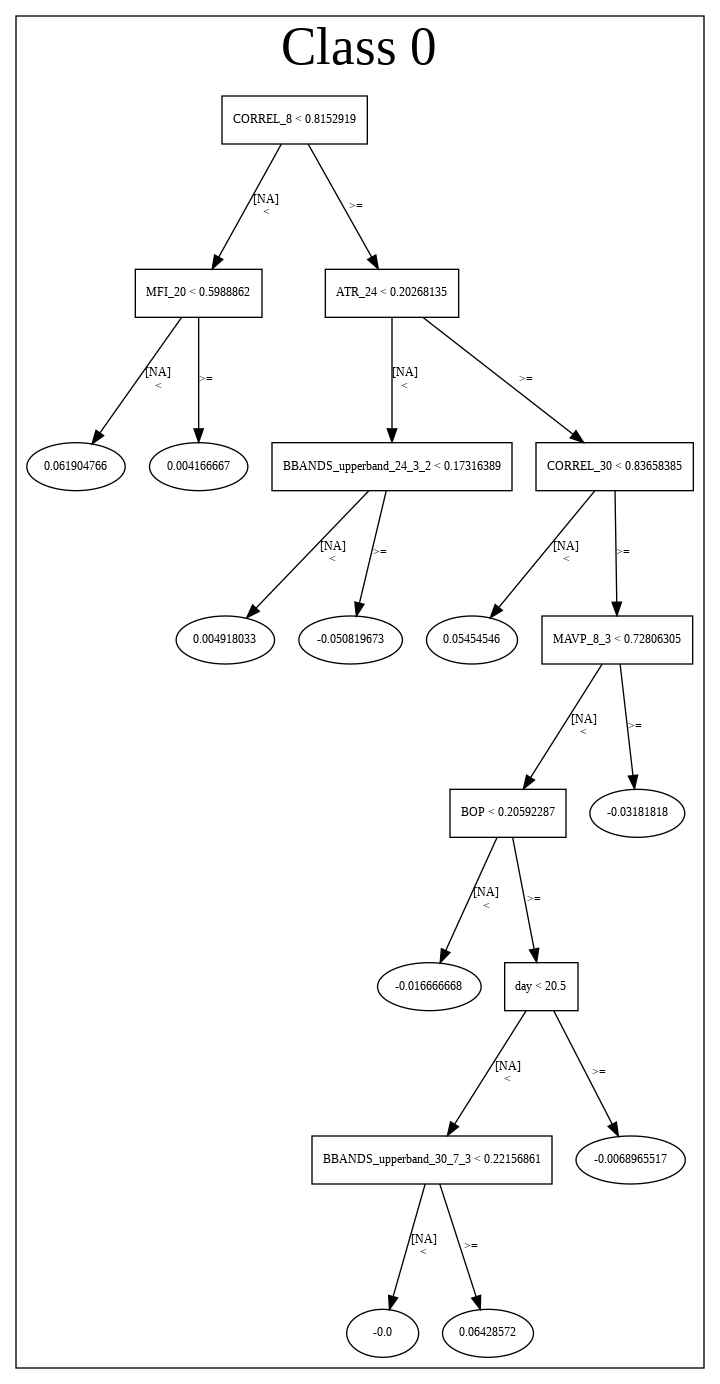

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_124637_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_124637_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'SUB',
 'VAR_12',
 'VAR_30',
 'dayofyear',
 'ULTOSC',
 'VAR_14',
 'TRANGE',
 'SAREXT',
 'CDLRICKSHAWMAN',
 'VAR_24',
 'day',
 'STOCHF_fastk',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'VAR_20',
 'VAR_8',
 'CDLMORNINGDOJISTAR',
 'WILLR_8',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLDOJI',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'HT_TRENDMODE',
 'is_quarter_end',
 'weekday_name',
 'CDLHOMINGPIGEON',
 'STOCHRSI_fastk',
 'CDLSPINNINGTOP',
 'CORREL_8',
 'is_month_end',
 'CDLTAKURI',
 'CDLSHOOTINGSTAR',
 'is_quarter_start',
 'CDLHARAMICROSS',
 'CDLCOUNTERATTACK',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDL3INSIDE',
 'CDLTASUKIGAP',
 'CORREL_30',
 'CDLHAMMER',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_125722_model_1  0.679008  0.651326              0.431452  0.479161  0.229595

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.209990           1.000000    0.087696
1                  SUB             0.156335           0.744488    0.065289
2       CDLRICKSHAWMAN             0.141611           0.674372    0.059140
3                  DIV             0.118728           0.565399    0.049584
4       STOCHRSI_fastk             0.108978           0.518967    0.045512
5    CDLINVERTEDHAMMER             0.099259           0.472682    0.041452
6    CDLGRAVESTONEDOJI             0.097480           0.464210    0.040710
7               VAR_30             0.092501           0.440501    0.038630
8               TRANGE             0.073411           0.349594    0.030658
9            dayofyear             0.062731           0.298733    0.026198
10        weekday_name             0.061604           0.293364    0.025727
11                 day             0.058708           0.279577    0.024518
12      CDLSPINNINGTOP             0.058650           0.279298    0.024493
13      is_quarter_end             0.055381           0.263733    0.023128
14        STOCHF_fastk             0.051029           0.243009    0.021311
15        is_month_end             0.047978           0.228480    0.020037
16      CDLMORNINGSTAR             0.047837           0.227807    0.019978
17     CDLLADDERBOTTOM             0.044623           0.212499    0.018635
18    CDLCOUNTERATTACK             0.044171           0.210347    0.018447
19           CORREL_30             0.044066           0.209846    0.018403
20              ULTOSC             0.043822           0.208684    0.018301
21              SAREXT             0.038998           0.185713    0.016286
22              VAR_12             0.038415           0.182939    0.016043
23           CDLTAKURI             0.035742           0.170208    0.014927
24        CDLTASUKIGAP             0.034066           0.162227    0.014227
25           CDLONNECK             0.033928           0.161571    0.014169
26             WILLR_8             0.033743           0.160689    0.014092
27   CDLLONGLEGGEDDOJI             0.033604           0.160026    0.014034
28              VAR_20             0.032672           0.155587    0.013644
29  CDLEVENINGDOJISTAR             0.032524           0.154885    0.013583
30     CDLSHOOTINGSTAR             0.031932           0.152064    0.013335
31            CORREL_8             0.030102           0.143349    0.012571
32    is_quarter_start             0.027219           0.129619    0.011367
33               VAR_8             0.026345           0.125456    0.011002
34  CDLMORNINGDOJISTAR             0.026069           0.124145    0.010887
35      CDLEVENINGSTAR             0.024072           0.114632    0.010053
36              VAR_24             0.022287           0.106133    0.009308
37          CDL3INSIDE             0.020675           0.098456    0.008634
38       days_in_month             0.020488           0.097568    0.008556
39    CDLDRAGONFLYDOJI             0.019539           0.093047    0.008160
40     CDLHOMINGPIGEON             0.019434           0.092548    0.008116
41        HT_TRENDMODE             0.018182           0.086586    0.007593
42       CDLHANGINGMAN             0.016572           0.078920    0.006921
43      CDLHARAMICROSS             0.013284           0.063259    0.005548
44              VAR_14             0.011553           0.055016    0.004825
45             CDLDOJI             0.010603           0.050494    0.004428
46           CDLHAMMER             0.009668           0.046042    0.004038
47     CDLADVANCEBLOCK             0.005043           0.024017    0.002106
48      is_month_start             0.004753           0.022634    0.001985
49      CDLMATCHINGLOW             0.004106           0.019553    0.001715

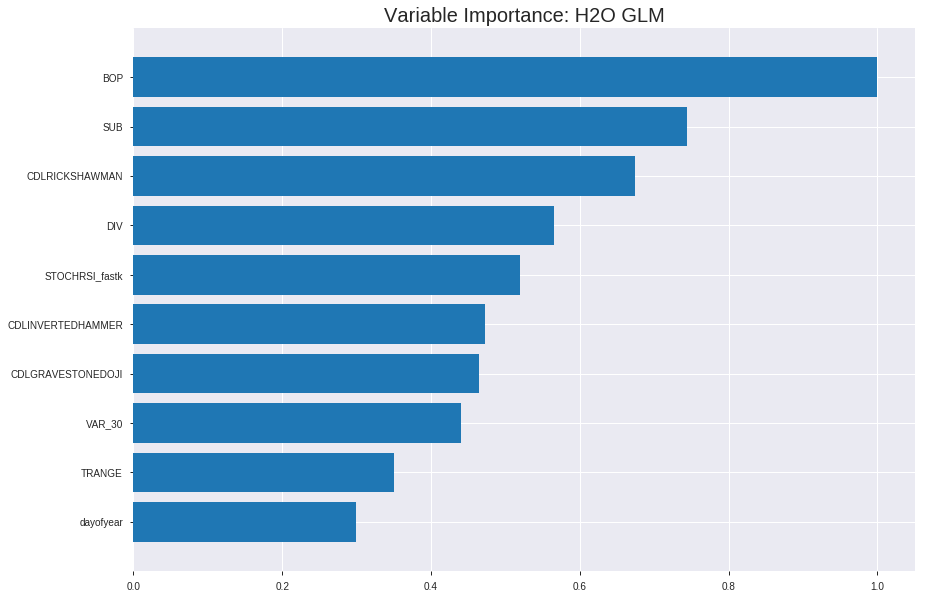

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_125722_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22996305414321638
RMSE: 0.47954463206589687
LogLoss: 0.6515057635345608
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.240311645719
Residual deviance: 2328.4815988725204
AIC: 2430.4815988725204
AUC: 0.6650808205313211
pr_auc: 0.6475884814788856
Gini: 0.33016164106264223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3937161910277249: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      224  675   0.7508   (675.0/899.0)
1      60   828   0.0676   (60.0/888.0)
Total  284  1503  0.4113   (735.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393716     0.692597  295
max f2                       0.321888     0.83492   348
max f0point5                 0.435475     0.615066  253
max accuracy                 0.435475     0.613878  253
max precision                0.750381     0.875     14
max recall                   0.199508     1         391
max specificity              0.878895     0.998888  0
max absolute_mcc             0.435475     0.256872  253
max min_per_class_accuracy   0.503015     0.609566  188
max mean_per_class_accuracy  0.435475     0.615241  253

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.748264           1.78879   1.78879            0.888889         0.790615  0.888889                    0.790615            0.018018        0.018018                   78.8789   78.8789
    2        0.0201455                   0.71418            1.34159   1.56519            0.666667         0.729819  0.777778                    0.760217            0.0135135       0.0315315                  34.1592   56.519
    3        0.0302182                   0.691114           1.78879   1.63972            0.888889         0.702481  0.814815                    0.740972            0.018018        0.0495495                  78.8789   63.9723
    4        0.040291                    0.671584           1.67699   1.64904            0.833333         0.681181  0.819444                    0.726024            0.0168919       0.0664414                  67.6989   64.904
    5        0.0503637                   0.663535           1.67699   1.65463            0.833333         0.668112  0.822222                    0.714442            0.0168919       0.0833333                  67.6989   65.463
    6        0.100168                    0.62399            1.35667   1.50648            0.674157         0.642668  0.748603                    0.678755            0.0675676       0.150901                   35.6666   50.648
    7        0.149972                    0.602533           1.33405   1.44922            0.662921         0.612613  0.720149                    0.65679             0.0664414       0.217342                   33.4055   44.9219
    8        0.200336                    0.581846           1.22979   1.39406            0.611111         0.591173  0.692737                    0.640294            0.0619369       0.279279                   22.9792   39.4056
    9        0.299944                    0.552357           1.17578   1.32157            0.58427          0.566267  0.656716                    0.615711            0.117117        0.396396                   17.5777   32.1568
    10       0.400112                    0.525679           1.07927   1.26091            0.536313         0.539146  0.626573                    0.596543            0.108108        0.504505                   7.92692   26.0908
    11       0.50028                     0.502643           1.06803   1.22229            0.530726         0.514336  0.607383                    0.580083            0.106982        0.611486                   6.80268   22.2289
    12       0.599888                    0.474496           0.960972  1.1789             0.477528         0.488394  0.585821                    0.564858            0.0957207       0.707207                   -3.90285  17.8899
    13       0.700056                    0.442023           1.04554   1.15982            0.519553         0.457874  0.576339                    0.549551            0.10473         0.811937                   4.55421   15.9817
    14       0.799664                    0.408217           0.768777  1.11111            0.382022         0.425552  0.552134                    0.534105            0.0765766       0.888514                   -23.1223  11.1108
    15       0.899832                    0.365693           0.697028  1.06501            0.346369         0.388561  0.529229                    0.517903            0.0698198       0.958333                   -30.2972  6.50135
    16       1                           1.61211e-05        0.415968  1                  0.206704         0.308445  0.496922                    0.496922            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23999149976289144
RMSE: 0.48988927296164736
LogLoss: 0.6725759471583628
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.9309586242457
Residual deviance: 686.0274661015302
AIC: 788.0274661015302
AUC: 0.6167915211739913
pr_auc: 0.579951968137969
Gini: 0.23358304234798255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4404318230207826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  159  0.6139   (159.0/259.0)
1      45   206  0.1793   (45.0/251.0)
Total  145  365  0.4      (204.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440432     0.668831  276
max f2                       0.326737     0.830013  391
max f0point5                 0.440432     0.601987  276
max accuracy                 0.440432     0.6       276
max precision                0.685792     0.875     7
max recall                   0.262531     1         398
max specificity              0.763484     0.996139  0
max absolute_mcc             0.440432     0.229215  276
max min_per_class_accuracy   0.496665     0.586873  191
max mean_per_class_accuracy  0.440432     0.603409  276

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.717935           1.69323   1.69323            0.833333         0.740783  0.833333                    0.740783            0.0199203       0.0199203                  69.3227    69.3227
    2        0.0215686                   0.681385           1.6255    1.66244            0.8              0.689324  0.818182                    0.717392            0.0159363       0.0358566                  62.5498    66.2441
    3        0.0313725                   0.663916           0.812749  1.39691            0.4              0.671485  0.6875                      0.703046            0.00796813      0.0438247                  -18.7251   39.6912
    4        0.0411765                   0.650317           0.406375  1.16107            0.2              0.654319  0.571429                    0.691445            0.00398406      0.0478088                  -59.3625   16.107
    5        0.0509804                   0.634182           1.21912   1.17223            0.6              0.644834  0.576923                    0.682481            0.0119522       0.059761                   21.9124    17.2234
    6        0.1                         0.59984            1.13785   1.15538            0.56             0.615448  0.568627                    0.649622            0.0557769       0.115538                   13.7849    15.5378
    7        0.15098                     0.57851            1.56298   1.29301            0.769231         0.588685  0.636364                    0.629046            0.0796813       0.195219                   56.2979    29.301
    8        0.2                         0.56104            0.975299  1.21514            0.48             0.568574  0.598039                    0.614224            0.0478088       0.243028                   -2.47012   21.5139
    9        0.3                         0.53447            1.19522   1.2085             0.588235         0.548731  0.594771                    0.592393            0.119522        0.36255                    19.5219    20.8499
    10       0.4                         0.512747           1.03586   1.16534            0.509804         0.524766  0.573529                    0.575486            0.103586        0.466135                   3.58566    16.5339
    11       0.5                         0.496428           1.23506   1.17928            0.607843         0.505333  0.580392                    0.561455            0.123506        0.589641                   23.506     17.9283
    12       0.6                         0.469637           0.996016  1.14874            0.490196         0.485338  0.565359                    0.548769            0.0996016       0.689243                   -0.398406  14.8738
    13       0.7                         0.444582           1.03586   1.13261            0.509804         0.455887  0.557423                    0.5355              0.103586        0.792829                   3.58566    13.2612
    14       0.8                         0.416853           0.756972  1.08566            0.372549         0.431513  0.534314                    0.522502            0.0756972       0.868526                   -24.3028   8.56574
    15       0.9                         0.384418           0.63745   1.03586            0.313725         0.399176  0.509804                    0.508799            0.063745        0.932271                   -36.255    3.58566
    16       1                           0.0340871          0.677291  1                  0.333333         0.346224  0.492157                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:57:22  0.000 sec   2            6.8       51            1.37854           1.38068
    2019-08-22 12:57:22  0.011 sec   4            4.2       51            1.37455           1.37787
    2019-08-22 12:57:22  0.022 sec   6            2.6       51            1.36897           1.37399
    2019-08-22 12:57:22  0.035 sec   8            1.6       51            1.3616            1.36899
    2019-08-22 12:57:22  0.046 sec   10           1         51            1.35246           1.3631
    2019-08-22 12:57:22  0.057 sec   12           0.63      51            1.34195           1.35693
    2019-08-22 12:57:22  0.071 sec   14           0.39      51            1.33083           1.35135
    2019-08-22 12:57:22  0.082 sec   16           0.24      51            1.32013           1.34725
    2019-08-22 12:57:22  0.095 sec   18           0.15      51            1.3107            1.34517
    2019-08-22 12:57:22  0.116 sec   20           0.093     51            1.30301           1.34515
    2019-08-22 12:57:22  0.131 sec   22           0.058     51            1.29702           1.34676
    2019-08-22 12:57:22  0.143 sec   24           0.036     51            1.29237           1.34942
    2019-08-22 12:57:22  0.161 sec   26           0.022     51            1.28871           1.35263
    2019-08-22 12:57:22  0.173 sec   28           0.014     51            1.2858            1.3561
    2019-08-22 12:57:22  0.188 sec   30           0.0086    51            1.28356           1.35965

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6484375)

('F1', 0.711590296495957)

('auc', 0.6790078201368525)

('logloss', 0.6513258111693099)

('mean_per_class_error', 0.34872922776148585)

('rmse', 0.47916071651616876)

('mse', 0.22959499225228824)

glm prediction progress: |████████████████████████████████████████████████| 100%


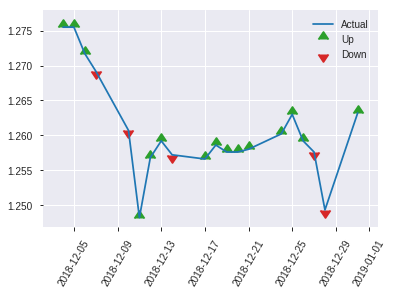


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22959499225228824
RMSE: 0.47916071651616876
LogLoss: 0.6513258111693099
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.999547062732
Residual deviance: 333.47881531868666
AIC: 435.47881531868666
AUC: 0.6790078201368525
pr_auc: 0.67370085409221
Gini: 0.3580156402737049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37734999644966316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   107  0.8629   (107.0/124.0)
1      0    132  0        (0.0/132.0)
Total  17   239  0.418    (107.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37735      0.71159   238
max f2                       0.37735      0.860495  238
max f0point5                 0.53589      0.665468  105
max accuracy                 0.53589      0.648438  105
max precision                0.728047     1         0
max recall                   0.37735      1         238
max specificity              0.728047     1         0
max absolute_mcc             0.53589      0.306962  105
max min_per_class_accuracy   0.517161     0.621212  127
max mean_per_class_accuracy  0.53589      0.651271  105

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.680918           1.93939   1.93939            1                0.702102  1                           0.702102            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.672282           0.646465  1.29293            0.333333         0.676649  0.666667                    0.689375            0.00757576      0.030303                   -35.3535  29.2929
    3        0.03125                     0.664466           1.93939   1.45455            1                0.669765  0.75                        0.684473            0.0151515       0.0454545                  93.9394   45.4545
    4        0.0429688                   0.655617           1.29293   1.41047            0.666667         0.658351  0.727273                    0.677349            0.0151515       0.0606061                  29.2929   41.0468
    5        0.0507812                   0.652871           1.93939   1.49184            1                0.653433  0.769231                    0.673669            0.0151515       0.0757576                  93.9394   49.1841
    6        0.101562                    0.61921            1.49184   1.49184            0.769231         0.630507  0.769231                    0.652088            0.0757576       0.151515                   49.1841   49.1841
    7        0.152344                    0.601402           1.49184   1.49184            0.769231         0.61096   0.769231                    0.638379            0.0757576       0.227273                   49.1841   49.1841
    8        0.203125                    0.586296           1.19347   1.41725            0.615385         0.593881  0.730769                    0.627254            0.0606061       0.287879                   19.3473   41.7249
    9        0.300781                    0.560591           1.24121   1.36009            0.64             0.572994  0.701299                    0.609637            0.121212        0.409091                   24.1212   36.0094
    10       0.402344                    0.538108           1.34266   1.35569            0.692308         0.548571  0.699029                    0.594222            0.136364        0.545455                   34.2657   35.5693
    11       0.5                         0.514315           0.775758  1.24242            0.4              0.527425  0.640625                    0.581176            0.0757576       0.621212                   -22.4242  24.2424
    12       0.601562                    0.495393           0.820513  1.17119            0.423077         0.502826  0.603896                    0.567948            0.0833333       0.704545                   -17.9487  17.1192
    13       0.699219                    0.465903           0.930909  1.13763            0.48             0.481054  0.586592                    0.555812            0.0909091       0.795455                   -6.90909  13.7633
    14       0.800781                    0.43439            0.969697  1.11633            0.5              0.449361  0.57561                     0.542311            0.0984848       0.893939                   -3.0303   11.6334
    15       0.898438                    0.392131           0.698182  1.07088            0.36             0.4121    0.552174                    0.528157            0.0681818       0.962121                   -30.1818  7.08827
    16       1                           0.256802           0.37296   1                  0.192308         0.362101  0.515625                    0.511292         

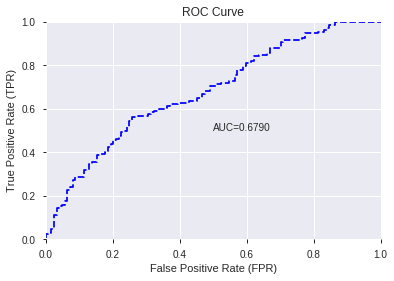

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


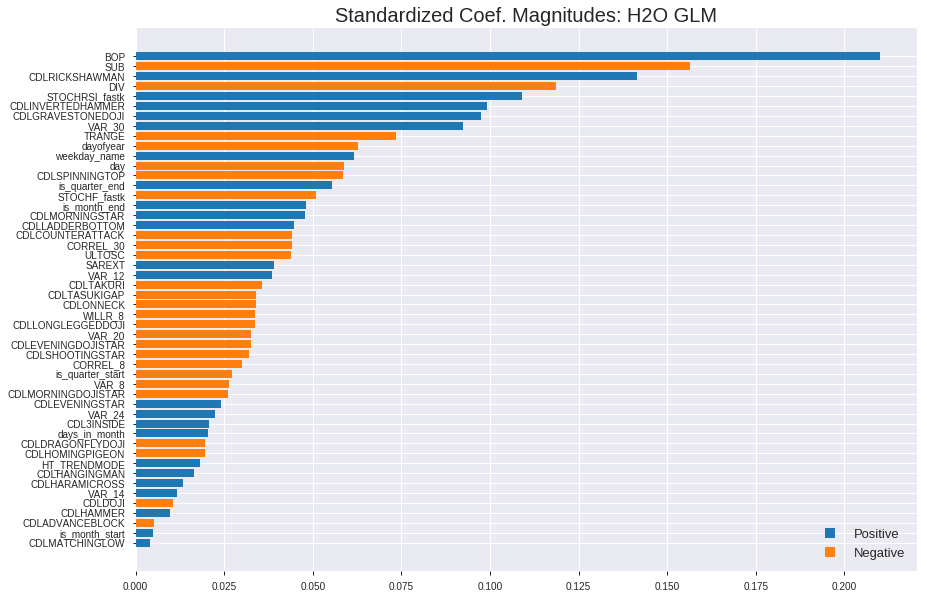

'log_likelihood'
--2019-08-22 12:57:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


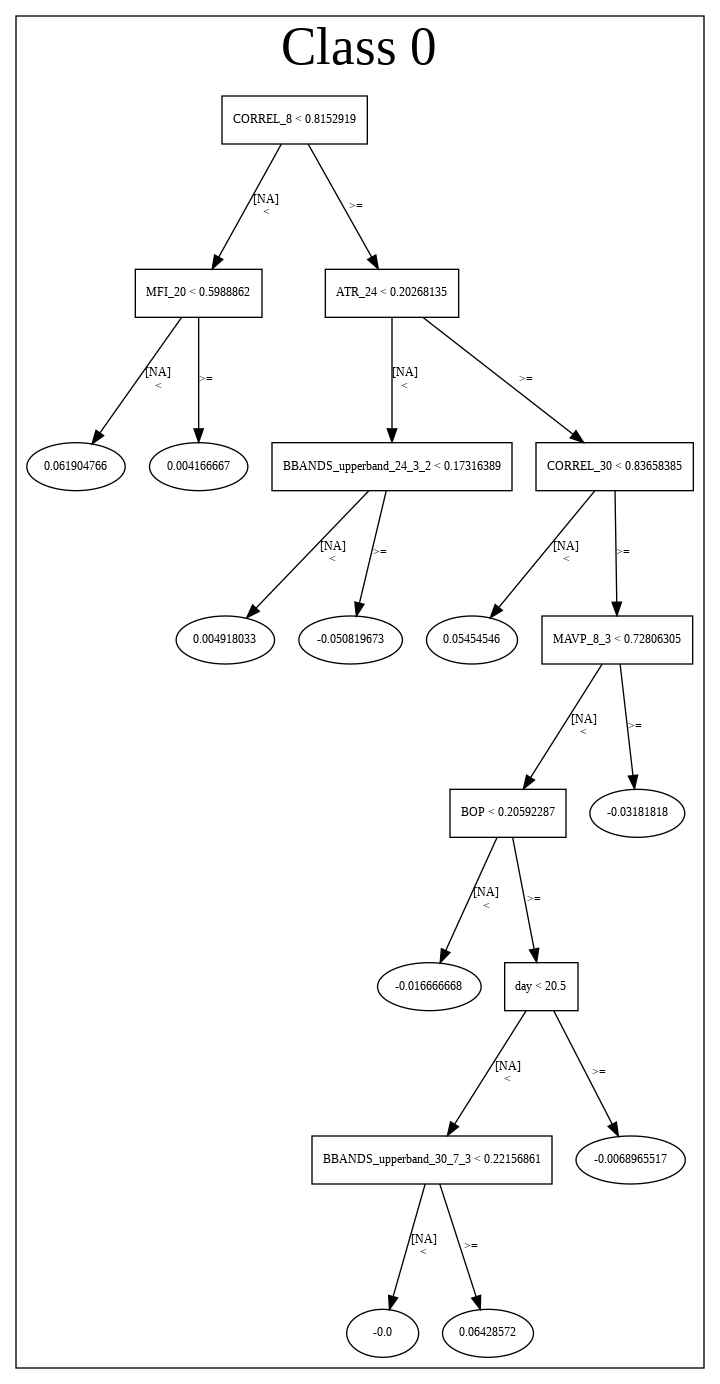

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_125722_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_125722_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SUB',
 'CDLRICKSHAWMAN',
 'DIV',
 'STOCHRSI_fastk',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'VAR_30',
 'TRANGE',
 'dayofyear',
 'weekday_name',
 'day',
 'CDLSPINNINGTOP',
 'is_quarter_end',
 'STOCHF_fastk',
 'is_month_end',
 'CDLMORNINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLCOUNTERATTACK',
 'CORREL_30',
 'ULTOSC',
 'SAREXT',
 'VAR_12',
 'CDLTAKURI',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'WILLR_8',
 'CDLLONGLEGGEDDOJI',
 'VAR_20',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CORREL_8',
 'is_quarter_start',
 'VAR_8',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'VAR_24',
 'CDL3INSIDE',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'VAR_14',
 'CDLDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMATCHINGLOW']

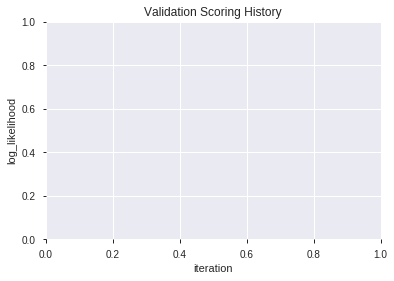

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_125734  0.693793  0.642549              0.451613  0.474948  0.225576
1  XGBoost_grid_1_AutoML_20190822_125734_model_2  0.674731  0.649573              0.401515  0.478409  0.228875
2  XGBoost_grid_1_AutoML_20190822_125734_model_4  0.673937  0.652821              0.422654  0.480160  0.230553
3               XGBoost_3_AutoML_20190822_125734  0.658297  0.653907              0.417644  0.480820  0.231188
4  XGBoost_grid_1_AutoML_20190822_125734_model_5  0.652004  0.654513              0.459433  0.481868  0.232197
5  XGBoost_grid_1_AutoML_20190822_125734_model_1  0.651393  0.655649              0.467498  0.481803  0.232134
6  XGBoost_grid_1_AutoML_20190822_125734_model_7  0.631415  0.664071              0.438050  0.485793  0.235995
7  XGBoost_grid_1_AutoML_20190822_125734_model_3  0.622251  0.672532              0.479594  0.489826  0.239930
8               XGBoost_2_AutoML_20190822_125734  0.618707  0.669541              0.447092  0.488516  0.238648
9  XGBoost_grid_1_AutoML_20190822_125734_model_6  0.613392  0.667315              0.442082  0.487600  0.237753

variable  relative_importance  scaled_importance  percentage
0                 BOP           636.654846           1.000000    0.087289
1                 DIV           490.046753           0.769721    0.067188
2              ULTOSC           436.894379           0.686234    0.059901
3              SAREXT           405.734711           0.637291    0.055629
4           dayofyear           405.530273           0.636970    0.055601
5              VAR_14           388.643799           0.610447    0.053285
6              VAR_30           383.246918           0.601970    0.052545
7              TRANGE           357.494507           0.561520    0.049015
8               VAR_8           357.385071           0.561348    0.049000
9            CORREL_8           346.723206           0.544602    0.047538
10                SUB           340.163879           0.534299    0.046639
11          CORREL_30           331.717407           0.521032    0.045480
12             VAR_20           312.894440           0.491466    0.042900
13             VAR_12           291.660553           0.458114    0.039988
14                day           260.417145           0.409040    0.035705
15       STOCHF_fastk           252.736664           0.396976    0.034652
16     STOCHRSI_fastk           250.620651           0.393652    0.034362
17            WILLR_8           234.394638           0.368166    0.032137
18             VAR_24           227.372009           0.357135    0.031174
19       weekday_name           137.428070           0.215860    0.018842
20     CDLRICKSHAWMAN            99.026840           0.155542    0.013577
21     CDLSPINNINGTOP            77.395157           0.121565    0.010611
22  CDLGRAVESTONEDOJI            76.117157           0.119558    0.010436
23      days_in_month            51.162468           0.080361    0.007015
24  CDLINVERTEDHAMMER            45.118328           0.070868    0.006186
25       HT_TRENDMODE            34.039742           0.053467    0.004667
26   CDLDRAGONFLYDOJI            20.391161           0.032029    0.002796
27  CDLLONGLEGGEDDOJI            18.317484           0.028771    0.002511
28            CDLDOJI            15.688972           0.024643    0.002151
29          CDLTAKURI             8.607594           0.013520    0.001180

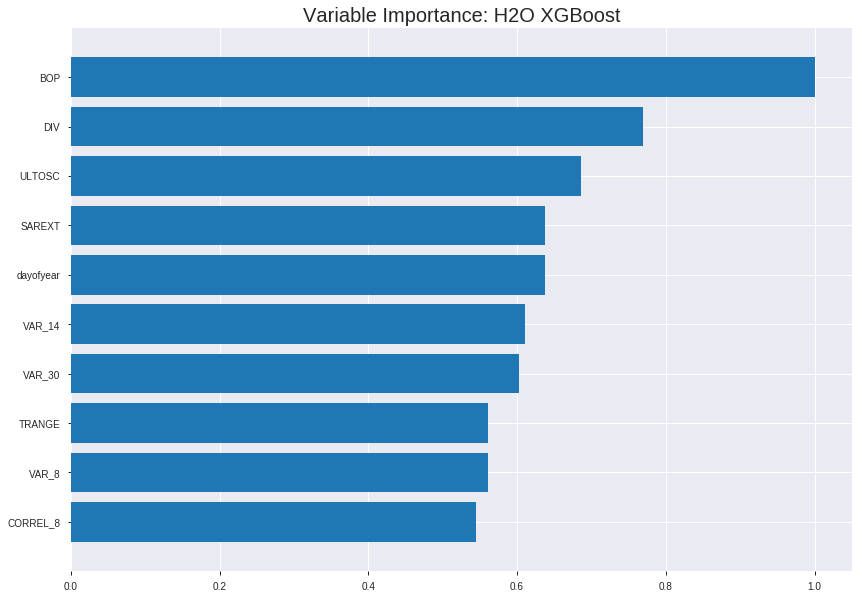

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_125734


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15342149011633013
RMSE: 0.3916905540300023
LogLoss: 0.4883278199279391
Mean Per-Class Error: 0.13484389561975774
AUC: 0.9383768501538245
pr_auc: 0.9407997387119026
Gini: 0.8767537003076491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4965781271457672: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  143  0.1591   (143.0/899.0)
1      100  788  0.1126   (100.0/888.0)
Total  856  931  0.136    (243.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496578     0.86641   199
max f2                       0.415726     0.903056  252
max f0point5                 0.560167     0.886076  157
max accuracy                 0.513012     0.865137  187
max precision                0.869225     1         0
max recall                   0.263514     1         346
max specificity              0.869225     1         0
max absolute_mcc             0.507449     0.730299  191
max min_per_class_accuracy   0.509274     0.862613  190
max mean_per_class_accuracy  0.507449     0.865156  191

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.792356           2.01239    2.01239            1                0.8112    1                           0.8112              0.0202703       0.0202703                  101.239   101.239
    2        0.0201455                   0.771446           2.01239    2.01239            1                0.782666  1                           0.796933            0.0202703       0.0405405                  101.239   101.239
    3        0.0302182                   0.762268           2.01239    2.01239            1                0.766594  1                           0.78682             0.0202703       0.0608108                  101.239   101.239
    4        0.040291                    0.750208           2.01239    2.01239            1                0.756566  1                           0.779257            0.0202703       0.0810811                  101.239   101.239
    5        0.0503637                   0.741153           2.01239    2.01239            1                0.744917  1                           0.772389            0.0202703       0.101351                   101.239   101.239
    6        0.100168                    0.705008           2.01239    2.01239            1                0.721961  1                           0.747316            0.100225        0.201577                   101.239   101.239
    7        0.149972                    0.681664           1.98978    2.00488            0.988764         0.692921  0.996269                    0.729252            0.0990991       0.300676                   98.9776   100.488
    8        0.200336                    0.661691           1.92295    1.98428            0.955556         0.672296  0.986034                    0.714933            0.0968468       0.397523                   92.2948   98.4281
    9        0.299944                    0.613074           1.88803    1.95232            0.938202         0.635658  0.970149                    0.688607            0.188063        0.585586                   88.8026   95.2316
    10       0.400112                    0.562695           1.59642    1.86322            0.793296         0.58726   0.925874                    0.663235            0.15991         0.745495                   59.6419   86.3217
    11       0.50028                     0.507146           1.22542    1.73552            0.608939         0.534739  0.862416                    0.637507            0.122748        0.868243                   22.542    73.5515
    12       0.599888                    0.452034           0.644416   1.55434            0.320225         0.479954  0.772388                    0.611346            0.0641892       0.932432                   -35.5584  55.4344
    13       0.700056                    0.395896           0.393484   1.38824            0.195531         0.424005  0.689848                    0.58454             0.0394144       0.971847                   -60.6516  38.8242
    14       0.799664                    0.331782           0.214805   1.24208            0.106742         0.364021  0.617215                    0.557072            0.0213964       0.993243                   -78.5195  24.2075
    15       0.899832                    0.265005           0.0562119  1.11007            0.027933         0.298713  0.551617                    0.528312            0.00563063      0.998874                   -94.3788  11.0067
    16       1                           0.113735           0.0112424  1                  0.00558659       0.210065  0.496922                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24450667507986604
RMSE: 0.4944761622968958
LogLoss: 0.6829572262426036
Mean Per-Class Error: 0.4097125013459675
AUC: 0.6008014274946546
pr_auc: 0.5588567854666501
Gini: 0.2016028549893092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28133663535118103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   241  0.9305   (241.0/259.0)
1      5    246  0.0199   (5.0/251.0)
Total  23   487  0.4824   (246.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281337     0.666667  377
max f2                       0.198941     0.831677  395
max f0point5                 0.471138     0.589577  241
max accuracy                 0.471138     0.588235  241
max precision                0.635124     0.634146  70
max recall                   0.198941     1         395
max specificity              0.800157     0.996139  0
max absolute_mcc             0.471138     0.186922  241
max min_per_class_accuracy   0.525725     0.563707  190
max mean_per_class_accuracy  0.471138     0.590287  241

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.759339           0.338645  0.338645           0.166667         0.784019  0.166667                    0.784019            0.00398406      0.00398406                 -66.1355  -66.1355
    2        0.0215686                   0.724032           1.6255    0.923578           0.8              0.735293  0.454545                    0.761871            0.0159363       0.0199203                  62.5498   -7.64216
    3        0.0313725                   0.711399           1.6255    1.14293            0.8              0.717868  0.5625                      0.74812             0.0159363       0.0358566                  62.5498   14.2928
    4        0.0411765                   0.705507           1.6255    1.25783            0.8              0.709384  0.619048                    0.738897            0.0159363       0.0517928                  62.5498   25.7826
    5        0.0509804                   0.692078           0.406375  1.09409            0.2              0.697888  0.538462                    0.731011            0.00398406      0.0557769                  -59.3625  9.40852
    6        0.1                         0.666128           1.38167   1.23506            0.68             0.677864  0.607843                    0.704958            0.0677291       0.123506                   38.1673   23.506
    7        0.15098                     0.641174           1.25038   1.24023            0.615385         0.653055  0.61039                     0.687432            0.063745        0.187251                   25.0383   24.0234
    8        0.2                         0.618493           1.05657   1.19522            0.52             0.62839   0.588235                    0.672961            0.0517928       0.239044                   5.65737   19.5219
    9        0.3                         0.587826           1.15538   1.18194            0.568627         0.602992  0.581699                    0.649638            0.115538        0.354582                   15.5378   18.1939
    10       0.4                         0.55256            1.15538   1.1753             0.568627         0.570287  0.578431                    0.6298              0.115538        0.47012                    15.5378   17.5299
    11       0.5                         0.524998           0.956175  1.13147            0.470588         0.537903  0.556863                    0.611421            0.0956175       0.565737                   -4.38247  13.1474
    12       0.6                         0.483097           1.19522   1.1421             0.588235         0.504269  0.562092                    0.593562            0.119522        0.685259                   19.5219   14.2098
    13       0.7                         0.443822           0.916335  1.10985            0.45098          0.464124  0.546218                    0.575071            0.0916335       0.776892                   -8.36653  10.9846
    14       0.8                         0.392743           0.876494  1.08068            0.431373         0.42003   0.531863                    0.555691            0.0876494       0.864542                   -12.3506  8.06773
    15       0.9                         0.321723           0.557769  1.02258            0.27451          0.361071  0.503268                    0.534066            0.0557769       0.920319                   -44.2231  2.25764
    16       1                           0.171398           0.796813  1                  0.392157         0.271247  0.492157                    0.507785        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:57:35  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.503078                         0.5                0.693147              0.5               0                    1                  0.507843
    2019-08-22 12:57:35  0.114 sec   5                  0.482108         0.657878            0.815571        0.801643           2.01239          0.272524                         0.49541            0.68398               0.600832          0.554577             0.580535           0.478431
    2019-08-22 12:57:35  0.182 sec   10                 0.466156         0.627087            0.85627         0.847241           2.01239          0.229994                         0.493133           0.679371              0.600109          0.551587             0.677291           0.468627
    2019-08-22 12:57:35  0.258 sec   15                 0.453972         0.60385             0.870128        0.864009           2.01239          0.22272                          0.492886           0.67886               0.597179          0.54659              0.338645           0.480392
    2019-08-22 12:57:35  0.327 sec   20                 0.442444         0.581995            0.885259        0.879217           2.01239          0.209289                         0.494239           0.681626              0.587849          0.538197             0.338645           0.478431
    2019-08-22 12:57:35  0.391 sec   25                 0.433094         0.564384            0.897008        0.897763           2.01239          0.199217                         0.49492            0.683012              0.585434          0.543606             0.677291           0.492157
    2019-08-22 12:57:35  0.462 sec   30                 0.423771         0.546868            0.903749        0.902498           2.01239          0.189144                         0.494231           0.681759              0.59238           0.54901              1.01594            0.492157
    2019-08-22 12:57:35  0.550 sec   35                 0.41469          0.530117            0.914272        0.91648            2.01239          0.172356                         0.493939           0.681363              0.595079          0.549672             0.677291           0.490196
    2019-08-22 12:57:35  0.628 sec   40                 0.406217         0.514683            0.924356        0.927659           2.01239          0.161164                         0.493348           0.680288              0.601317          0.555795             0.338645           0.480392
    2019-08-22 12:57:35  0.699 sec   45                 0.399025         0.501586            0.931531        0.934555           2.01239          0.142138                         0.494779           0.683426              0.596487          0.551479             0.338645           0.476471
    2019-08-22 12:57:35  0.770 sec   50                 0.391691         0.488328            0.938377        0.9408             2.01239          0.135982                         0.494476           0.682957              0.600801          0.558857             0.338645           0.482353

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                636.6548461914062      1.0                   0.08728922336400802
DIV                490.0467529296875      0.7697212325661903    0.06718836859748974
ULTOSC             436.8943786621094      0.6862342779226405    0.05990085716562812
SAREXT             405.7347106933594      0.6372914823794145    0.05562867855339648
dayofyear          405.5302734375         0.6369703707801195    0.05560064897128086
---                ---                    ---                   ---
HT_TRENDMODE       34.03974151611328      0.05346655526105812   0.00466705408468658
CDLDRAGONFLYDOJI   20.39116096496582      0.032028596164703264  0.0027957512846563935
CDLLONGLEGGEDDOJI  18.31748390197754      0.02877145129979974   0.0025114376390148983
CDLDOJI            15.688972473144531     0.024642822664429607  0.002151052851875035
CDLTAKURI          8.60759449005127       0.013520032937067208  0.001180153174932405


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66015625)

('F1', 0.7021276595744682)

('auc', 0.6937927663734116)

('logloss', 0.6425491578216956)

('mean_per_class_error', 0.3351661779081134)

('rmse', 0.4749482322748231)

('mse', 0.22557582334097928)

xgboost prediction progress: |████████████████████████████████████████████| 100%


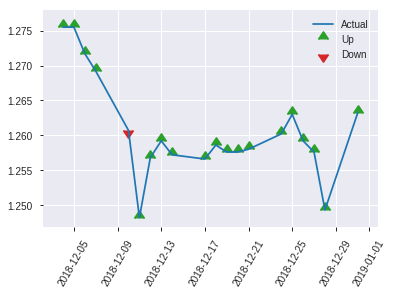


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22557582334097928
RMSE: 0.4749482322748231
LogLoss: 0.6425491578216956
Mean Per-Class Error: 0.3351661779081134
AUC: 0.6937927663734116
pr_auc: 0.6836437240285722
Gini: 0.38758553274682317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2814275324344635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   112  0.9032   (112.0/124.0)
1      0    132  0        (0.0/132.0)
Total  12   244  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281428     0.702128  243
max f2                       0.281428     0.854922  243
max f0point5                 0.579302     0.685841  79
max accuracy                 0.568806     0.660156  90
max precision                0.648435     0.833333  29
max recall                   0.281428     1         243
max specificity              0.800551     0.991935  0
max absolute_mcc             0.579302     0.349912  79
max min_per_class_accuracy   0.535227     0.613636  123
max mean_per_class_accuracy  0.568806     0.664834  90

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.726371           0.646465  0.646465           0.333333         0.759234  0.333333                    0.759234            0.00757576      0.00757576                 -35.3535  -35.3535
    2        0.0234375                   0.710035           1.29293   0.969697           0.666667         0.717089  0.5                         0.738162            0.0151515       0.0227273                  29.2929   -3.0303
    3        0.03125                     0.701843           1.93939   1.21212            1                0.703227  0.625                       0.729428            0.0151515       0.0378788                  93.9394   21.2121
    4        0.0429688                   0.693711           1.93939   1.41047            1                0.698594  0.727273                    0.721019            0.0227273       0.0606061                  93.9394   41.0468
    5        0.0507812                   0.682941           0.969697  1.34266            0.5              0.687747  0.692308                    0.7159              0.00757576      0.0681818                  -3.0303   34.2657
    6        0.101562                    0.656634           1.79021   1.56643            0.923077         0.67165   0.807692                    0.693775            0.0909091       0.159091                   79.021    56.6434
    7        0.152344                    0.630118           1.49184   1.54157            0.769231         0.641522  0.794872                    0.676357            0.0757576       0.234848                   49.1841   54.157
    8        0.203125                    0.615344           1.49184   1.52914            0.769231         0.62196   0.788462                    0.662758            0.0757576       0.310606                   49.1841   52.9138
    9        0.300781                    0.583626           1.39636   1.48603            0.72             0.598306  0.766234                    0.641832            0.136364        0.44697                    39.6364   48.6029
    10       0.402344                    0.555924           0.969697  1.35569            0.5              0.569616  0.699029                    0.623603            0.0984848       0.545455                   -3.0303   35.5693
    11       0.5                         0.531424           0.698182  1.22727            0.36             0.543467  0.632812                    0.607951            0.0681818       0.613636                   -30.1818  22.7273
    12       0.601562                    0.501238           1.19347   1.22157            0.615385         0.515613  0.62987                     0.592362            0.121212        0.734848                   19.3473   22.1566
    13       0.699219                    0.463385           0.698182  1.14847            0.36             0.482979  0.592179                    0.577085            0.0681818       0.80303                    -30.1818  14.8468
    14       0.800781                    0.401912           0.671329  1.08795            0.346154         0.427613  0.560976                    0.558127            0.0681818       0.871212                   -32.8671  8.79527
    15       0.898438                    0.335928           0.698182  1.04559            0.36             0.376454  0.53913                     0.53838             0.0681818       0.939394                   -30.1818  4.55863
    16       1                           0.158968           0.596737  1                  0.307692         0.276184  0.515625                    0.511751         

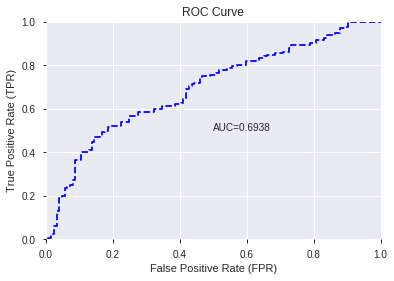

This function is available for GLM models only


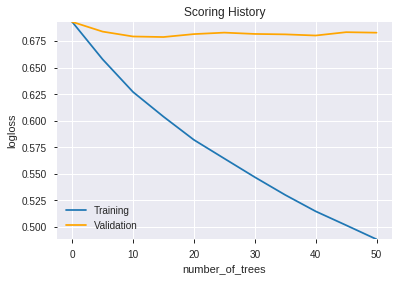

--2019-08-22 12:57:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

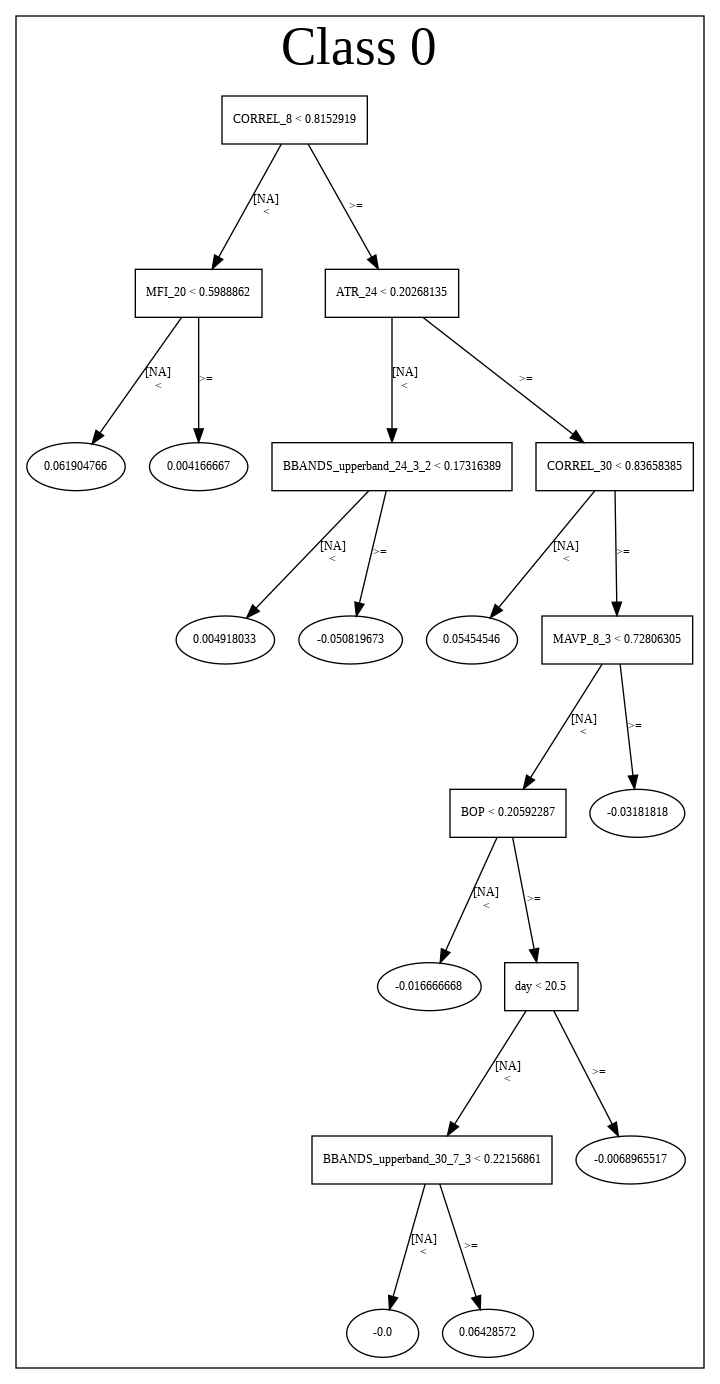

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_125734',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_125734',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_b408',
   'type

['BOP',
 'DIV',
 'ULTOSC',
 'SAREXT',
 'dayofyear',
 'VAR_14',
 'VAR_30',
 'TRANGE',
 'VAR_8',
 'CORREL_8',
 'SUB',
 'CORREL_30',
 'VAR_20',
 'VAR_12',
 'day',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'VAR_24',
 'weekday_name',
 'CDLRICKSHAWMAN',
 'CDLSPINNINGTOP',
 'CDLGRAVESTONEDOJI',
 'days_in_month',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLTAKURI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

4

['BOP', 'CCI_8', 'CDLGRAVESTONEDOJI', 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125756_model_4  0.692326  0.650929              0.355694  0.479071  0.229509
1  DeepLearning_grid_1_AutoML_20190822_125756_model_7  0.689516  0.669059              0.356427  0.488120  0.238261
2  DeepLearning_grid_1_AutoML_20190822_125756_model_6  0.687256  0.663319              0.352151  0.485220  0.235439
3  DeepLearning_grid_1_AutoML_20190822_125756_model_5  0.681635  0.669273              0.380865  0.488343  0.238479
4  DeepLearning_grid_1_AutoML_20190822_125756_model_3  0.677725  0.657872              0.357771  0.482940  0.233231
5  DeepLearning_grid_1_AutoML_20190822_125756_model_1  0.660007  0.672630              0.434751  0.488044  0.238187
6  DeepLearning_grid_1_AutoML_20190822_125756_model_2  0.656403  0.665062              0.438783  0.486218  0.236408
7               DeepLearning_1_AutoML_20190822_125756  0.573253  0.698398              0.451369  0.502645  0.252652

variable  relative_importance  scaled_importance  percentage
0                SUB             1.000000           1.000000    0.303036
1  CDLGRAVESTONEDOJI             0.994840           0.994840    0.301473
2                BOP             0.896370           0.896370    0.271633
3              CCI_8             0.408725           0.408725    0.123858

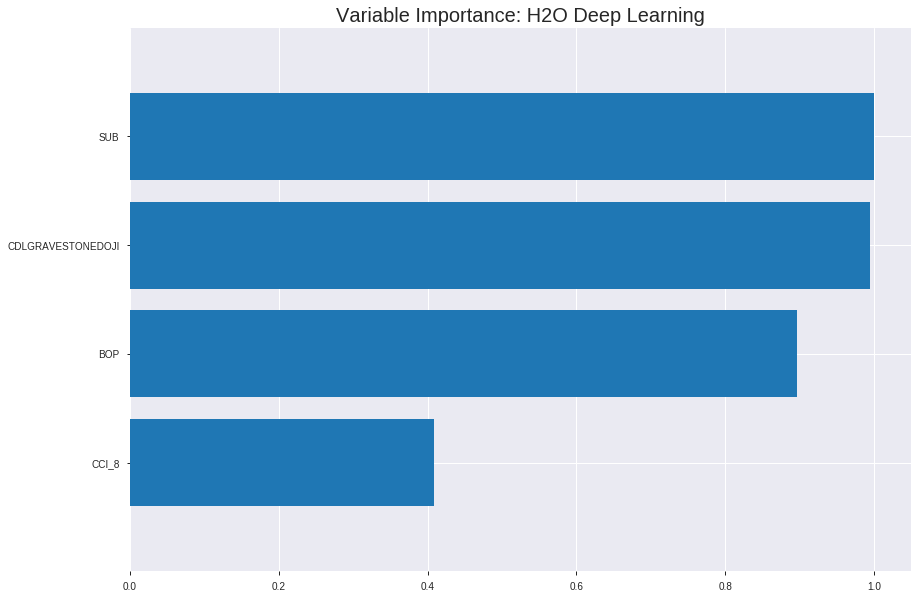

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125756_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23574397100189196
RMSE: 0.4855347268753204
LogLoss: 0.6629793989510671
Mean Per-Class Error: 0.3889932758119632
AUC: 0.6454995039533415
pr_auc: 0.6209359311436943
Gini: 0.2909990079066831
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2585165505485035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      104  795   0.8843   (795.0/899.0)
1      19   869   0.0214   (19.0/888.0)
Total  123  1664  0.4555   (814.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258517     0.681034  340
max f2                       0.236169     0.837143  352
max f0point5                 0.427932     0.608705  211
max accuracy                 0.448328     0.61108   194
max precision                0.720277     0.769231  10
max recall                   0.0744235    1         394
max specificity              0.82418      0.998888  0
max absolute_mcc             0.448328     0.222084  194
max min_per_class_accuracy   0.443891     0.608108  198
max mean_per_class_accuracy  0.447016     0.611007  195

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 44.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.712511           1.45339   1.45339            0.722222         0.745654  0.722222                    0.745654            0.0146396       0.0146396                  45.3391   45.3391
    2        0.0201455                   0.67909            1.34159   1.39749            0.666667         0.694747  0.694444                    0.720201            0.0135135       0.0281532                  34.1592   39.7491
    3        0.0302182                   0.662645           1.56519   1.45339            0.777778         0.668095  0.722222                    0.702832            0.0157658       0.0439189                  56.519    45.3391
    4        0.040291                    0.646803           1.45339   1.45339            0.722222         0.655813  0.722222                    0.691077            0.0146396       0.0585586                  45.3391   45.3391
    5        0.0503637                   0.635761           1.56519   1.47575            0.777778         0.640872  0.733333                    0.681036            0.0157658       0.0743243                  56.519    47.5751
    6        0.100168                    0.601296           1.33405   1.4053             0.662921         0.615741  0.698324                    0.648571            0.0664414       0.140766                   33.4055   40.5298
    7        0.149972                    0.577229           1.4245    1.41167            0.707865         0.589472  0.701493                    0.628945            0.0709459       0.211712                   42.4499   41.1675
    8        0.200336                    0.557911           1.22979   1.36595            0.611111         0.568445  0.678771                    0.613735            0.0619369       0.273649                   22.9792   36.595
    9        0.299944                    0.521009           1.06272   1.26525            0.52809          0.540335  0.628731                    0.58936             0.105856        0.379505                   6.27214   26.5251
    10       0.400112                    0.481223           1.14672   1.23558            0.569832         0.501865  0.613986                    0.567455            0.114865        0.494369                   14.6724   23.5578
    11       0.50028                     0.442916           1.14672   1.21779            0.569832         0.460515  0.605145                    0.546043            0.114865        0.609234                   14.6724   21.7787
    12       0.599888                    0.410049           0.949666  1.17327            0.47191          0.425213  0.583022                    0.52598             0.0945946       0.703829                   -5.0334   17.3267
    13       0.700056                    0.379754           0.955603  1.14212            0.47486          0.395056  0.567546                    0.507247            0.0957207       0.79955                    -4.43971  14.2122
    14       0.799664                    0.346151           0.768777  1.09562            0.382022         0.363804  0.544437                    0.489379            0.0765766       0.876126                   -23.1223  9.56175
    15       0.899832                    0.292243           0.75324   1.0575             0.374302         0.322421  0.525498                    0.470794            0.0754505       0.951577                   -24.676   5.75046
    16       1                           0.025238           0.483423  1                  0.240223         0.213848  0.496922                    0.445056          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23859836519599703
RMSE: 0.48846531626718087
LogLoss: 0.66973167579518
Mean Per-Class Error: 0.3923764401852051
AUC: 0.630758818009814
pr_auc: 0.6307700726524754
Gini: 0.2615176360196281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32439986027169243: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      34   225  0.8687   (225.0/259.0)
1      11   240  0.0438   (11.0/251.0)
Total  45   465  0.4627   (236.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3244       0.670391  358
max f2                       0.228934     0.830576  396
max f0point5                 0.456703     0.601291  193
max accuracy                 0.45805      0.607843  189
max precision                0.604978     0.956522  21
max recall                   0.228934     1         396
max specificity              0.699924     0.996139  0
max absolute_mcc             0.53366      0.219876  80
max min_per_class_accuracy   0.453282     0.594595  199
max mean_per_class_accuracy  0.456703     0.607624  193

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.634767           1.69323   1.69323            0.833333         0.670339  0.833333                    0.670339            0.0199203       0.0199203                  69.3227    69.3227
    2        0.0215686                   0.61935            2.03187   1.84716            1                0.626895  0.909091                    0.650592            0.0199203       0.0398406                  103.187    84.7157
    3        0.0313725                   0.612113           2.03187   1.90488            1                0.615092  0.9375                      0.639498            0.0199203       0.059761                   103.187    90.488
    4        0.0411765                   0.605508           2.03187   1.93512            1                0.608348  0.952381                    0.632081            0.0199203       0.0796813                  103.187    93.5117
    5        0.0509804                   0.600075           1.21912   1.79743            0.6              0.602885  0.884615                    0.626467            0.0119522       0.0916335                  21.9124    79.7426
    6        0.1                         0.571929           0.975299  1.39442            0.48             0.584823  0.686275                    0.606053            0.0478088       0.139442                   -2.47012   39.4422
    7        0.15098                     0.546933           1.56298   1.45134            0.769231         0.559434  0.714286                    0.590311            0.0796813       0.219124                   56.2979    45.1338
    8        0.2                         0.529739           1.13785   1.3745             0.56             0.537635  0.676471                    0.577401            0.0557769       0.2749                     13.7849    37.4502
    9        0.3                         0.503463           1.03586   1.26162            0.509804         0.516975  0.620915                    0.557259            0.103586        0.378486                   3.58566    26.162
    10       0.4                         0.476391           1.19522   1.24502            0.588235         0.489496  0.612745                    0.540318            0.119522        0.498008                   19.5219    24.502
    11       0.5                         0.452884           0.996016  1.19522            0.490196         0.464295  0.588235                    0.525113            0.0996016       0.59761                    -0.398406  19.5219
    12       0.6                         0.428516           0.836653  1.13546            0.411765         0.438593  0.558824                    0.510693            0.0836653       0.681275                   -16.3347   13.5458
    13       0.7                         0.393818           0.836653  1.09277            0.411765         0.411489  0.537815                    0.496521            0.0836653       0.76494                    -16.3347   9.27718
    14       0.8                         0.367308           0.916335  1.07072            0.45098          0.381679  0.526961                    0.482166            0.0916335       0.856574                   -8.36653   7.07171
    15       0.9                         0.328441           0.836653  1.04471            0.411765         0.348271  0.514161                    0.467289            0.0836653       0.940239                   -16.3347   4.471
    16       1                           0.0766273          0.59761   1                  0.294118         0.285212  0.492157                    0.449


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:59:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:59:50  8.350 sec         332 obs/sec       1.42194   1             2541       0.703709         2.47007             -0.980898      0.466137        0.472401           0.447197         0.502518                         0.706765           2.45912               -0.99856         0.490901          0.521074             1.35458            0.505882
    2019-08-22 12:59:57  15.250 sec        364 obs/sec       2.81869   2             5037       0.678061         1.78769             -0.839135      0.593281        0.576196           1.22979          0.481813                         0.686003           1.84827               -0.882864        0.607624          0.572955             1.35458            0.472549
    2019-08-22 13:00:08  26.393 sec        418 obs/sec       5.68215   4             10154      0.512649         0.768503            -0.0512742     0.59164         0.576296           1.11799          0.477336                         0.511756           0.755706              -0.0478349       0.540364          0.541078             1.01594            0.505882
    2019-08-22 13:00:17  35.418 sec        466 obs/sec       8.51875   6             15223      0.503955         0.746777            -0.0159213     0.633245        0.602295           1.45339          0.452154                         0.506018           0.755081              -0.0244686       0.626336          0.594038             1.35458            0.445098
    2019-08-22 13:00:26  44.515 sec        494 obs/sec       11.3604   8             20301      0.591683         1.02911             -0.400409      0.590064        0.586876           1.45339          0.474538                         0.601478           1.04062               -0.447458        0.524535          0.555832             1.69323            0.505882
    2019-08-22 13:00:33  51.322 sec        538 obs/sec       14.2194   10            25410      0.501376         0.705992            -0.0055512     0.638201        0.606684           1.45339          0.451595                         0.500169           0.704489              -0.000924104     0.629521          0.591356             1.35458            0.464706
    2019-08-22 13:00:42  59.817 sec        599 obs/sec       18.4471   13            32965      0.499125         0.708595            0.0034578      0.626932        0.595243           1.34159          0.435367                         0.502635           0.718598              -0.0108145       0.592449          0.572152             1.35458            0.478431
    2019-08-22 13:00:49  1 min  7.242 sec  655 obs/sec       22.657    16            40488      0.485535         0.662979            0.0569884      0.6455          0.620936           1.45339          0.455512                         0.488465           0.669732              0.0453716        0.630759          0.63077              1.69323            0.462745
    2019-08-22 13:00:58

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
SUB                1                      1                    0.303036
CDLGRAVESTONEDOJI  0.99484                0.99484              0.301473
BOP                0.89637                0.89637              0.271633
CCI_8              0.408725               0.408725             0.123858

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.65234375)

('F1', 0.7278287461773701)

('auc', 0.6923264907135874)

('logloss', 0.6509287549195606)

('mean_per_class_error', 0.35373900293255134)

('rmse', 0.4790714768149419)

('mse', 0.22950947989764942)

deeplearning prediction progress: |███████████████████████████████████████| 100%


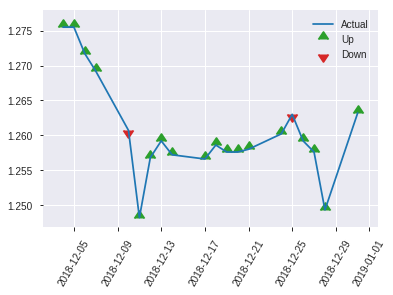


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22950947989764942
RMSE: 0.4790714768149419
LogLoss: 0.6509287549195606
Mean Per-Class Error: 0.35373900293255134
AUC: 0.6923264907135874
pr_auc: 0.691900674532457
Gini: 0.38465298142717486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42172678260773283: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   76   0.6129   (76.0/124.0)
1      13   119  0.0985   (13.0/132.0)
Total  61   195  0.3477   (89.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421727     0.727829  194
max f2                       0.335382     0.857143  241
max f0point5                 0.500592     0.658784  114
max accuracy                 0.421727     0.652344  194
max precision                0.657644     1         0
max recall                   0.335382     1         241
max specificity              0.657644     1         0
max absolute_mcc             0.421727     0.338555  194
max min_per_class_accuracy   0.492218     0.628788  126
max mean_per_class_accuracy  0.500592     0.646261  114

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 48.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.623175           1.93939   1.93939            1                0.635662  1                           0.635662            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.618496           1.93939   1.93939            1                0.619941  1                           0.627801            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.61178            1.93939   1.93939            1                0.614978  1                           0.624595            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.605982           1.29293   1.76309            0.666667         0.607955  0.909091                    0.620057            0.0151515       0.0757576                  29.2929   76.3085
    5        0.0507812                   0.60115            1.93939   1.79021            1                0.602868  0.923077                    0.617413            0.0151515       0.0909091                  93.9394   79.021
    6        0.101562                    0.580313           1.04429   1.41725            0.538462         0.590002  0.730769                    0.603708            0.0530303       0.143939                   4.4289    41.7249
    7        0.152344                    0.568419           1.64103   1.49184            0.846154         0.573892  0.769231                    0.593769            0.0833333       0.227273                   64.1026   49.1841
    8        0.203125                    0.552636           1.19347   1.41725            0.615385         0.560049  0.730769                    0.585339            0.0606061       0.287879                   19.3473   41.7249
    9        0.300781                    0.531649           1.47394   1.43566            0.76             0.541499  0.74026                     0.571105            0.143939        0.431818                   47.3939   43.5655
    10       0.402344                    0.511072           1.04429   1.33686            0.538462         0.519813  0.68932                     0.558158            0.106061        0.537879                   4.4289    33.6864
    11       0.5                         0.491537           0.930909  1.25758            0.48             0.49966   0.648438                    0.546732            0.0909091       0.628788                   -6.90909  25.7576
    12       0.601562                    0.466509           0.671329  1.1586             0.346154         0.478388  0.597403                    0.535194            0.0681818       0.69697                    -32.8671  15.8599
    13       0.699219                    0.442287           1.16364   1.1593             0.6              0.45181   0.597765                    0.523548            0.113636        0.810606                   16.3636   15.9303
    14       0.800781                    0.409851           0.969697  1.13525            0.5              0.4249    0.585366                    0.511036            0.0984848       0.909091                   -3.0303   13.5255
    15       0.898438                    0.35983            0.54303   1.07088            0.28             0.392933  0.552174                    0.498199            0.0530303       0.962121                   -45.697   7.08827
    16       1                           0.226701           0.37296   1                  0.192308         0.320045  0.515625                    0.480105          

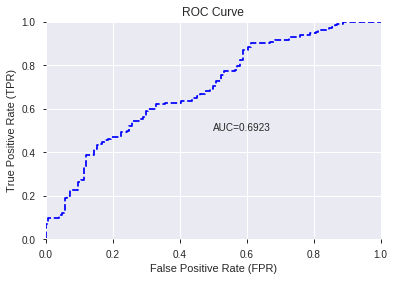

This function is available for GLM models only


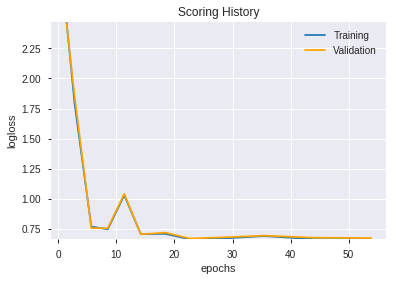

--2019-08-22 13:04:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


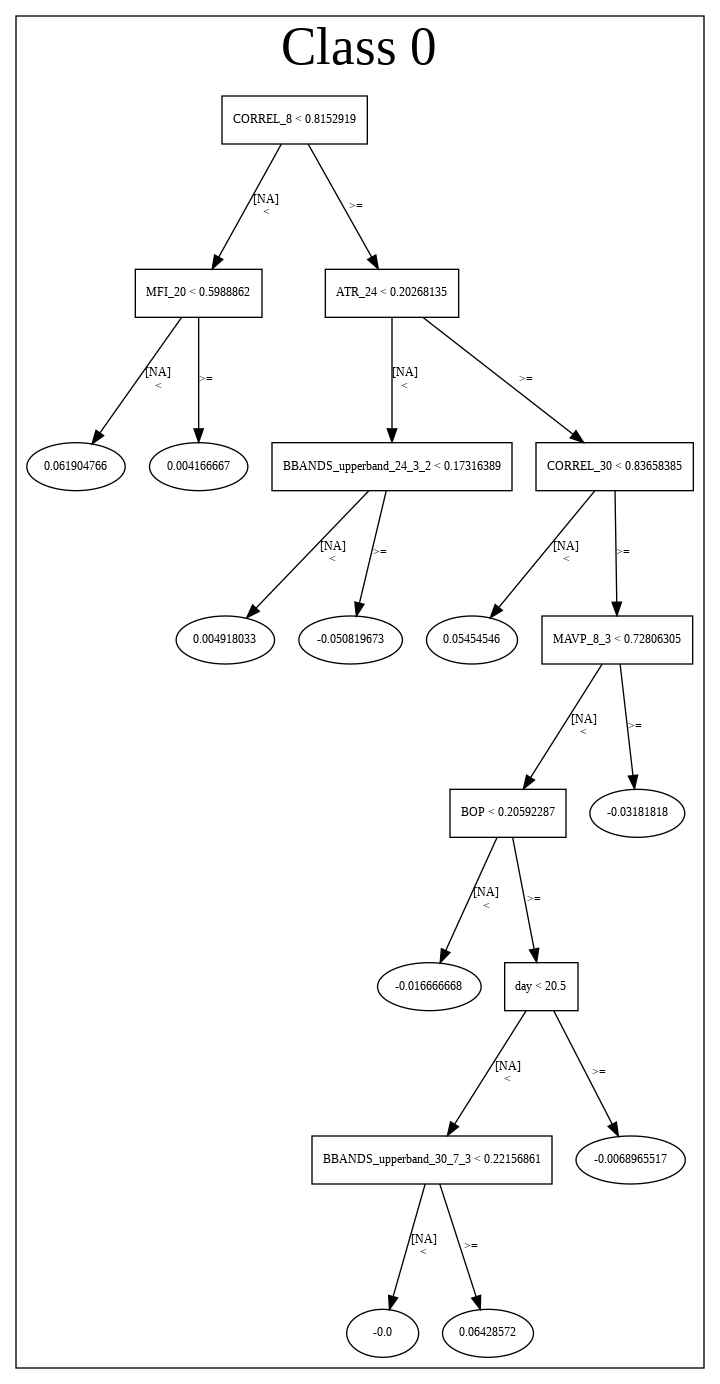

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125756_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125756_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SUB', 'CDLGRAVESTONEDOJI', 'BOP', 'CCI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_130415_model_1  0.692326  0.660408              0.356427  0.483619  0.233887

variable  relative_importance  scaled_importance  percentage
0                SUB             0.416316           1.000000    0.425077
1                BOP             0.271966           0.653268    0.277689
2  CDLGRAVESTONEDOJI             0.174557           0.419290    0.178231
3              CCI_8             0.116550           0.279955    0.119003

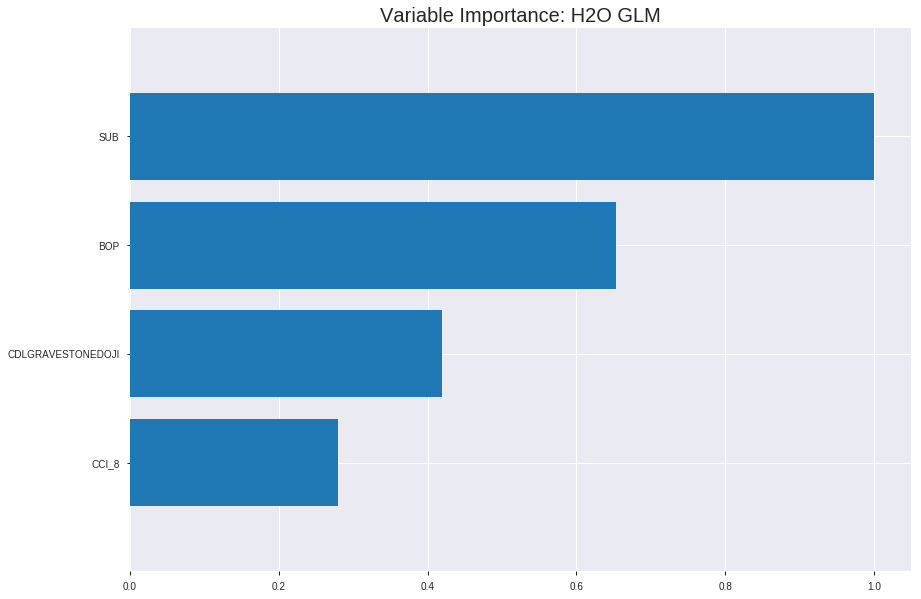

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_130415_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23711971049815928
RMSE: 0.48694939213244665
LogLoss: 0.6666725220617287
Null degrees of freedom: 1786
Residual degrees of freedom: 1782
Null deviance: 2477.240311645719
Residual deviance: 2382.6875938486182
AIC: 2392.6875938486182
AUC: 0.6314924490675324
pr_auc: 0.6030243930699839
Gini: 0.26298489813506487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36158568418784975: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      117  782   0.8699   (782.0/899.0)
1      40   848   0.045    (40.0/888.0)
Total  157  1630  0.46     (822.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361586     0.67355   314
max f2                       0.256809     0.834751  361
max f0point5                 0.485915     0.599165  201
max accuracy                 0.51466      0.599328  167
max precision                0.730004     0.9       6
max recall                   0.155904     1         390
max specificity              0.943615     0.998888  0
max absolute_mcc             0.47076      0.201078  222
max min_per_class_accuracy   0.500041     0.596218  184
max mean_per_class_accuracy  0.51466      0.598852  167

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.711408           1.56519   1.56519            0.777778         0.747858  0.777778                    0.747858            0.0157658       0.0157658                  56.519    56.519
    2        0.0201455                   0.691505           1.22979   1.39749            0.611111         0.700261  0.694444                    0.72406             0.0123874       0.0281532                  22.9792   39.7491
    3        0.0302182                   0.681505           1.00619   1.26706            0.5              0.687325  0.62963                     0.711815            0.0101351       0.0382883                  0.619369  26.7059
    4        0.040291                    0.672649           1.00619   1.20184            0.5              0.676557  0.597222                    0.703               0.0101351       0.0484234                  0.619369  20.1842
    5        0.0503637                   0.667252           1.78879   1.31923            0.888889         0.66932   0.655556                    0.696264            0.018018        0.0664414                  78.8789   31.9232
    6        0.100168                    0.627744           1.33405   1.3266             0.662921         0.64502   0.659218                    0.670785            0.0664414       0.132883                   33.4055   32.6602
    7        0.149972                    0.598184           1.17578   1.27651            0.58427          0.612771  0.634328                    0.65152             0.0585586       0.191441                   17.5777   27.6514
    8        0.200336                    0.570053           1.43103   1.31536            0.711111         0.582529  0.653631                    0.634176            0.0720721       0.263514                   43.1031   31.5359
    9        0.299944                    0.539776           1.13055   1.25399            0.561798         0.552969  0.623134                    0.607208            0.112613        0.376126                   13.0555   25.3988
    10       0.400112                    0.517392           1.15797   1.22995            0.575419         0.528441  0.611189                    0.587488            0.115991        0.492117                   15.7966   22.9949
    11       0.50028                     0.499664           1.05678   1.19528            0.52514          0.508657  0.59396                     0.571705            0.105856        0.597973                   5.67844   19.5277
    12       0.599888                    0.482297           0.960972  1.15637            0.477528         0.490575  0.574627                    0.558233            0.0957207       0.693694                   -3.90285  15.6372
    13       0.700056                    0.462907           0.933118  1.12443            0.463687         0.47338   0.558753                    0.546092            0.0934685       0.787162                   -6.68818  12.4427
    14       0.799664                    0.432166           0.847916  1.08998            0.421348         0.449957  0.541638                    0.534117            0.0844595       0.871622                   -15.2084  8.99845
    15       0.899832                    0.374365           0.730755  1.05               0.363128         0.409868  0.521766                    0.520286            0.0731982       0.94482                    -26.9245  4.99957
    16       1                           1.02233e-06        0.550877  1                  0.273743         0.287041  0.496922                    0.496922          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.241378748112769
RMSE: 0.4913031122563432
LogLoss: 0.6754918037761498
Null degrees of freedom: 509
Residual degrees of freedom: 505
Null deviance: 706.9309586242457
Residual deviance: 689.0016398516728
AIC: 699.0016398516728
AUC: 0.6162838991524251
pr_auc: 0.581540875025695
Gini: 0.2325677983048502
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43634874632031356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   217  0.8378   (217.0/259.0)
1      15   236  0.0598   (15.0/251.0)
Total  57   453  0.4549   (232.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436349     0.670455  348
max f2                       0.334254     0.830576  396
max f0point5                 0.489641     0.591117  245
max accuracy                 0.536395     0.594118  131
max precision                0.67844      0.714286  6
max recall                   0.334254     1         396
max specificity              0.706196     0.996139  0
max absolute_mcc             0.536395     0.198866  131
max min_per_class_accuracy   0.508052     0.589641  200
max mean_per_class_accuracy  0.489641     0.592218  245

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.684673           1.35458   1.35458            0.666667         0.693485  0.666667                    0.693485            0.0159363       0.0159363                  35.4582   35.4582
    2        0.0215686                   0.673058           0.812749  1.10829            0.4              0.675829  0.545455                    0.68546             0.00796813      0.0239044                  -18.7251  10.8294
    3        0.0313725                   0.665021           1.21912   1.14293            0.6              0.667811  0.5625                      0.679945            0.0119522       0.0358566                  21.9124   14.2928
    4        0.0411765                   0.661232           0.812749  1.06431            0.4              0.663002  0.52381                     0.675911            0.00796813      0.0438247                  -18.7251  6.43142
    5        0.0509804                   0.648576           1.6255    1.17223            0.8              0.653623  0.576923                    0.671625            0.0159363       0.059761                   62.5498   17.2234
    6        0.1                         0.611092           1.38167   1.2749             0.68             0.63167   0.627451                    0.652039            0.0677291       0.12749                    38.1673   27.49
    7        0.15098                     0.570086           1.48483   1.34579            0.730769         0.593786  0.662338                    0.632369            0.0756972       0.203187                   48.483    34.5786
    8        0.2                         0.557081           1.13785   1.29482            0.56             0.563607  0.637255                    0.615516            0.0557769       0.258964                   13.7849   29.4821
    9        0.3                         0.536071           1.31474   1.30146            0.647059         0.545817  0.640523                    0.592283            0.131474        0.390438                   31.4741   30.1461
    10       0.4                         0.520113           0.836653  1.18526            0.411765         0.52632   0.583333                    0.575792            0.0836653       0.474104                   -16.3347  18.5259
    11       0.5                         0.507825           1.15538   1.17928            0.568627         0.514373  0.580392                    0.563508            0.115538        0.589641                   15.5378   17.9283
    12       0.6                         0.492178           0.916335  1.13546            0.45098          0.50006   0.558824                    0.552933            0.0916335       0.681275                   -8.36653  13.5458
    13       0.7                         0.478579           0.876494  1.09846            0.431373         0.485876  0.540616                    0.543354            0.0876494       0.768924                   -12.3506  9.84633
    14       0.8                         0.458233           0.876494  1.07072            0.431373         0.468781  0.526961                    0.534032            0.0876494       0.856574                   -12.3506  7.07171
    15       0.9                         0.431655           0.836653  1.04471            0.411765         0.446362  0.514161                    0.524291            0.0836653       0.940239                   -16.3347  4.471
    16       1                           0.0261543          0.59761   1                  0.294118         0.390376  0.492157                    0.5109              0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 13:04:16  0.000 sec   2            6.8       5             1.38287           1.38386
    2019-08-22 13:04:16  0.002 sec   4            4.2       5             1.38101           1.38259
    2019-08-22 13:04:16  0.005 sec   6            2.6       5             1.37828           1.38073
    2019-08-22 13:04:16  0.009 sec   8            1.6       5             1.37446           1.37811
    2019-08-22 13:04:16  0.011 sec   10           1         5             1.36949           1.37465
    2019-08-22 13:04:16  0.014 sec   12           0.63      5             1.36354           1.37045
    2019-08-22 13:04:16  0.016 sec   14           0.39      5             1.35708           1.36585
    2019-08-22 13:04:16  0.019 sec   16           0.24      5             1.35078           1.36138
    2019-08-22 13:04:16  0.022 sec   18           0.15      5             1.34523           1.35752
    2019-08-22 13:04:16  0.026 sec   20           0.093     5             1.34078           1.35461
    2019-08-22 13:04:16  0.030 sec   22           0.058     5             1.33753           1.35268
    2019-08-22 13:04:16  0.034 sec   24           0.036     5             1.33536           1.35159
    2019-08-22 13:04:16  0.035 sec   26           0.022     5             1.33406           1.35111
    2019-08-22 13:04:16  0.037 sec   28           0.014     5             1.33335           1.35098
    2019-08-22 13:04:16  0.038 sec   29           0.0086    5             1.333             1.35102
    2019-08-22 13:04:16  0.040 sec   30           0.0054    5             1.33283           1.35112
    2019-08-22 13:04:16  0.041 sec   31           0.0033    5             1.33276           1.35121
    2019-08-22 13:04:16  0.042 sec   32           0.0021    5             1.33273           1.35128
    2019-08-22 13:04:16  0.044 sec   33           0.0013    5             1.33272           1.35133

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6640625)

('F1', 0.7327327327327328)

('auc', 0.6923264907135874)

('logloss', 0.6604083256741783)

('mean_per_class_error', 0.3394428152492669)

('rmse', 0.4836189443019746)

('mse', 0.23388728328775643)

glm prediction progress: |████████████████████████████████████████████████| 100%


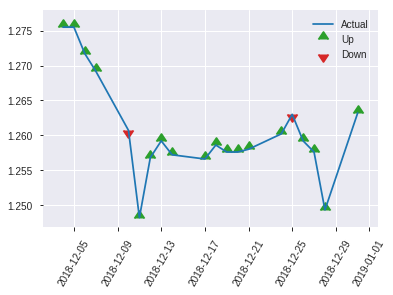


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23388728328775643
RMSE: 0.4836189443019746
LogLoss: 0.6604083256741783
Null degrees of freedom: 255
Residual degrees of freedom: 251
Null deviance: 354.999547062732
Residual deviance: 338.1290627451793
AIC: 348.1290627451793
AUC: 0.6923264907135874
pr_auc: 0.6724481235694002
Gini: 0.38465298142717486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48220159401174173: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   79   0.6371   (79.0/124.0)
1      10   122  0.0758   (10.0/132.0)
Total  55   201  0.3477   (89.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482202     0.732733  200
max f2                       0.436484     0.852713  245
max f0point5                 0.517068     0.668103  140
max accuracy                 0.507055     0.664062  157
max precision                0.7078       1         0
max recall                   0.436484     1         245
max specificity              0.7078       1         0
max absolute_mcc             0.482202     0.349398  200
max min_per_class_accuracy   0.522503     0.637097  129
max mean_per_class_accuracy  0.507055     0.660557  157

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.686219           1.93939   1.93939            1                0.69517   1                           0.69517             0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.682623           1.93939   1.93939            1                0.683807  1                           0.689488            0.0227273       0.0454545                  93.9394   93.9394
    3        0.03125                     0.677779           1.93939   1.93939            1                0.680585  1                           0.687263            0.0151515       0.0606061                  93.9394   93.9394
    4        0.0429688                   0.673893           1.29293   1.76309            0.666667         0.675521  0.909091                    0.68406             0.0151515       0.0757576                  29.2929   76.3085
    5        0.0507812                   0.663431           0         1.49184            0                0.668798  0.769231                    0.681712            0               0.0757576                  -100      49.1841
    6        0.101562                    0.643595           1.19347   1.34266            0.615385         0.650487  0.692308                    0.666099            0.0606061       0.136364                   19.3473   34.2657
    7        0.152344                    0.596078           1.19347   1.29293            0.615385         0.621126  0.666667                    0.651108            0.0606061       0.19697                    19.3473   29.2929
    8        0.203125                    0.570113           1.34266   1.30536            0.692308         0.58273   0.673077                    0.634014            0.0681818       0.265152                   34.2657   30.5361
    9        0.300781                    0.552666           1.39636   1.33491            0.72             0.56093   0.688312                    0.610285            0.136364        0.401515                   39.6364   33.4908
    10       0.402344                    0.534175           1.26807   1.31803            0.653846         0.544104  0.679612                    0.593579            0.128788        0.530303                   26.8065   31.8035
    11       0.5                         0.522587           1.08606   1.27273            0.56             0.527326  0.65625                     0.580639            0.106061        0.636364                   8.60606   27.2727
    12       0.601562                    0.508444           1.04429   1.23416            0.538462         0.515938  0.636364                    0.569716            0.106061        0.742424                   4.4289    23.416
    13       0.699219                    0.494671           0.853333  1.18097            0.44             0.50148   0.608939                    0.560186            0.0833333       0.825758                   -14.6667  18.0972
    14       0.800781                    0.479455           0.969697  1.15418            0.5              0.487423  0.595122                    0.550957            0.0984848       0.924242                   -3.0303   15.4176
    15       0.898438                    0.455618           0.310303  1.06245            0.16             0.471219  0.547826                    0.54229             0.030303        0.954545                   -68.9697  6.24506
    16       1                           0.329693           0.447552  1                  0.230769         0.425934  0.515625                    0.530473          

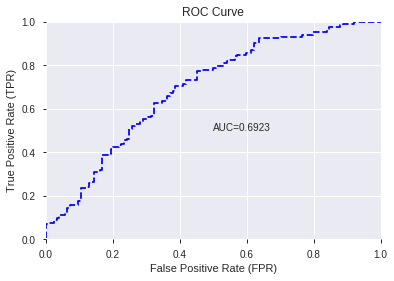

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


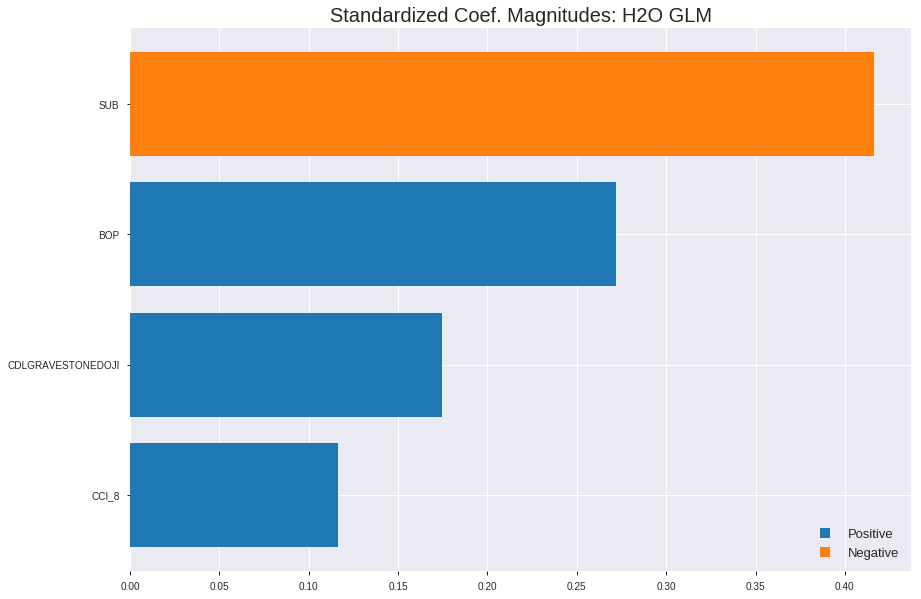

'log_likelihood'
--2019-08-22 13:04:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


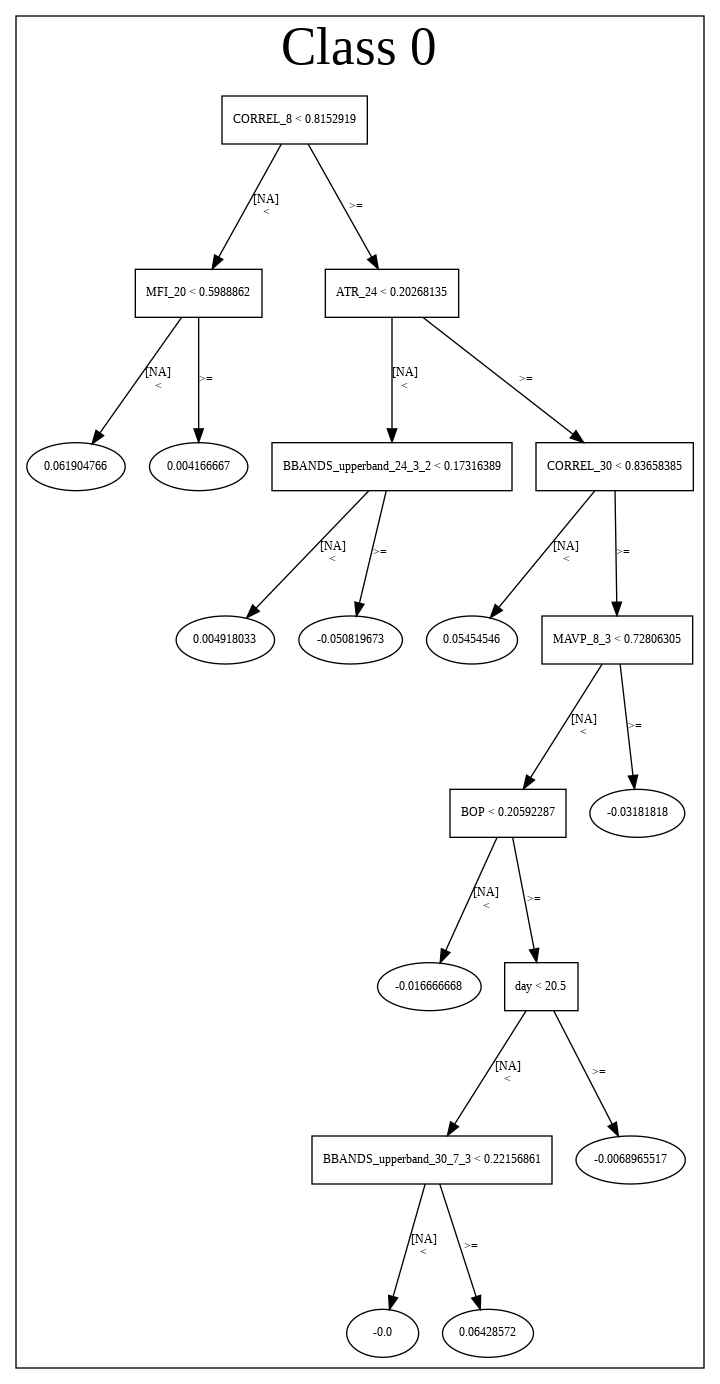

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_130415_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_130415_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB', 'BOP', 'CDLGRAVESTONEDOJI', 'CCI_8']

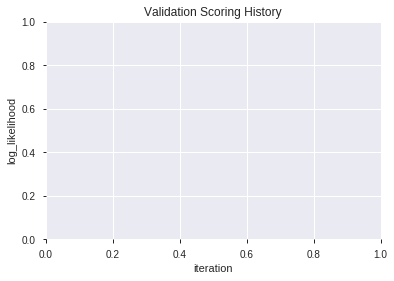

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_130427_model_4  0.744440  0.638293              0.305108  0.472426  0.223186
1               XGBoost_2_AutoML_20190822_130427  0.733168  0.636171              0.359482  0.471422  0.222238
2  XGBoost_grid_1_AutoML_20190822_130427_model_6  0.732191  0.636101              0.354472  0.471684  0.222486
3  XGBoost_grid_1_AutoML_20190822_130427_model_2  0.731824  0.641108              0.329790  0.473887  0.224569
4               XGBoost_3_AutoML_20190822_130427  0.726967  0.640863              0.341642  0.473909  0.224590
5  XGBoost_grid_1_AutoML_20190822_130427_model_3  0.722599  0.648608              0.356427  0.477659  0.228158
6               XGBoost_1_AutoML_20190822_130427  0.710747  0.638037              0.352761  0.472661  0.223408
7  XGBoost_grid_1_AutoML_20190822_130427_model_1  0.710319  0.641781              0.354472  0.474572  0.225219
8  XGBoost_grid_1_AutoML_20190822_130427_model_7  0.695137  0.641504              0.362781  0.474551  0.225198
9  XGBoost_grid_1_AutoML_20190822_130427_model_5  0.680352  0.648880              0.403348  0.478021  0.228504

variable  relative_importance  scaled_importance  percentage
0                SUB           757.503113           1.000000    0.417092
1                BOP           614.407898           0.811096    0.338302
2              CCI_8           336.691254           0.444475    0.185387
3  CDLGRAVESTONEDOJI           107.551834           0.141982    0.059220

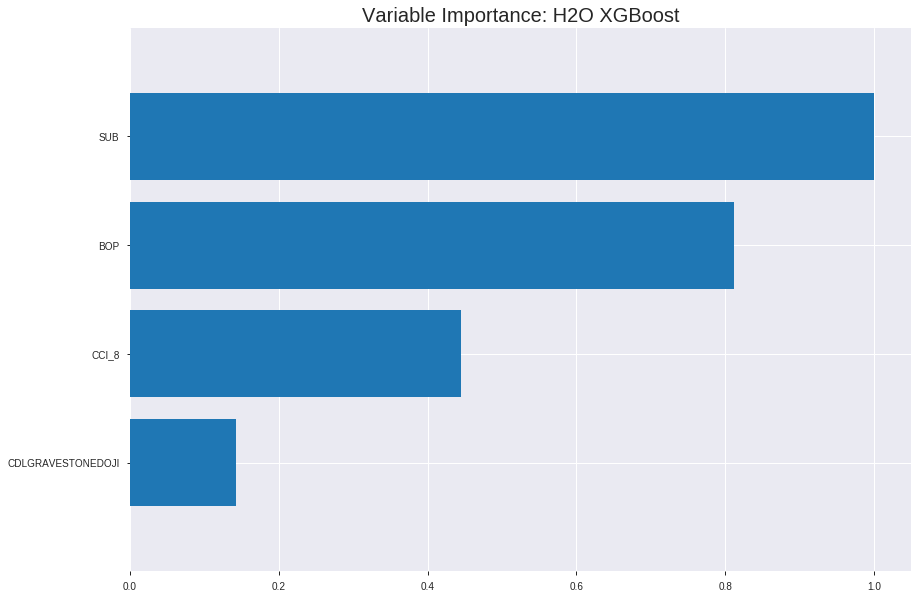

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_130427_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22656696157575326
RMSE: 0.4759905057621982
LogLoss: 0.6447023734164824
Mean Per-Class Error: 0.3581074817865697
AUC: 0.6828282676447304
pr_auc: 0.6502197079210357
Gini: 0.36565653528946074
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36425267457962035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      175  724   0.8053   (724.0/899.0)
1      42   846   0.0473   (42.0/888.0)
Total  217  1570  0.4287   (766.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364253     0.688365  331
max f2                       0.261735     0.836333  384
max f0point5                 0.503187     0.639457  188
max accuracy                 0.503187     0.641858  188
max precision                0.713267     1         0
max recall                   0.218188     1         399
max specificity              0.713267     1         0
max absolute_mcc             0.503187     0.283793  188
max min_per_class_accuracy   0.504012     0.637375  187
max mean_per_class_accuracy  0.503187     0.641893  188

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.694696           1.67699   1.67699            0.833333         0.703914  0.833333                    0.703914            0.0168919       0.0168919                  67.6989   67.6989
    2        0.0201455                   0.685598           0.894394  1.28569            0.444444         0.689105  0.638889                    0.69651             0.00900901      0.0259009                  -10.5606  28.5692
    3        0.0307778                   0.678923           1.90647   1.50014            0.947368         0.681652  0.745455                    0.691377            0.0202703       0.0461712                  90.6472   50.0143
    4        0.040291                    0.670923           1.42051   1.48134            0.705882         0.674343  0.736111                    0.687355            0.0135135       0.0596847                  42.0509   48.1341
    5        0.0503637                   0.664909           1.56519   1.49811            0.777778         0.668086  0.744444                    0.683501            0.0157658       0.0754505                  56.519    49.8111
    6        0.101847                    0.643726           1.31243   1.40425            0.652174         0.652598  0.697802                    0.66788             0.0675676       0.143018                   31.2427   40.4248
    7        0.149972                    0.622159           1.52099   1.44171            0.755814         0.633353  0.716418                    0.6568              0.0731982       0.216216                   52.099    44.171
    8        0.200336                    0.603821           1.18507   1.37719            0.588889         0.613144  0.684358                    0.645825            0.0596847       0.275901                   18.5073   37.7192
    9        0.299944                    0.568348           1.32275   1.35911            0.657303         0.585165  0.675373                    0.62568             0.131757        0.407658                   32.2749   35.9112
    10       0.400672                    0.53454            1.20743   1.32098            0.6              0.553212  0.656425                    0.607462            0.121622        0.529279                   20.7432   32.0981
    11       0.50028                     0.503542           1.10794   1.27856            0.550562         0.518949  0.635347                    0.589839            0.11036         0.63964                    10.7944   27.8564
    12       0.599888                    0.473839           0.893138  1.21457            0.44382          0.488934  0.603545                    0.573084            0.088964        0.728604                   -10.6862  21.4566
    13       0.700056                    0.439145           0.899391  1.16947            0.446927         0.45759   0.581135                    0.556559            0.0900901       0.818694                   -10.0609  16.9469
    14       0.799664                    0.398043           0.746166  1.11674            0.370787         0.41772   0.554934                    0.539265            0.0743243       0.893018                   -25.3834  11.6741
    15       0.899832                    0.355313           0.685786  1.06877            0.340782         0.376305  0.531095                    0.521124            0.0686937       0.961712                   -31.4214  6.87679
    16       1                           0.217967           0.382241  1                  0.189944         0.282937  0.496922                    0.497265          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2435785950199916
RMSE: 0.49353682235471713
LogLoss: 0.6801398669709615
Mean Per-Class Error: 0.41689612207540494
AUC: 0.5927871525481087
pr_auc: 0.5756534476463827
Gini: 0.1855743050962173
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27438944578170776: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    253  0.9768   (253.0/259.0)
1      0    251  0        (0.0/251.0)
Total  6    504  0.4961   (253.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274389     0.664901  394
max f2                       0.274389     0.832228  394
max f0point5                 0.532052     0.571557  169
max accuracy                 0.541107     0.584314  159
max precision                0.696851     1         0
max recall                   0.274389     1         394
max specificity              0.696851     1         0
max absolute_mcc             0.577621     0.172555  112
max min_per_class_accuracy   0.509614     0.573705  193
max mean_per_class_accuracy  0.532052     0.583104  169

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.678935           1.35458   1.35458            0.666667         0.689017  0.666667                    0.689017            0.0159363       0.0159363                  35.4582    35.4582
    2        0.0215686                   0.667089           1.21912   1.29301            0.6              0.670859  0.636364                    0.680763            0.0119522       0.0278884                  21.9124    29.301
    3        0.0313725                   0.663036           1.21912   1.26992            0.6              0.665113  0.625                       0.675873            0.0119522       0.0398406                  21.9124    26.992
    4        0.0411765                   0.654301           1.21912   1.25783            0.6              0.657516  0.619048                    0.671502            0.0119522       0.0517928                  21.9124    25.7826
    5        0.054902                    0.648781           1.74161   1.37877            0.857143         0.649547  0.678571                    0.666013            0.0239044       0.0756972                  74.1605    37.8771
    6        0.1                         0.625658           1.06011   1.23506            0.521739         0.636345  0.607843                    0.652634            0.0478088       0.123506                   6.01074    23.506
    7        0.15098                     0.610392           1.09409   1.18746            0.538462         0.616784  0.584416                    0.640528            0.0557769       0.179283                   9.40852    18.7458
    8        0.2                         0.594413           1.46295   1.25498            0.72             0.60321   0.617647                    0.631382            0.0717131       0.250996                   46.2948    25.498
    9        0.3                         0.567242           1.23506   1.24834            0.607843         0.582114  0.614379                    0.614959            0.123506        0.374502                   23.506     24.834
    10       0.4                         0.539783           1.0757    1.20518            0.529412         0.552615  0.593137                    0.599373            0.10757         0.482072                   7.56972    20.5179
    11       0.5                         0.507182           0.916335  1.14741            0.45098          0.522929  0.564706                    0.584084            0.0916335       0.573705                   -8.36653   14.741
    12       0.601961                    0.481955           0.742415  1.07881            0.365385         0.493082  0.530945                    0.56867             0.0756972       0.649402                   -25.7585   7.88118
    13       0.7                         0.456025           0.934661  1.05862            0.46             0.47047   0.521008                    0.554917            0.0916335       0.741036                   -6.53386   5.86227
    14       0.8                         0.42254            0.996016  1.0508             0.490196         0.440904  0.517157                    0.540665            0.0996016       0.840637                   -0.398406  5.07968
    15       0.9                         0.379062           0.916335  1.03586            0.45098          0.401418  0.509804                    0.525193            0.0916335       0.932271                   -8.36653   3.58566
    16       1                           0.257603           0.677291  1                  0.333333         0.327995  0.492157                    0.5054


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:04:31  1.488 sec   0                  0.5              0.693147            0.5             0                  1                0.503078                         0.5                0.693147              0.5               0                    1                  0.507843
    2019-08-22 13:04:31  1.520 sec   5                  0.493454         0.680106            0.652584        0.622931           1.60991          0.419698                         0.497729           0.688607              0.579681          0.576285             1.35458            0.507843
    2019-08-22 13:04:31  1.546 sec   10                 0.489221         0.671673            0.663624        0.632848           1.69464          0.423055                         0.496475           0.686088              0.579012          0.568863             1.26992            0.492157
    2019-08-22 13:04:32  1.575 sec   15                 0.485965         0.665137            0.668449        0.633496           1.42985          0.393397                         0.495457           0.684039              0.58545           0.574247             1.35458            0.492157
    2019-08-22 13:04:32  1.607 sec   20                 0.48355          0.660269            0.671522        0.63633            1.56519          0.383324                         0.494784           0.682677              0.58655           0.5709               1.35458            0.5
    2019-08-22 13:04:32  1.641 sec   25                 0.481361         0.655799            0.672929        0.635693           1.60991          0.377728                         0.493355           0.679813              0.595733          0.578653             1.35458            0.496078
    2019-08-22 13:04:32  1.692 sec   30                 0.479716         0.652427            0.673914        0.63662            1.56519          0.377728                         0.493298           0.679677              0.594633          0.572421             1.01594            0.492157
    2019-08-22 13:04:32  1.730 sec   35                 0.478491         0.649897            0.676654        0.640535           1.56519          0.378847                         0.492907           0.678899              0.596117          0.57407              1.35458            0.494118
    2019-08-22 13:04:32  1.770 sec   40                 0.477513         0.647882            0.679368        0.6416             1.30805          0.386122                         0.492923           0.678911              0.596448          0.577704             1.35458            0.460784
    2019-08-22 13:04:32  1.816 sec   45                 0.476626         0.646053            0.682042        0.646957           1.78879          0.386682                         0.493464           0.679982              0.59351           0.574781             1.35458            0.492157
    2019-08-22 13:04:32  1.866 sec   50                 0.475991         0.644702            0.682828        0.65022            1.67699          0.428651                         0.493537           0.68014               0.592787          0.575653             1.35458            0.496078

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
SUB                757.503                1                    0.417092
BOP                614.408                0.811096             0.338302
CCI_8              336.691                0.444475             0.185387
CDLGRAVESTONEDOJI  107.552                0.141982             0.0592196

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.70703125)

('F1', 0.7407407407407408)

('auc', 0.7444403714565005)

('logloss', 0.6382933157558417)

('mean_per_class_error', 0.292644183773216)

('rmse', 0.47242597255484786)

('mse', 0.22318629954439384)

xgboost prediction progress: |████████████████████████████████████████████| 100%


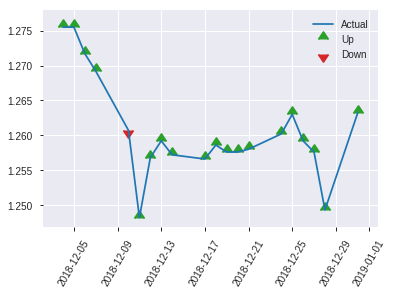


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22318629954439384
RMSE: 0.47242597255484786
LogLoss: 0.6382933157558417
Mean Per-Class Error: 0.292644183773216
AUC: 0.7444403714565005
pr_auc: 0.7280161175405445
Gini: 0.4888807429130011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5073297023773193: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   55   0.4435   (55.0/124.0)
1      22   110  0.1667   (22.0/132.0)
Total  91   165  0.3008   (77.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50733      0.740741  156
max f2                       0.371224     0.850515  234
max f0point5                 0.54163      0.71875   121
max accuracy                 0.54163      0.707031  121
max precision                0.691584     1         0
max recall                   0.371224     1         234
max specificity              0.691584     1         0
max absolute_mcc             0.54163      0.414522  121
max min_per_class_accuracy   0.54163      0.69697   121
max mean_per_class_accuracy  0.54163      0.707356  121

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.682352           1.93939   1.93939            1                0.688895  1                           0.688895            0.0227273       0.0227273                  93.9394   93.9394
    2        0.0234375                   0.661643           1.29293   1.61616            0.666667         0.671261  0.833333                    0.680078            0.0151515       0.0378788                  29.2929   61.6162
    3        0.03125                     0.656038           1.93939   1.69697            1                0.660314  0.875                       0.675137            0.0151515       0.0530303                  93.9394   69.697
    4        0.0429688                   0.648095           1.93939   1.76309            1                0.650351  0.909091                    0.668377            0.0227273       0.0757576                  93.9394   76.3085
    5        0.0507812                   0.64585            1.93939   1.79021            1                0.646919  0.923077                    0.665076            0.0151515       0.0909091                  93.9394   79.021
    6        0.101562                    0.626292           1.34266   1.56643            0.692308         0.635846  0.807692                    0.650461            0.0681818       0.159091                   34.2657   56.6434
    7        0.15625                     0.614564           1.24675   1.45455            0.642857         0.619914  0.75                        0.63977             0.0681818       0.227273                   24.6753   45.4545
    8        0.203125                    0.600755           1.29293   1.41725            0.666667         0.606212  0.730769                    0.632026            0.0606061       0.287879                   29.2929   41.7249
    9        0.300781                    0.575384           1.70667   1.51122            0.88             0.587398  0.779221                    0.617536            0.166667        0.454545                   70.6667   51.1216
    10       0.402344                    0.560749           1.19347   1.43101            0.615385         0.567962  0.737864                    0.605022            0.121212        0.575758                   19.3473   43.1009
    11       0.5                         0.54044            1.24121   1.39394            0.64             0.54988   0.71875                     0.594252            0.121212        0.69697                    24.1212   39.3939
    12       0.601562                    0.521116           0.895105  1.30972            0.461538         0.530229  0.675325                    0.583443            0.0909091       0.787879                   -10.4895  30.9721
    13       0.699219                    0.490329           0.620606  1.21348            0.32             0.507157  0.625698                    0.572789            0.0606061       0.848485                   -37.9394  21.3476
    14       0.800781                    0.46723            0.745921  1.15418            0.384615         0.478638  0.595122                    0.560848            0.0757576       0.924242                   -25.4079  15.4176
    15       0.898438                    0.434309           0.387879  1.07088            0.2              0.450872  0.552174                    0.548894            0.0378788       0.962121                   -61.2121  7.08827
    16       1                           0.263975           0.37296   1                  0.192308         0.373242  0.515625                    0.531054           

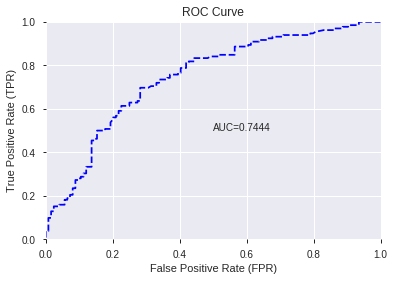

This function is available for GLM models only


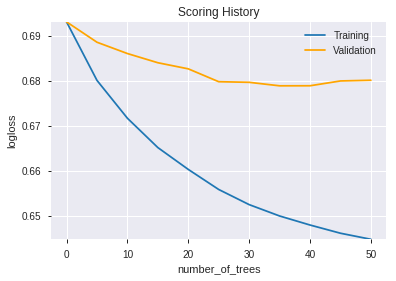

--2019-08-22 13:04:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

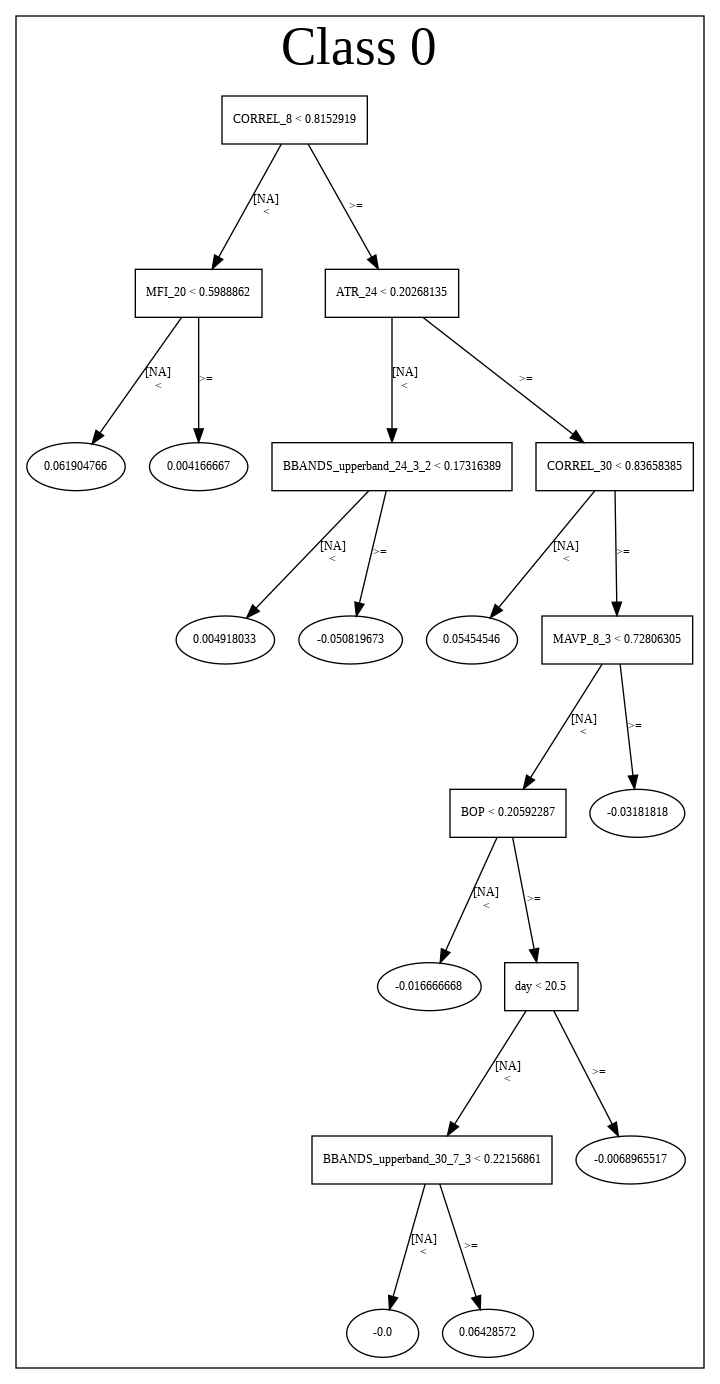

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_130427_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_130427_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SUB', 'BOP', 'CCI_8', 'CDLGRAVESTONEDOJI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

147

['BBANDS_lowerband_14_0_2',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_middleband_14_0_5',
 'BBANDS_upperband_14_1_2',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_middleband_14_2_2',
 'BBANDS_middleband_14_2_3',
 'BBANDS_middleband_14_3_2',
 'BBANDS_lowerband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_14_5_5',
 'MAVP_14_6',
 'BBANDS_upperband_14_6_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_lowerband_14_6_5',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'SAR_0.2',
 'BBANDS_middleband_20_0_2',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_20_1_3',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_20_2_4',
 'MAVP_20_5',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_upperband_20_5_4',
 'BBANDS_middleband_20_6_3',
 'BBANDS_lowerband_20_6_3

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_130558_model_6  0.727395  0.655210              0.360704  0.481001  0.231362
1  DeepLearning_grid_1_AutoML_20190822_130558_model_1  0.675220  0.795147              0.393817  0.508604  0.258678
2  DeepLearning_grid_1_AutoML_20190822_130558_model_9  0.675098  0.671602              0.385142  0.489340  0.239454
3  DeepLearning_grid_1_AutoML_20190822_130558_model_7  0.664895  0.640849              0.409580  0.475769  0.226356
4  DeepLearning_grid_1_AutoML_20190822_130558_model_3  0.656525  0.710104              0.366080  0.502598  0.252604
5  DeepLearning_grid_1_AutoML_20190822_130558_model_4  0.638502  0.830859              0.446114  0.522992  0.273521
6  DeepLearning_grid_1_AutoML_20190822_130558_model_5  0.596988  0.685827              0.467253  0.496472  0.246484
7  DeepLearning_grid_1_AutoML_20190822_130558_model_8  0.590390  0.668602              0.410313  0.488122  0.238263
8  DeepLearning_grid_1_AutoML_20190822_130558_model_2  0.575086  0.761054              0.433040  0.523085  0.273618
9               DeepLearning_1_AutoML_20190822_130558  0.479778  1.029452              0.491935  0.582168  0.338920

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.013479
1              CDLRICKSHAWMAN             0.855408           0.855408    0.011530
2           CDLGRAVESTONEDOJI             0.731763           0.731763    0.009863
3                STOCHF_fastk             0.698583           0.698583    0.009416
4                      ADX_24             0.602152           0.602152    0.008116
..                        ...                  ...                ...         ...
142                 MAVP_20_5             0.449217           0.449217    0.006055
143                 MAVP_30_2             0.447941           0.447941    0.006038
144  BBANDS_middleband_14_5_5             0.447077           0.447077    0.006026
145              CDLENGULFING             0.442367           0.442367    0.005962
146   BBANDS_upperband_14_6_2             0.439466           0.439466    0.005923

[147 rows x 4 columns]

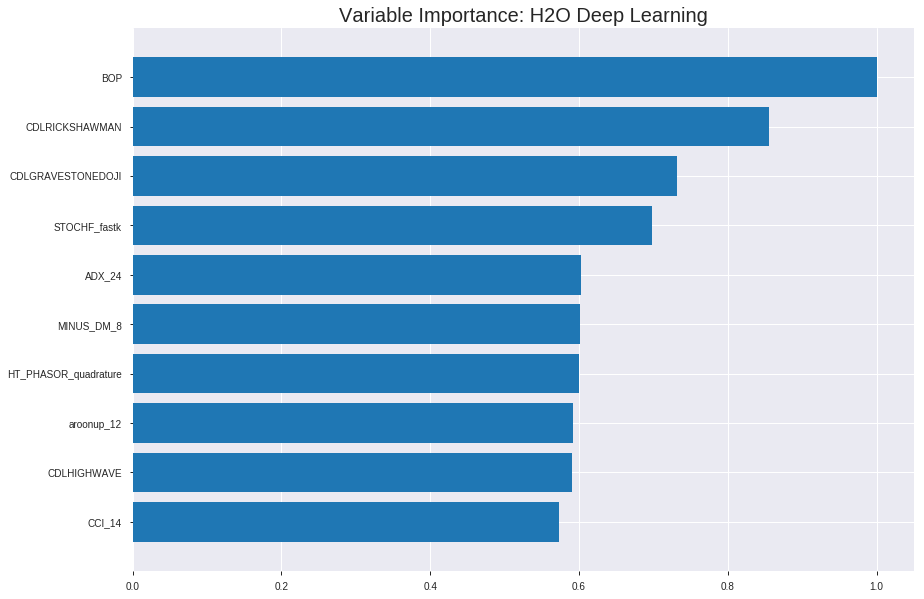

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_130558_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22734567609757267
RMSE: 0.476807797857347
LogLoss: 0.6444663588536148
Mean Per-Class Error: 0.37777147280762413
AUC: 0.6734472236418844
pr_auc: 0.6712808642159067
Gini: 0.3468944472837687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3131865897538816: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      170  729   0.8109   (729.0/899.0)
1      51   837   0.0574   (51.0/888.0)
Total  221  1566  0.4365   (780.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313187     0.682152  310
max f2                       0.183049     0.83713   361
max f0point5                 0.480618     0.620055  196
max accuracy                 0.480618     0.621712  196
max precision                0.93935      1         0
max recall                   0.116736     1         384
max specificity              0.93935      1         0
max absolute_mcc             0.46508      0.251284  208
max min_per_class_accuracy   0.501872     0.615128  174
max mean_per_class_accuracy  0.480618     0.622229  196

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 47.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.769452           1.90059   1.90059            0.944444         0.819392  0.944444                    0.819392            0.0191441       0.0191441                  90.0588   90.0588
    2        0.0201455                   0.706736           2.01239   1.95649            1                0.734884  0.972222                    0.777138            0.0202703       0.0394144                  101.239   95.6488
    3        0.0302182                   0.678052           1.56519   1.82606            0.777778         0.691244  0.907407                    0.748507            0.0157658       0.0551802                  56.519    82.6055
    4        0.040291                    0.6505             1.34159   1.70494            0.666667         0.664628  0.847222                    0.727537            0.0135135       0.0686937                  34.1592   70.4939
    5        0.0503637                   0.635783           1.78879   1.72171            0.888889         0.642432  0.855556                    0.710516            0.018018        0.0867117                  78.8789   72.1709
    6        0.100168                    0.591014           1.49233   1.60766            0.741573         0.609585  0.798883                    0.660333            0.0743243       0.161036                   49.2332   60.7661
    7        0.149972                    0.573076           1.26622   1.49427            0.629213         0.58184   0.742537                    0.634266            0.0630631       0.224099                   26.6221   49.4273
    8        0.200336                    0.562808           1.29687   1.44465            0.644444         0.567825  0.717877                    0.617563            0.0653153       0.289414                   29.6872   44.4647
    9        0.299944                    0.542006           1.13055   1.34034            0.561798         0.552417  0.666045                    0.595929            0.112613        0.402027                   13.0555   34.034
    10       0.400112                    0.522185           1.13548   1.28905            0.564246         0.531639  0.640559                    0.579834            0.113739        0.515766                   13.5481   28.9054
    11       0.50028                     0.501525           1.01181   1.23354            0.502793         0.511153  0.612975                    0.566082            0.101351        0.617117                   1.18149   23.3544
    12       0.599888                    0.475184           1.05142   1.2033             0.522472         0.48881   0.597948                    0.553252            0.10473         0.721847                   5.14159   20.3303
    13       0.700056                    0.439377           0.865664  1.15499            0.430168         0.457496  0.573941                    0.53955             0.0867117       0.808559                   -13.4336  15.4991
    14       0.799664                    0.387808           0.768777  1.10688            0.382022         0.415677  0.550035                    0.52412             0.0765766       0.885135                   -23.1223  10.6883
    15       0.899832                    0.291275           0.697028  1.06126            0.346369         0.343718  0.527363                    0.504038            0.0698198       0.954955                   -30.2972  6.1259
    16       1                           0.000376183        0.449696  1                  0.223464         0.199872  0.496922                    0.473571           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24288046234979357
RMSE: 0.49282903967785174
LogLoss: 0.6785016535644869
Mean Per-Class Error: 0.4118275931024935
AUC: 0.6054777030872649
pr_auc: 0.5698765156789131
Gini: 0.2109554061745298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.435386123933411: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   213  0.8224   (213.0/259.0)
1      15   236  0.0598   (15.0/251.0)
Total  61   449  0.4471   (228.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435386     0.674286  343
max f2                       0.297746     0.830026  397
max f0point5                 0.481252     0.587459  242
max accuracy                 0.481252     0.586275  242
max precision                0.692848     1         0
max recall                   0.297746     1         397
max specificity              0.692848     1         0
max absolute_mcc             0.441683     0.187282  331
max min_per_class_accuracy   0.498604     0.569721  199
max mean_per_class_accuracy  0.481252     0.588172  242

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 49.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.632222           1.69323   1.69323            0.833333         0.657177  0.833333                    0.657177            0.0199203       0.0199203                  69.3227    69.3227
    2        0.0215686                   0.62032            1.21912   1.47773            0.6              0.623232  0.727273                    0.641748            0.0119522       0.0318725                  21.9124    47.7725
    3        0.0313725                   0.6068             0.406375  1.14293            0.2              0.61108   0.5625                      0.632164            0.00398406      0.0358566                  -59.3625   14.2928
    4        0.0411765                   0.59886            1.6255    1.25783            0.8              0.60174   0.619048                    0.62492             0.0159363       0.0517928                  62.5498    25.7826
    5        0.0509804                   0.59344            0.812749  1.17223            0.4              0.595055  0.576923                    0.619177            0.00796813      0.059761                   -18.7251   17.2234
    6        0.1                         0.564254           0.975299  1.0757             0.48             0.574713  0.529412                    0.597381            0.0478088       0.10757                    -2.47012   7.56972
    7        0.15098                     0.548821           1.32853   1.16107            0.653846         0.556273  0.571429                    0.5835              0.0677291       0.175299                   32.8532    16.107
    8        0.2                         0.539744           1.3004    1.19522            0.64             0.544148  0.588235                    0.573855            0.063745        0.239044                   30.0398    19.5219
    9        0.3                         0.523849           1.2749    1.22178            0.627451         0.53285   0.601307                    0.560187            0.12749         0.366534                   27.49      22.178
    10       0.4                         0.508159           1.03586   1.1753             0.509804         0.516393  0.578431                    0.549238            0.103586        0.47012                    3.58566    17.5299
    11       0.5                         0.498369           0.996016  1.13944            0.490196         0.503007  0.560784                    0.539992            0.0996016       0.569721                   -0.398406  13.9442
    12       0.6                         0.484836           1.11554   1.13546            0.54902          0.491061  0.558824                    0.531837            0.111554        0.681275                   11.5538    13.5458
    13       0.7                         0.471027           0.996016  1.11554            0.490196         0.477227  0.54902                     0.524036            0.0996016       0.780876                   -0.398406  11.5538
    14       0.8                         0.455202           0.836653  1.08068            0.411765         0.463846  0.531863                    0.516512            0.0836653       0.864542                   -16.3347   8.06773
    15       0.9                         0.426837           0.836653  1.05356            0.411765         0.44228   0.518519                    0.508264            0.0836653       0.948207                   -16.3347   5.35635
    16       1                           0.069943           0.517928  1                  0.254902         0.385788  0.492157                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:11:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:11:22  3 min 16.302 sec  767 obs/sec       1         1             1787       0.645344         1.90906             -0.665937      0.521761        0.517409           1.45339          0.498041                         0.65141            2.11795               -0.697758        0.544809          0.541481             1.69323            0.501961
    2019-08-22 13:11:32  3 min 26.975 sec  1342 obs/sec      9         9             16083      0.490904         0.674413            0.0360184      0.616589        0.593714           1.67699          0.470621                         0.498702           0.690484              0.00494098       0.572405          0.545524             0.338645           0.470588
    2019-08-22 13:11:43  3 min 37.461 sec  1581 obs/sec      19        19            33953      0.476808         0.644466            0.0905828      0.673447        0.671281           1.90059          0.436486                         0.492829           0.678502              0.028239         0.605478          0.569877             1.69323            0.447059
    2019-08-22 13:11:53  3 min 47.650 sec  1689 obs/sec      29        29            51823      0.468919         0.627523            0.120427       0.706493        0.700575           1.90059          0.420817                         0.496383           0.685472              0.0141714        0.576189          0.533274             1.35458            0.452941
    2019-08-22 13:12:04  3 min 58.346 sec  1768 obs/sec      40        40            71480      0.461289         0.609785            0.148819       0.72493         0.724611           2.01239          0.371572                         0.493927           0.680435              0.0239035        0.588788          0.536464             0.677291           0.441176
    2019-08-22 13:12:14  4 min  8.738 sec  1827 obs/sec      51        51            91137      0.451595         0.588511            0.184216       0.751889        0.755982           2.01239          0.362619                         0.495094           0.68248               0.0192884        0.599748          0.54266              0.677291           0.401961
    2019-08-22 13:12:24  4 min 18.252 sec  1866 obs/sec      61        61            109007     0.441301         0.565458            0.220986       0.77644         0.77782            2.01239          0.325686                         0.495633           0.683902              0.0171489        0.607485          0.549201             0.338645           0.403922
    2019-08-22 13:12:25  4 min 19.246 sec  1865 obs/sec      61        61            109007     0.476808         0.644466            0.0905828      0.673447        0.671281           1.90059          0.436486                         0.492829           0.678502              0.028239         0.605478          0.569877             1.69323            0.447059

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.013478582464155748
CDLRICKSHAWMAN            0.8554081916809082     0.8554081916809082   0.011529689852085469
CDLGRAVESTONEDOJI         0.7317633628845215     0.7317633628845215   0.009863132830886951
STOCHF_fastk              0.6985825896263123     0.6985825896263123   0.009415903042301724
ADX_24                    0.6021518707275391     0.6021518707275391   0.008116153645546787
---                       ---                    ---                  ---
MAVP_20_5                 0.44921714067459106    0.44921714067459106  0.006054810274894729
MAVP_30_2                 0.4479411244392395     0.4479411244392395   0.006037611384840941
BBANDS_middleband_14_5_5  0.44707679748535156    0.44707679748535156  0.00602596148271697
CDLENGULFING              0.4423668682575226     0.4423668682575226   0.00596247831321934
BBANDS_upperband_14_6_2   0.4394664764404297     0.4394664764404297   0.005923385142934291


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.69140625)

('F1', 0.7321428571428571)

('auc', 0.727394916911046)

('logloss', 0.6552095347942939)

('mean_per_class_error', 0.30975073313782997)

('rmse', 0.48100092474473666)

('mse', 0.23136188960529183)

deeplearning prediction progress: |███████████████████████████████████████| 100%


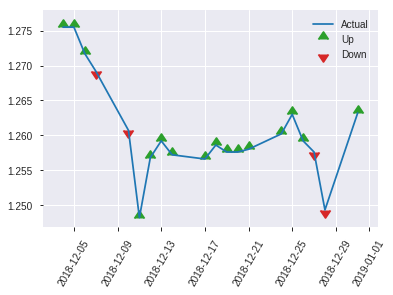


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23136188960529183
RMSE: 0.48100092474473666
LogLoss: 0.6552095347942939
Mean Per-Class Error: 0.30975073313782997
AUC: 0.727394916911046
pr_auc: 0.7001491237190938
Gini: 0.4547898338220919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43343624383090706: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   81   0.6532   (81.0/124.0)
1      9    123  0.0682   (9.0/132.0)
Total  52   204  0.3516   (90.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433436     0.732143  203
max f2                       0.404252     0.85752   229
max f0point5                 0.479561     0.697674  138
max accuracy                 0.479561     0.691406  138
max precision                0.578631     0.875     7
max recall                   0.353705     1         244
max specificity              0.646198     0.991935  0
max absolute_mcc             0.479561     0.381725  138
max min_per_class_accuracy   0.486864     0.659091  126
max mean_per_class_accuracy  0.479561     0.690249  138

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.62006            1.29293   1.29293            0.666667         0.636766  0.666667                    0.636766            0.0151515       0.0151515                  29.2929   29.2929
    2        0.0234375                   0.581638           1.93939   1.61616            1                0.600606  0.833333                    0.618686            0.0227273       0.0378788                  93.9394   61.6162
    3        0.03125                     0.576053           1.93939   1.69697            1                0.57978   0.875                       0.608959            0.0151515       0.0530303                  93.9394   69.697
    4        0.0429688                   0.572692           0.646465  1.41047            0.333333         0.574026  0.727273                    0.599432            0.00757576      0.0606061                  -35.3535  41.0468
    5        0.0507812                   0.566187           1.93939   1.49184            1                0.569157  0.769231                    0.594775            0.0151515       0.0757576                  93.9394   49.1841
    6        0.101562                    0.54134            1.34266   1.41725            0.692308         0.5525    0.730769                    0.573637            0.0681818       0.143939                   34.2657   41.7249
    7        0.152344                    0.530065           1.64103   1.49184            0.846154         0.536896  0.769231                    0.56139             0.0833333       0.227273                   64.1026   49.1841
    8        0.203125                    0.52071            1.49184   1.49184            0.769231         0.524829  0.769231                    0.55225             0.0757576       0.30303                    49.1841   49.1841
    9        0.300781                    0.506151           1.24121   1.41047            0.64             0.512238  0.727273                    0.539259            0.121212        0.424242                   24.1212   41.0468
    10       0.402344                    0.495496           1.26807   1.37452            0.653846         0.501526  0.708738                    0.529734            0.128788        0.55303                    26.8065   37.4522
    11       0.5                         0.486391           1.08606   1.31818            0.56             0.49042   0.679688                    0.522056            0.106061        0.659091                   8.60606   31.8182
    12       0.601562                    0.469836           1.04429   1.27194            0.538462         0.478906  0.655844                    0.514771            0.106061        0.765152                   4.4289    27.194
    13       0.699219                    0.456022           0.853333  1.21348            0.44             0.461769  0.625698                    0.507368            0.0833333       0.848485                   -14.6667  21.3476
    14       0.800781                    0.433369           0.820513  1.16364            0.423077         0.44417   0.6                         0.499353            0.0833333       0.931818                   -17.9487  16.3636
    15       0.898438                    0.402424           0.54303   1.09618            0.28             0.419026  0.565217                    0.490622            0.0530303       0.984848                   -45.697   9.61792
    16       1                           0.279772           0.149184  1                  0.0769231        0.358828  0.515625                    0.477236           

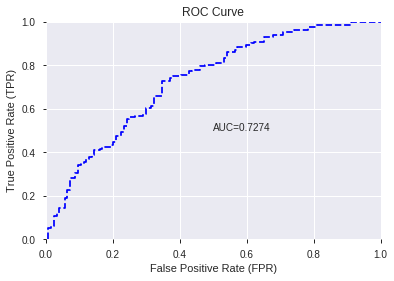

This function is available for GLM models only


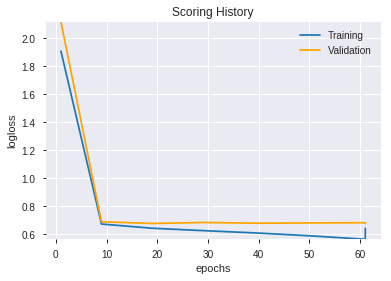

--2019-08-22 13:19:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


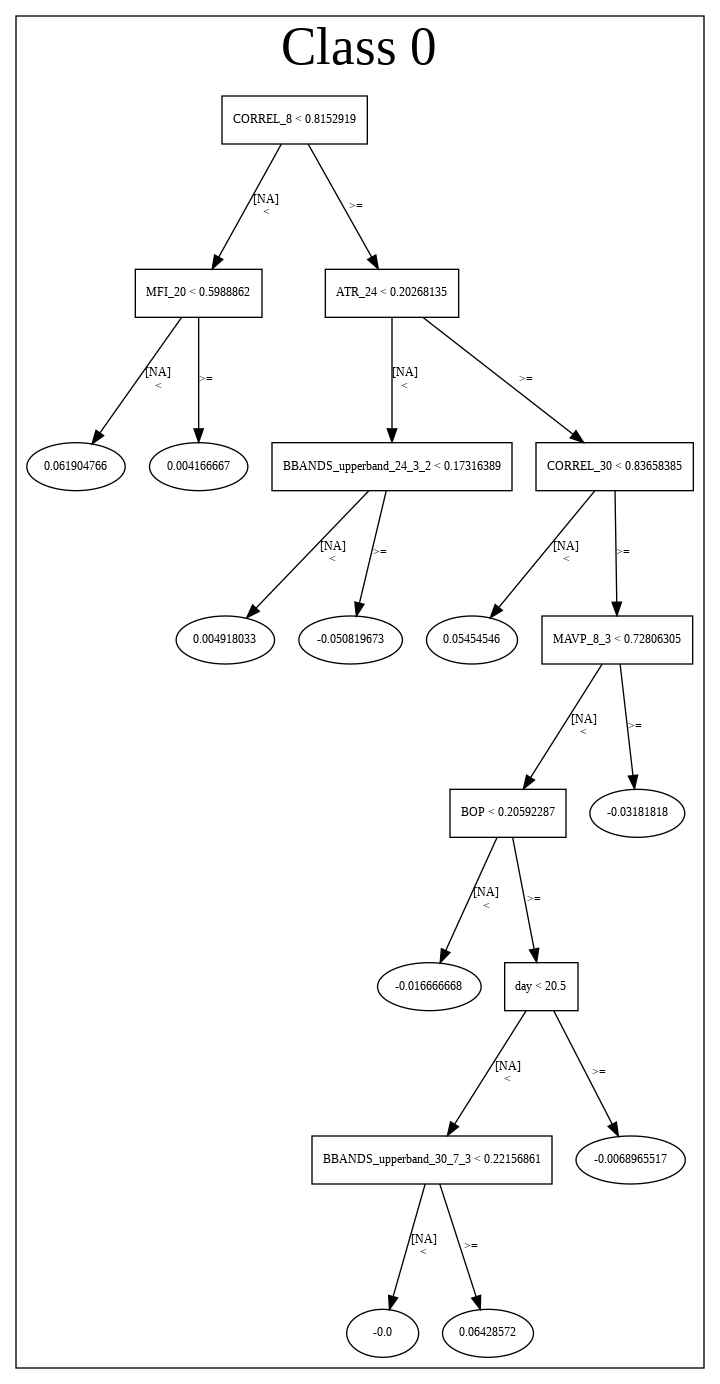

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_130558_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_130558_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'ADX_24',
 'MINUS_DM_8',
 'HT_PHASOR_quadrature',
 'aroonup_12',
 'CDLHIGHWAVE',
 'CCI_14',
 'aroondown_8',
 'MINUS_DI_20',
 'ADXR_14',
 'MINUS_DI_12',
 'MACDFIX_signal_20',
 'aroonup_8',
 'aroondown_20',
 'ADXR_8',
 'ADX_8',
 'SAR_0.2',
 'VAR_8',
 'HT_DCPERIOD',
 'CCI_20',
 'WILLR_14',
 'BETA_12',
 'MINUS_DM_14',
 'BBANDS_upperband_30_6_5',
 'PLUS_DI_8',
 'BBANDS_lowerband_24_3_5',
 'aroondown_14',
 'MACDFIX_signal_14',
 'aroonup_14',
 'aroondown_24',
 'DX_12',
 'CORREL_12',
 'NATR_12',
 'BBANDS_lowerband_20_0_4',
 'NATR_8',
 'aroondown_12',
 'MINUS_DI_14',
 'CCI_12',
 'ROCR100_30',
 'ATR_24',
 'DX_30',
 'CDLDOJISTAR',
 'BETA_8',
 'MINUS_DM_12',
 'PLUS_DM_12',
 'PLUS_DI_30',
 'RSI_30',
 'TRIX_8',
 'BBANDS_upperband_24_2_5',
 'MACDFIX_8',
 'ROCR100_20',
 'aroonup_20',
 'DX_8',
 'MACDFIX_14',
 'PLUS_DM_20',
 'MOM_20',
 'BBANDS_upperband_30_7_3',
 'NATR_14',
 'MACDFIX_12',
 'BBANDS_lowerband_14_3_4',
 'ATR_20',
 'PLUS_DM_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_131908_model_1  0.67076  0.649348              0.357405  0.478304  0.228774

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.287887           1.000000    0.051127
1              CDLRICKSHAWMAN             0.204031           0.708720    0.036235
2           CDLGRAVESTONEDOJI             0.175413           0.609311    0.031152
3                      CCI_14             0.153284           0.532443    0.027222
4                  MINUS_DM_8             0.145568           0.505643    0.025852
..                        ...                  ...                ...         ...
142                 MAVP_30_2             0.001764           0.006129    0.000313
143                 MAVP_20_5             0.000923           0.003207    0.000164
144  BBANDS_middleband_14_5_5             0.000770           0.002674    0.000137
145                    ROCP_8             0.000179           0.000623    0.000032
146  BBANDS_middleband_14_5_2             0.000017           0.000060    0.000003

[147 rows x 4 columns]

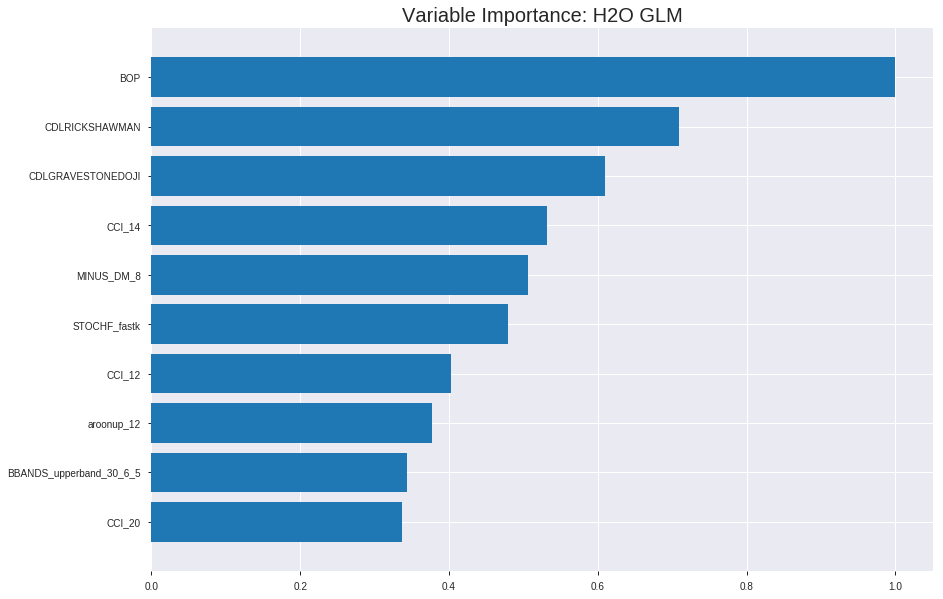

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131908_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22891070333296268
RMSE: 0.4784461342021301
LogLoss: 0.6496544655165734
Null degrees of freedom: 1786
Residual degrees of freedom: 1639
Null deviance: 2477.240311645719
Residual deviance: 2321.8650597562328
AIC: 2617.8650597562328
AUC: 0.6686301846896953
pr_auc: 0.6450575160849169
Gini: 0.3372603693793905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40310124992139373: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      300  599   0.6663   (599.0/899.0)
1      108  780   0.1216   (108.0/888.0)
Total  408  1379  0.3956   (707.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403101     0.688134  278
max f2                       0.260367     0.835065  373
max f0point5                 0.466911     0.620315  222
max accuracy                 0.466911     0.621712  222
max precision                0.767368     0.857143  11
max recall                   0.200435     1         393
max specificity              0.94785      0.998888  0
max absolute_mcc             0.404863     0.253498  277
max min_per_class_accuracy   0.508811     0.617117  184
max mean_per_class_accuracy  0.466911     0.62247   222

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.753225           1.56519   1.56519            0.777778         0.801944  0.777778                    0.801944            0.0157658       0.0157658                  56.519    56.519
    2        0.0201455                   0.717079           1.56519   1.56519            0.777778         0.729675  0.777778                    0.765809            0.0157658       0.0315315                  56.519    56.519
    3        0.0302182                   0.698576           1.45339   1.52792            0.722222         0.707494  0.759259                    0.746371            0.0146396       0.0461712                  45.3391   52.7924
    4        0.040291                    0.684097           1.22979   1.45339            0.611111         0.690947  0.722222                    0.732515            0.0123874       0.0585586                  22.9792   45.3391
    5        0.0503637                   0.676001           1.67699   1.49811            0.833333         0.679943  0.744444                    0.722001            0.0168919       0.0754505                  67.6989   49.8111
    6        0.100168                    0.64166            1.53755   1.51772            0.764045         0.65614   0.75419                     0.689254            0.0765766       0.152027                   53.7554   51.7722
    7        0.149972                    0.615402           1.44711   1.49427            0.719101         0.628719  0.742537                    0.669151            0.0720721       0.224099                   44.711    49.4273
    8        0.200336                    0.59552            1.14035   1.4053             0.566667         0.605034  0.698324                    0.653032            0.0574324       0.281532                   14.0353   40.5298
    9        0.299944                    0.566593           1.19839   1.33659            0.595506         0.580981  0.664179                    0.629105            0.119369        0.400901                   19.8388   33.6586
    10       0.400112                    0.539039           1.07927   1.27217            0.536313         0.553317  0.632168                    0.610131            0.108108        0.509009                   7.92692   27.2167
    11       0.50028                     0.507719           1.07927   1.23354            0.536313         0.524093  0.612975                    0.592904            0.108108        0.617117                   7.92692   23.3544
    12       0.599888                    0.475194           0.972277  1.19016            0.483146         0.492184  0.591418                    0.57618             0.0968468       0.713964                   -2.77229  19.0162
    13       0.700056                    0.435308           0.966845  1.15821            0.480447         0.454279  0.57554                     0.558738            0.0968468       0.810811                   -3.31547  15.8209
    14       0.799664                    0.390839           0.859222  1.12097            0.426966         0.414403  0.557033                    0.540759            0.0855856       0.896396                   -14.0778  12.0966
    15       0.899832                    0.333625           0.584604  1.06126            0.290503         0.367232  0.527363                    0.521442            0.0585586       0.954955                   -41.5396  6.1259
    16       1                           0.000648398        0.449696  1                  0.223464         0.276651  0.496922                    0.496922            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23884398624535208
RMSE: 0.48871667277201836
LogLoss: 0.6713126164896966
Null degrees of freedom: 509
Residual degrees of freedom: 362
Null deviance: 706.9309586242457
Residual deviance: 684.7388688194907
AIC: 980.7388688194907
AUC: 0.6238674645049147
pr_auc: 0.5945722840744191
Gini: 0.2477349290098294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42949470836013426: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      99   160  0.6178   (160.0/259.0)
1      42   209  0.1673   (42.0/251.0)
Total  141  369  0.3961   (202.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429495     0.674194  278
max f2                       0.12155      0.829478  398
max f0point5                 0.429495     0.605096  278
max accuracy                 0.435248     0.603922  274
max precision                0.69825      0.818182  10
max recall                   0.12155      1         398
max specificity              0.85531      0.996139  0
max absolute_mcc             0.429495     0.240225  278
max min_per_class_accuracy   0.50609      0.594595  195
max mean_per_class_accuracy  0.429495     0.607454  278

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 49.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.736606           1.35458   1.35458            0.666667         0.778464  0.666667                    0.778464            0.0159363       0.0159363                  35.4582    35.4582
    2        0.0215686                   0.69713            2.03187   1.66244            1                0.71493   0.818182                    0.749585            0.0199203       0.0358566                  103.187    66.2441
    3        0.0313725                   0.678244           1.21912   1.5239             0.6              0.685057  0.75                        0.72942             0.0119522       0.0478088                  21.9124    52.3904
    4        0.0411765                   0.670297           1.21912   1.45134            0.6              0.675458  0.714286                    0.716572            0.0119522       0.059761                   21.9124    45.1338
    5        0.0509804                   0.663629           1.6255    1.48483            0.8              0.666646  0.730769                    0.706971            0.0159363       0.0756972                  62.5498    48.483
    6        0.1                         0.630022           1.13785   1.31474            0.56             0.646267  0.647059                    0.677214            0.0557769       0.131474                   13.7849    31.4741
    7        0.15098                     0.605401           1.25038   1.29301            0.615385         0.616194  0.636364                    0.65661             0.063745        0.195219                   25.0383    29.301
    8        0.2                         0.586635           1.13785   1.25498            0.56             0.594552  0.617647                    0.6414              0.0557769       0.250996                   13.7849    25.498
    9        0.3                         0.55378            1.23506   1.24834            0.607843         0.568663  0.614379                    0.617154            0.123506        0.374502                   23.506     24.834
    10       0.4                         0.527361           0.996016  1.18526            0.490196         0.539418  0.583333                    0.59772             0.0996016       0.474104                   -0.398406  18.5259
    11       0.5                         0.50609            1.23506   1.19522            0.607843         0.516081  0.588235                    0.581392            0.123506        0.59761                    23.506     19.5219
    12       0.6                         0.473136           0.996016  1.16202            0.490196         0.490293  0.571895                    0.566209            0.0996016       0.697211                   -0.398406  16.2019
    13       0.7                         0.438968           1.0757    1.14969            0.529412         0.457461  0.565826                    0.550674            0.10757         0.804781                   7.56972    14.9687
    14       0.8                         0.406134           0.63745   1.08566            0.313725         0.419598  0.534314                    0.534289            0.063745        0.868526                   -36.255    8.56574
    15       0.9                         0.362577           0.63745   1.03586            0.313725         0.383953  0.509804                    0.517585            0.063745        0.932271                   -36.255    3.58566
    16       1                           0.0531073          0.677291  1                  0.333333         0.303224  0.492157                    0.49


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:19:08  0.000 sec   2            .68E1     148           1.3793806773186406  1.382562144910263
     2019-08-22 13:19:08  0.056 sec   4            .49E1     148           1.3774734596008347  1.3813690805709484
     2019-08-22 13:19:09  0.111 sec   6            .36E1     148           1.3750898621380925  1.3798209468935323
     2019-08-22 13:19:09  0.163 sec   8            .26E1     148           1.3721505100511238  1.377873488043721
     2019-08-22 13:19:09  0.215 sec   10           .19E1     148           1.368555597739364   1.375480794475011
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:19:09  1.001 sec   38           .22E-1    148           1.2962657367826782  1.3427668487421112
     2019-08-22 13:19:09  1.054 sec   40           .16E-1    148           1.2934862073933686  1.343288074223137
     2019-08-22 13:19:10  1.115 sec   42           .12E-1    148           1.2909100127475714  1.3441267927542688
     2019-08-22 13:19:10  1.180 sec   44           .86E-2    148           1.2884860166087309  1.3452436380036419
     2019-08-22 13:19:10  1.237 sec   46           .63E-2    148           1.2861740767139207  1.346546435428879


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.65234375)

('F1', 0.7390029325513197)

('auc', 0.6707600195503421)

('logloss', 0.6493483832507143)

('mean_per_class_error', 0.3564271749755621)

('rmse', 0.4783037100011536)

('mse', 0.2287744390008677)

glm prediction progress: |████████████████████████████████████████████████| 100%


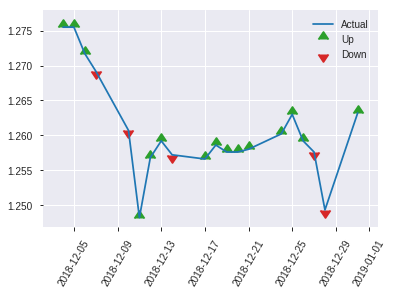


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2287744390008677
RMSE: 0.4783037100011536
LogLoss: 0.6493483832507143
Null degrees of freedom: 255
Residual degrees of freedom: 108
Null deviance: 354.999547062732
Residual deviance: 332.4663722243657
AIC: 628.4663722243657
AUC: 0.6707600195503421
pr_auc: 0.6355737828415846
Gini: 0.3415200391006843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3860725943118004: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   83   0.6694   (83.0/124.0)
1      6    126  0.0455   (6.0/132.0)
Total  47   209  0.3477   (89.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386073     0.739003  208
max f2                       0.358017     0.857713  223
max f0point5                 0.398355     0.651709  200
max accuracy                 0.398355     0.652344  200
max precision                0.656639     0.888889  8
max recall                   0.24553      1         253
max specificity              0.726081     0.991935  0
max absolute_mcc             0.386073     0.368138  208
max min_per_class_accuracy   0.503869     0.628788  128
max mean_per_class_accuracy  0.398355     0.643573  200

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.693369           1.29293   1.29293            0.666667         0.713999  0.666667                    0.713999            0.0151515       0.0151515                  29.2929   29.2929
    2        0.0234375                   0.674743           1.93939   1.61616            1                0.677829  0.833333                    0.695914            0.0227273       0.0378788                  93.9394   61.6162
    3        0.03125                     0.659366           1.93939   1.69697            1                0.667453  0.875                       0.688799            0.0151515       0.0530303                  93.9394   69.697
    4        0.0429688                   0.652984           0.646465  1.41047            0.333333         0.65514   0.727273                    0.679619            0.00757576      0.0606061                  -35.3535  41.0468
    5        0.0507812                   0.643882           0.969697  1.34266            0.5              0.647039  0.692308                    0.674607            0.00757576      0.0681818                  -3.0303   34.2657
    6        0.101562                    0.622729           1.04429   1.19347            0.538462         0.632993  0.615385                    0.6538              0.0530303       0.121212                   4.4289    19.3473
    7        0.152344                    0.601731           1.49184   1.29293            0.769231         0.610805  0.666667                    0.639468            0.0757576       0.19697                    49.1841   29.2929
    8        0.203125                    0.588283           1.34266   1.30536            0.692308         0.593672  0.673077                    0.628019            0.0681818       0.265152                   34.2657   30.5361
    9        0.300781                    0.559864           1.08606   1.23416            0.56             0.574833  0.636364                    0.610751            0.106061        0.371212                   8.60606   23.416
    10       0.402344                    0.531376           1.19347   1.22389            0.615385         0.545695  0.631068                    0.594329            0.121212        0.492424                   19.3473   22.3889
    11       0.5                         0.504962           1.31879   1.24242            0.68             0.51806   0.640625                    0.579433            0.128788        0.621212                   31.8788   24.2424
    12       0.601562                    0.475315           1.04429   1.20897            0.538462         0.492987  0.623377                    0.564838            0.106061        0.727273                   4.4289    20.8973
    13       0.699219                    0.434084           0.930909  1.17014            0.48             0.454491  0.603352                    0.549426            0.0909091       0.818182                   -6.90909  17.0137
    14       0.800781                    0.392793           1.19347   1.1731             0.615385         0.414254  0.604878                    0.532283            0.121212        0.939394                   19.3473   17.3097
    15       0.898438                    0.346338           0.387879  1.08775            0.2              0.368458  0.56087                     0.514476            0.0378788       0.977273                   -61.2121  8.7747
    16       1                           0.24067            0.223776  1                  0.115385         0.307565  0.515625                    0.493461            

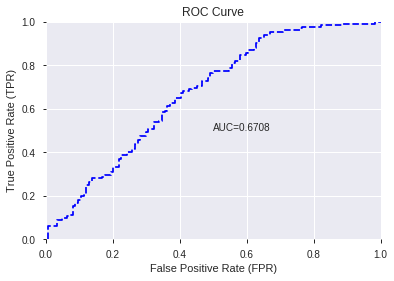

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


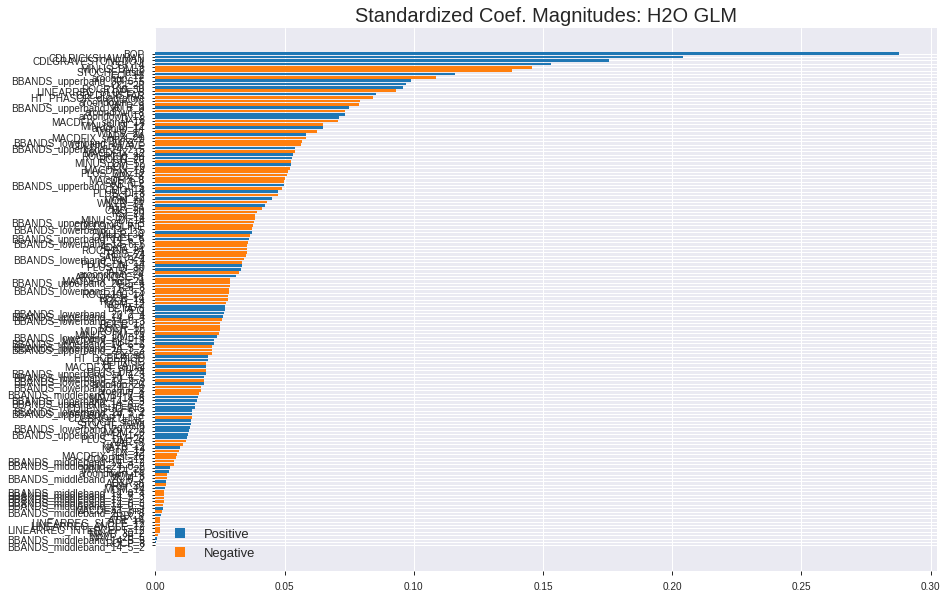

'log_likelihood'
--2019-08-22 13:19:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


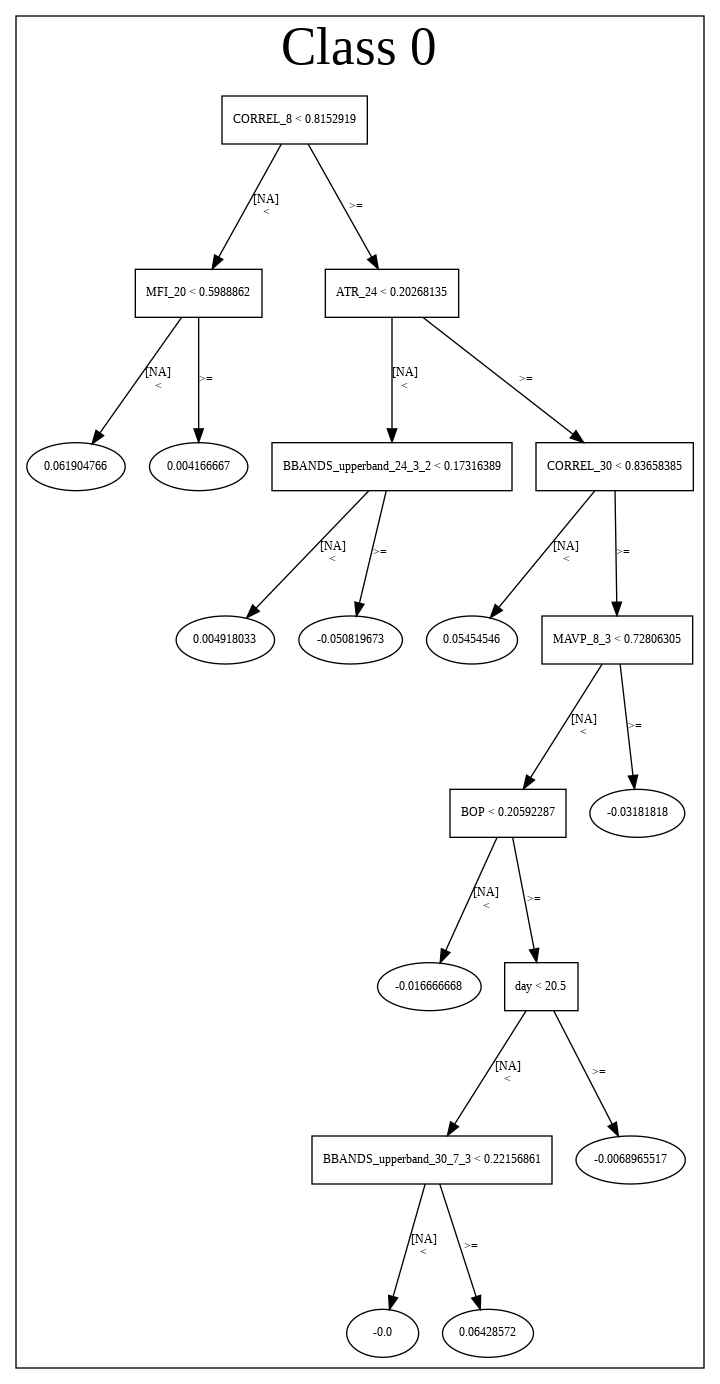

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131908_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131908_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'CCI_14',
 'MINUS_DM_8',
 'STOCHF_fastk',
 'CCI_12',
 'aroonup_12',
 'BBANDS_upperband_30_6_5',
 'CCI_20',
 'ROCR100_30',
 'LINEARREG_SLOPE_8',
 'CDLDOJISTAR',
 'HT_PHASOR_quadrature',
 'aroondown_20',
 'NATR_8',
 'BBANDS_upperband_30_7_3',
 'aroondown_8',
 'aroondown_12',
 'DX_8',
 'MACDFIX_signal_14',
 'MINUS_DI_12',
 'aroonup_14',
 'WILLR_20',
 'ADX_24',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_24_3_5',
 'CDLHIGHWAVE',
 'BBANDS_upperband_24_2_5',
 'MACDFIX_12',
 'ROCR100_20',
 'ROCR_20',
 'MINUS_DM_12',
 'ROC_20',
 'MACDFIX_14',
 'PLUS_DM_12',
 'ADX_8',
 'MACDFIX_8',
 'SAR_0.2',
 'BBANDS_upperband_24_0_5',
 'CMO_14',
 'PLUS_DI_8',
 'RSI_12',
 'MOM_30',
 'WILLR_14',
 'ATR_24',
 'CMO_20',
 'RSI_20',
 'DX_14',
 'MINUS_DI_14',
 'BBANDS_upperband_20_6_5',
 'CDLLONGLINE',
 'BBANDS_lowerband_14_1_5',
 'WILLR_30',
 'CORREL_8',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_14_6_5',
 'ADXR_14',
 'ROCR100_24',
 'ROC_24',
 'SAR_0.24',
 'BBANDS_

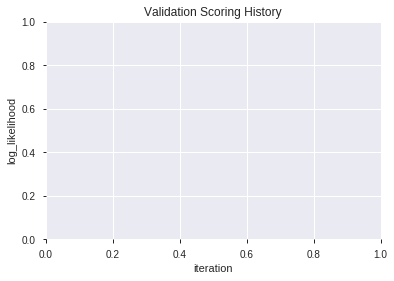

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_131924_model_4  0.697336  0.652127              0.401760  0.479362  0.229788
1  XGBoost_grid_1_AutoML_20190822_131924_model_2  0.683773  0.655753              0.339565  0.481207  0.231560
2               XGBoost_2_AutoML_20190822_131924  0.677969  0.649862              0.385386  0.478241  0.228715
3  XGBoost_grid_1_AutoML_20190822_131924_model_1  0.677297  0.672777              0.397239  0.489987  0.240087
4  XGBoost_grid_1_AutoML_20190822_131924_model_6  0.670882  0.657022              0.379888  0.481777  0.232109
5               XGBoost_3_AutoML_20190822_131924  0.668988  0.659357              0.365591  0.483255  0.233536
6  XGBoost_grid_1_AutoML_20190822_131924_model_3  0.647300  0.661715              0.407869  0.484444  0.234686
7  XGBoost_grid_1_AutoML_20190822_131924_model_7  0.645467  0.668085              0.384409  0.487607  0.237761
8               XGBoost_1_AutoML_20190822_131924  0.612292  0.677392              0.470308  0.491911  0.241976
9  XGBoost_grid_1_AutoML_20190822_131924_model_5  0.555535  0.708206              0.475318  0.506912  0.256960

variable  relative_importance  scaled_importance  percentage
0                        BOP           402.463501           1.000000    0.114540
1                 MINUS_DM_8           133.439758           0.331557    0.037977
2             CDLRICKSHAWMAN           116.784576           0.290174    0.033236
3               STOCHF_fastk           116.437691           0.289312    0.033138
4                   WILLR_14            98.315872           0.244285    0.027980
..                       ...                  ...                ...         ...
94   BBANDS_lowerband_14_3_3             6.303771           0.015663    0.001794
95   BBANDS_lowerband_14_6_5             6.104840           0.015169    0.001737
96   BBANDS_upperband_30_6_5             5.934840           0.014746    0.001689
97  BBANDS_middleband_14_2_2             5.438486           0.013513    0.001548
98                    RSI_30             4.697264           0.011671    0.001337

[99 rows x 4 columns]

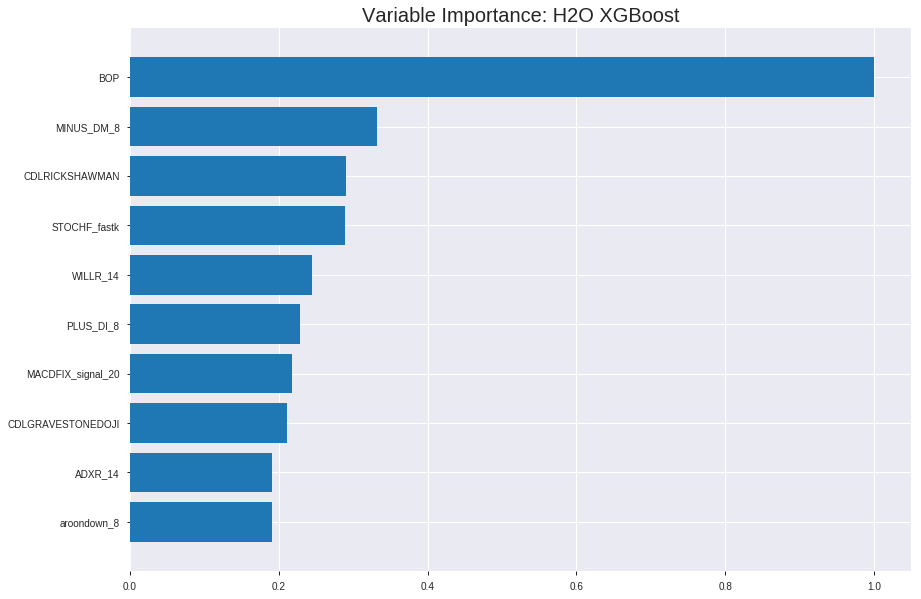

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_131924_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.207211382819195
RMSE: 0.4552047702069861
LogLoss: 0.6049293399972903
Mean Per-Class Error: 0.26830174167493404
AUC: 0.7965651274188538
pr_auc: 0.7821276309255251
Gini: 0.5931302548377075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46837357878685: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      517  382   0.4249   (382.0/899.0)
1      129  759   0.1453   (129.0/888.0)
Total  646  1141  0.286    (511.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468374     0.748152  223
max f2                       0.3108       0.842417  348
max f0point5                 0.525298     0.739872  162
max accuracy                 0.521517     0.731953  166
max precision                0.728095     1         0
max recall                   0.229472     1         389
max specificity              0.728095     1         0
max absolute_mcc             0.521517     0.465419  166
max min_per_class_accuracy   0.508935     0.72525   181
max mean_per_class_accuracy  0.520168     0.731698  168

Gains/Lift Table: Avg response rate: 49.69 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.695944           2.01239   2.01239            1                0.707354  1                           0.707354            0.0202703       0.0202703                  101.239   101.239
    2        0.0201455                   0.685297           1.78879   1.90059            0.888889         0.691962  0.944444                    0.699658            0.018018        0.0382883                  78.8789   90.0588
    3        0.0302182                   0.674097           1.90059   1.90059            0.944444         0.67986   0.944444                    0.693059            0.0191441       0.0574324                  90.0588   90.0588
    4        0.040291                    0.66585            1.67699   1.84469            0.833333         0.669853  0.916667                    0.687257            0.0168919       0.0743243                  67.6989   84.4688
    5        0.0503637                   0.66014            1.90059   1.85587            0.944444         0.662884  0.922222                    0.682383            0.0191441       0.0934685                  90.0588   85.5868
    6        0.100168                    0.63294            1.65061   1.75381            0.820225         0.644268  0.871508                    0.663432            0.0822072       0.175676                   65.061    75.3812
    7        0.149972                    0.61414            1.49233   1.66698            0.741573         0.623353  0.828358                    0.650122            0.0743243       0.25                       49.2332   66.6978
    8        0.200336                    0.597014           1.65463   1.66387            0.822222         0.605853  0.826816                    0.638993            0.0833333       0.333333                   65.463    66.3873
    9        0.299944                    0.566333           1.56017   1.62943            0.775281         0.581697  0.809701                    0.619966            0.155405        0.488739                   56.0166   62.9433
    10       0.400112                    0.537707           1.29287   1.54518            0.642458         0.55179   0.767832                    0.602898            0.129505        0.618243                   29.2875   54.5176
    11       0.50028                     0.508707           1.10175   1.45639            0.547486         0.52226   0.723714                    0.586752            0.11036         0.728604                   10.1754   45.6392
    12       0.599888                    0.479866           0.949666  1.37225            0.47191          0.494973  0.681903                    0.571513            0.0945946       0.823198                   -5.0334   37.2253
    13       0.700056                    0.450645           0.663301  1.27081            0.329609         0.465047  0.631495                    0.556279            0.0664414       0.88964                    -33.6699  27.0812
    14       0.799664                    0.403434           0.463527  1.17025            0.230337         0.426262  0.581526                    0.540084            0.0461712       0.935811                   -53.6473  17.0255
    15       0.899832                    0.339656           0.348514  1.07878            0.173184         0.37229   0.53607                     0.521405            0.0349099       0.970721                   -65.1486  7.87798
    16       1                           0.192477           0.292302  1                  0.145251         0.292597  0.496922                    0.498486         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23989443453723736
RMSE: 0.4897901944069903
LogLoss: 0.6722805577673091
Mean Per-Class Error: 0.4179190573612884
AUC: 0.6084465227891522
pr_auc: 0.5878147979942623
Gini: 0.21689304557830447
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38578635454177856: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   232  0.8958   (232.0/259.0)
1      3    248  0.012    (3.0/251.0)
Total  30   480  0.4608   (235.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385786     0.678523  369
max f2                       0.385786     0.83558   369
max f0point5                 0.443593     0.582775  319
max accuracy                 0.57152      0.586275  98
max precision                0.707933     1         0
max recall                   0.337711     1         387
max specificity              0.707933     1         0
max absolute_mcc             0.385786     0.196103  369
max min_per_class_accuracy   0.519478     0.565737  194
max mean_per_class_accuracy  0.57152      0.582081  98

Gains/Lift Table: Avg response rate: 49.22 %, avg score: 51.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117647                   0.670726           1.01594   1.01594            0.5              0.686832  0.5                         0.686832            0.0119522       0.0119522                  1.59363    1.59363
    2        0.0215686                   0.650694           1.6255    1.29301            0.8              0.657315  0.636364                    0.673415            0.0159363       0.0278884                  62.5498    29.301
    3        0.0313725                   0.643638           1.21912   1.26992            0.6              0.646344  0.625                       0.664956            0.0119522       0.0398406                  21.9124    26.992
    4        0.0411765                   0.639006           1.6255    1.35458            0.8              0.641238  0.666667                    0.659308            0.0159363       0.0557769                  62.5498    35.4582
    5        0.0509804                   0.634437           1.6255    1.40668            0.8              0.636758  0.692308                    0.654972            0.0159363       0.0717131                  62.5498    40.6681
    6        0.1                         0.611382           1.38167   1.39442            0.68             0.621907  0.686275                    0.638764            0.0677291       0.139442                   38.1673    39.4422
    7        0.15098                     0.591643           1.25038   1.34579            0.615385         0.600888  0.662338                    0.625974            0.063745        0.203187                   25.0383    34.5786
    8        0.2                         0.578849           1.3004    1.33466            0.64             0.584861  0.656863                    0.615898            0.063745        0.266932                   30.0398    33.4661
    9        0.3                         0.557563           1.0757    1.24834            0.529412         0.567897  0.614379                    0.599897            0.10757         0.374502                   7.56972    24.834
    10       0.4                         0.539013           0.996016  1.18526            0.490196         0.548205  0.583333                    0.586974            0.0996016       0.474104                   -0.398406  18.5259
    11       0.5                         0.51908            0.916335  1.13147            0.45098          0.529808  0.556863                    0.575541            0.0916335       0.565737                   -8.36653   13.1474
    12       0.6                         0.501637           0.876494  1.08898            0.431373         0.511313  0.535948                    0.564836            0.0876494       0.653386                   -12.3506   8.89774
    13       0.7                         0.479368           1.03586   1.08139            0.509804         0.490674  0.532213                    0.554242            0.103586        0.756972                   3.58566    8.13887
    14       0.8                         0.452083           0.956175  1.06574            0.470588         0.466224  0.52451                     0.543239            0.0956175       0.85259                    -4.38247   6.57371
    15       0.9                         0.407161           0.996016  1.05799            0.490196         0.431157  0.520697                    0.530786            0.0996016       0.952191                   -0.398406  5.79903
    16       1                           0.250879           0.478088  1                  0.235294         0.359343  0.492157                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:19:33  2.907 sec   0                  0.5              0.693147            0.5             0                  1                0.503078                         0.5                0.693147              0.5               0                    1                  0.507843
    2019-08-22 13:19:33  3.037 sec   5                  0.49259          0.678413            0.694685        0.663144           1.38225          0.368774                         0.496939           0.687035              0.59561           0.559794             1.01594            0.472549
    2019-08-22 13:19:33  3.107 sec   10                 0.486676         0.666733            0.722065        0.697136           1.78879          0.331281                         0.495322           0.683801              0.600155          0.569997             1.35458            0.44902
    2019-08-22 13:19:33  3.183 sec   15                 0.481187         0.655929            0.735686        0.704544           1.78879          0.328483                         0.492969           0.679076              0.613092          0.578116             1.35458            0.456863
    2019-08-22 13:19:33  3.257 sec   20                 0.476975         0.647642            0.748546        0.725457           1.90059          0.326245                         0.492398           0.6779                0.610785          0.578503             1.69323            0.456863
    2019-08-22 13:19:33  3.336 sec   25                 0.472909         0.639605            0.750723        0.729884           1.78879          0.325686                         0.491945           0.676971              0.6097            0.578568             1.35458            0.45098
    2019-08-22 13:19:33  3.421 sec   30                 0.468861         0.631628            0.759104        0.737006           1.78879          0.30498                          0.490133           0.673267              0.616661          0.592476             1.69323            0.445098
    2019-08-22 13:19:33  3.506 sec   35                 0.464812         0.623708            0.772012        0.755146           1.90059          0.323447                         0.489771           0.672488              0.615438          0.58726              1.69323            0.437255
    2019-08-22 13:19:33  3.592 sec   40                 0.461229         0.616792            0.786443        0.773063           1.90059          0.275881                         0.489657           0.672196              0.616484          0.594419             1.35458            0.452941
    2019-08-22 13:19:34  3.680 sec   45                 0.458252         0.610954            0.793118        0.777316           1.90059          0.287633                         0.489383           0.671571              0.615015          0.590095             1.35458            0.447059
    2019-08-22 13:19:34  3.770 sec   50                 0.455205         0.604929            0.796565        0.782128           2.01239          0.285954                         0.48979            0.672281              0.608447          0.587815             1.01594            0.460784

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       402.4635009765625      1.0                   0.11453975097395379
MINUS_DM_8                133.43975830078125     0.3315574157084921    0.03797650382881836
CDLRICKSHAWMAN            116.78457641601562     0.2901743291817575    0.033236495403512596
STOCHF_fastk              116.43769073486328     0.289312423244174     0.03313777291205881
WILLR_14                  98.31587219238281      0.2442851884800064    0.0279803646551253
---                       ---                    ---                   ---
BBANDS_lowerband_14_3_3   6.303771018981934      0.015662963234395345  0.0017940319083818367
BBANDS_lowerband_14_6_5   6.104840278625488      0.015168680548204555  0.0017374168925948065
BBANDS_upperband_30_6_5   5.934840202331543      0.014746281806749872  0.0016890354459368757
BBANDS_middleband_14_2_2  5.438486099243164      0.013512992075174228  0.001547774747203467
RSI_30                    4.697263717651367      0.011671278777463382  0.0013368253647182476


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.67578125)

('F1', 0.7159090909090909)

('auc', 0.697336265884653)

('logloss', 0.652126700793507)

('mean_per_class_error', 0.32563538611925713)

('rmse', 0.47936247216805117)

('mse', 0.22978837972306562)

xgboost prediction progress: |████████████████████████████████████████████| 100%


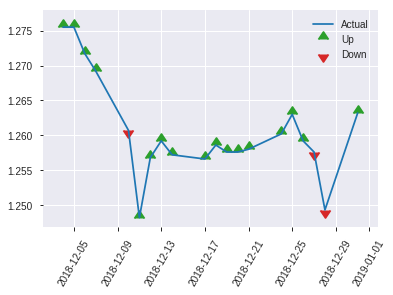


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22978837972306562
RMSE: 0.47936247216805117
LogLoss: 0.652126700793507
Mean Per-Class Error: 0.32563538611925713
AUC: 0.697336265884653
pr_auc: 0.6685533472639059
Gini: 0.39467253176930606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.426464319229126: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      30   94   0.7581   (94.0/124.0)
1      6    126  0.0455   (6.0/132.0)
Total  36   220  0.3906   (100.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426464     0.715909  219
max f2                       0.392574     0.847458  238
max f0point5                 0.514218     0.682471  140
max accuracy                 0.514218     0.675781  140
max precision                0.679542     1         0
max recall                   0.290836     1         255
max specificity              0.679542     1         0
max absolute_mcc             0.514218     0.350371  140
max min_per_class_accuracy   0.519858     0.66129   129
max mean_per_class_accuracy  0.514218     0.674365  140

Gains/Lift Table: Avg response rate: 51.56 %, avg score: 51.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.67607            1.29293   1.29293            0.666667         0.678907  0.666667                    0.678907            0.0151515       0.0151515                  29.2929   29.2929
    2        0.0234375                   0.659891           1.29293   1.29293            0.666667         0.666492  0.666667                    0.6727              0.0151515       0.030303                   29.2929   29.2929
    3        0.03125                     0.657422           1.93939   1.45455            1                0.658937  0.75                        0.669259            0.0151515       0.0454545                  93.9394   45.4545
    4        0.0429688                   0.651796           0.646465  1.23416            0.333333         0.654715  0.636364                    0.665292            0.00757576      0.0530303                  -35.3535  23.416
    5        0.0507812                   0.640725           1.93939   1.34266            1                0.645605  0.692308                    0.662263            0.0151515       0.0681818                  93.9394   34.2657
    6        0.101562                    0.619305           1.49184   1.41725            0.769231         0.630763  0.730769                    0.646513            0.0757576       0.143939                   49.1841   41.7249
    7        0.152344                    0.605118           1.49184   1.44211            0.769231         0.611528  0.74359                     0.634851            0.0757576       0.219697                   49.1841   44.2113
    8        0.203125                    0.591148           1.49184   1.45455            0.769231         0.598581  0.75                        0.625784            0.0757576       0.295455                   49.1841   45.4545
    9        0.300781                    0.564279           1.31879   1.41047            0.68             0.574144  0.727273                    0.609018            0.128788        0.424242                   31.8788   41.0468
    10       0.402344                    0.540077           0.820513  1.26155            0.423077         0.550163  0.650485                    0.594161            0.0833333       0.507576                   -17.9487  26.1548
    11       0.5                         0.521031           1.55152   1.31818            0.8              0.530618  0.679688                    0.58175             0.151515        0.659091                   55.1515   31.8182
    12       0.601562                    0.505113           0.969697  1.25935            0.5              0.513549  0.649351                    0.570236            0.0984848       0.757576                   -3.0303   25.9347
    13       0.699219                    0.482008           0.698182  1.18097            0.36             0.495235  0.608939                    0.559761            0.0681818       0.825758                   -30.1818  18.0972
    14       0.800781                    0.453896           0.596737  1.10687            0.307692         0.471966  0.570732                    0.548626            0.0606061       0.886364                   -40.3263  10.6874
    15       0.898438                    0.412291           0.775758  1.07088            0.4              0.430631  0.552174                    0.5358              0.0757576       0.962121                   -22.4242  7.08827
    16       1                           0.290836           0.37296   1                  0.192308         0.371194  0.515625                    0.519082          

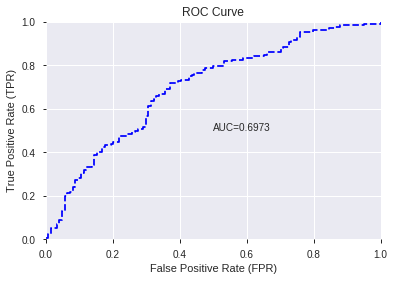

This function is available for GLM models only


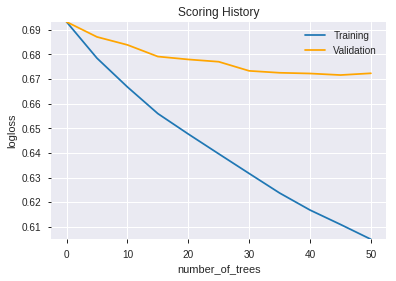

--2019-08-22 13:19:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

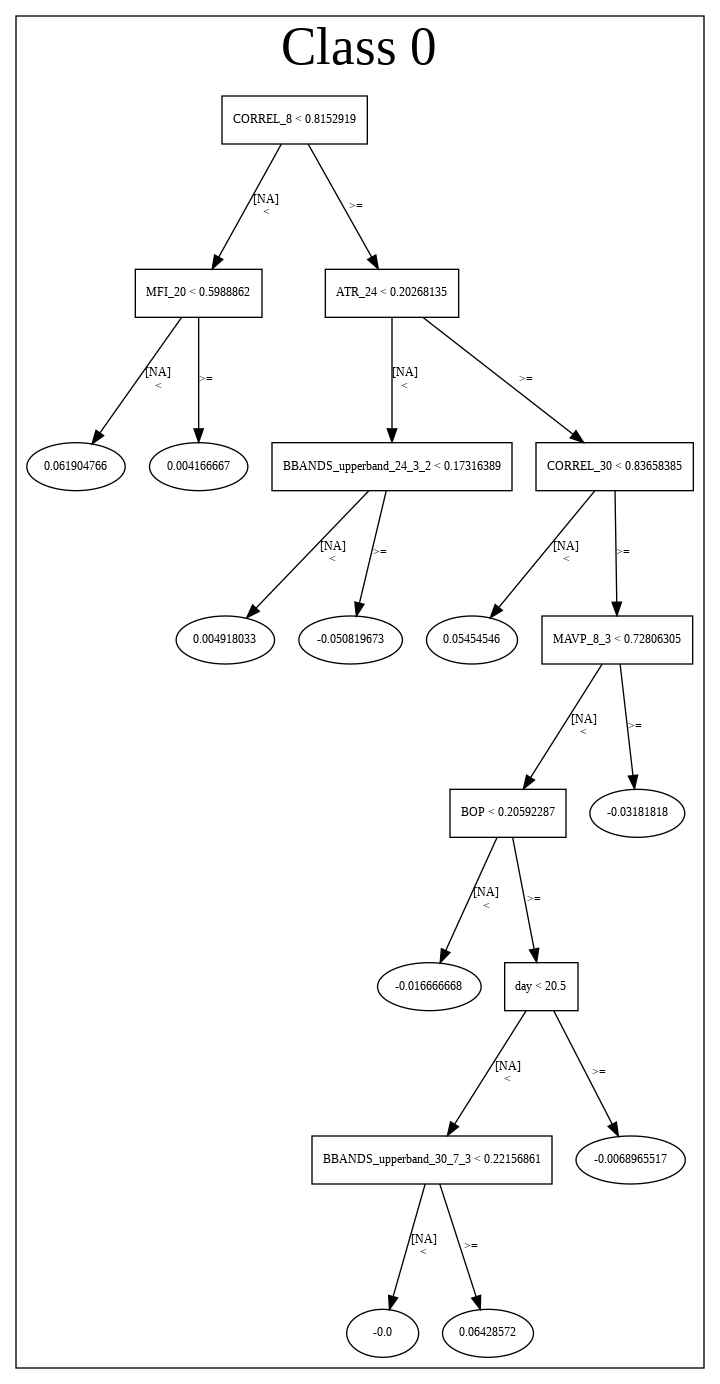

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_131924_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_131924_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b408',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'MINUS_DM_8',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'WILLR_14',
 'PLUS_DI_8',
 'MACDFIX_signal_20',
 'CDLGRAVESTONEDOJI',
 'ADXR_14',
 'aroondown_8',
 'MOM_12',
 'aroondown_20',
 'MINUS_DI_12',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'HT_DCPERIOD',
 'ATR_24',
 'BBANDS_upperband_20_6_5',
 'MACDFIX_signal_14',
 'BBANDS_lowerband_20_0_4',
 'VAR_8',
 'CORREL_12',
 'WILLR_20',
 'MACDFIX_8',
 'ROCR100_30',
 'STOCH_slowk',
 'ADXR_8',
 'PLUS_DM_12',
 'DX_8',
 'BBANDS_upperband_20_1_3',
 'LINEARREG_SLOPE_8',
 'MOM_14',
 'BBANDS_lowerband_14_4_2',
 'PPO',
 'WILLR_30',
 'aroondown_24',
 'MOM_20',
 'BBANDS_lowerband_24_3_5',
 'ADX_8',
 'CCI_14',
 'CCI_12',
 'MACDEXT_hist',
 'MOM_30',
 'BBANDS_upperband_14_0_4',
 'DX_12',
 'MIDPOINT_30',
 'BBANDS_upperband_14_7_4',
 'LINEARREG_ANGLE_12',
 'ADX_24',
 'BETA_12',
 'PLUS_DI_30',
 'MINUS_DM_14',
 'DX_30',
 'MACDEXT_signal',
 'ROCP_14',
 'ROC_20',
 'MACDFIX_hist_20',
 'aroonup_12',
 'BBANDS_lowerband_14_0_2',
 'CMO_14',
 'LINEARREG_INTE

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.691
GLM             0.668
XGBoost         0.707
dtype: float64

DeepLearning    GLM  XGBoost
All          0.672  0.668    0.660
DLF          0.660  0.648    0.660
Fwe          0.652  0.664    0.707
RFE          0.691  0.652    0.676
XGBF         0.668  0.648    0.660





F1


DeepLearning    0.733
GLM             0.739
XGBoost         0.741
dtype: float64

DeepLearning    GLM  XGBoost
All          0.733  0.727    0.731
DLF          0.716  0.712    0.702
Fwe          0.728  0.733    0.741
RFE          0.732  0.739    0.716
XGBF         0.721  0.712    0.702





auc


DeepLearning    0.727
GLM             0.693
XGBoost         0.744
dtype: float64

DeepLearning    GLM  XGBoost
All          0.670  0.693    0.713
DLF          0.697  0.679    0.694
Fwe          0.692  0.692    0.744
RFE          0.727  0.671    0.697
XGBF         0.701  0.679    0.694





logloss


DeepLearning    0.677
GLM             0.660
XGBoost         0.652
dtype: float64

DeepLearning    GLM  XGBoost
All          0.677  0.651    0.637
DLF          0.634  0.651    0.643
Fwe          0.651  0.660    0.638
RFE          0.655  0.649    0.652
XGBF         0.632  0.651    0.643





mean_per_class_error


DeepLearning    0.354
GLM             0.356
XGBoost         0.339
dtype: float64

DeepLearning    GLM  XGBoost
All          0.333  0.335    0.339
DLF          0.343  0.349    0.335
Fwe          0.354  0.339    0.293
RFE          0.310  0.356    0.326
XGBF         0.330  0.349    0.335





rmse


DeepLearning    0.491
GLM             0.484
XGBoost         0.479
dtype: float64

DeepLearning    GLM  XGBoost
All          0.491  0.479    0.472
DLF          0.473  0.479    0.475
Fwe          0.479  0.484    0.472
RFE          0.481  0.478    0.479
XGBF         0.470  0.479    0.475





mse


DeepLearning    0.241
GLM             0.234
XGBoost         0.230
dtype: float64

DeepLearning    GLM  XGBoost
All          0.241  0.229    0.223
DLF          0.223  0.230    0.226
Fwe          0.230  0.234    0.223
RFE          0.231  0.229    0.230
XGBF         0.221  0.230    0.226

{'F1':       DeepLearning    GLM  XGBoost
 All          0.733    NaN      NaN
 DLF          0.716    NaN      NaN
 DLF            NaN  0.712      NaN
 DLF            NaN    NaN    0.702
 All            NaN  0.727      NaN
 All            NaN    NaN    0.731
 XGBF         0.721    NaN      NaN
 XGBF           NaN  0.712      NaN
 XGBF           NaN    NaN    0.702
 Fwe          0.728    NaN      NaN
 Fwe            NaN  0.733      NaN
 Fwe            NaN    NaN    0.741
 RFE          0.732    NaN      NaN
 RFE            NaN  0.739      NaN
 RFE            NaN    NaN    0.716,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.672    NaN      NaN
 DLF          0.660    NaN      NaN
 DLF            NaN  0.648      NaN
 DLF            NaN    NaN    0.660
 All            NaN  0.668      NaN
 All            NaN    NaN    0.660
 XGBF         0.668    NaN      NaN
 XGBF           NaN  0.648      NaN
 XGBF           NaN    NaN    0.660
 Fwe          0.652    NaN      NaN
 Fwe     